In [ ]:
# 설치

!pip install pycaret
!pip install catboost
!pip install optuna

In [1]:
# 라이브러리

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# for "Modeling with Pycaret"
from pycaret.regression import *

# for "Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# 한글 인코딩, 마이너스 꺠짐 처리

import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        !wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        !mv malgun.ttf /usr/share/fonts/truetype/
        import matplotlib.font_manager as fm 
        fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
pd.set_option('display.max_row', 500)

In [3]:
# 데이터 로드
PATH = "C:\\Users\\user\\PerfectGuid\\Parking_DACON"
age_gender = pd.read_csv(PATH + '\\age_gender_info.csv')
train = pd.read_csv(PATH + '\\train.csv')
test = pd.read_csv(PATH + '\\test.csv')
sample = pd.read_csv(PATH + '\\sample_submission.csv')

# 1. Preprocessing for Data Error 

In [4]:
droplist = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036','C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
for i in droplist:
    idx = train[train['단지코드']== i].index
    train = train.drop(idx)

# 2. NULL Preprocessing, Duplicate Removal, Row Integration

In [5]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

# 3. Feature Engineering

## 3.1 Remove Data

In [6]:
# 의미없는 Feature 제거 :  "임대건물구분_아파트"의 경우 모두가 1이다.

X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

In [7]:
# 이상치 제거 : 지하철역 수가 3인 데이터 제거

display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)

# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    139
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
Name: 총세대수, dtype: int64

## 3.2 Encoding

In [8]:
%%time 
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

Wall time: 82.8 ms


## 3.3 Scailing

In [9]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std']

In [10]:
# 도보 10분거리 std Fearure 제거
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [11]:
# 지역 Fearure Robust Scailing
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [12]:
# 나머지 Fearure Standard Scailing

from sklearn.preprocessing import StandardScaler

scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

# 데이터에 지역 다시 추가 : 지역별 피처 추가 위함
X_train = pd.merge(X_train, train_agg[['지역']], left_on= X_train.index , right_on= train_agg.index, how='left')
X_test= pd.merge(X_test, test_agg[['지역']], left_on= X_test.index , right_on= test_agg.index, how='left')
X_train = X_train.drop(['key_0'], axis=1)
X_test = X_test.drop(['key_0'], axis=1)

# 4. Feature 추가

In [13]:
# 지역별 성별 나이 피처 추가

X_train = pd.merge(X_train, age_gender, left_on= ["지역"], right_on= ["지역"], how='left')
X_test = pd.merge(X_test, age_gender, left_on= ["지역"], right_on= ["지역"], how='left')

In [14]:
# Scailing

scailing_features_jiyuk_age = X_train.iloc[:, 23:].columns
scaler = StandardScaler()
X_train.loc[:, scailing_features_jiyuk_age] = scaler.fit_transform(X_train[scailing_features_jiyuk_age])
X_test.loc[:, scailing_features_jiyuk_age] = scaler.transform(X_test[scailing_features_jiyuk_age])
X_train = X_train.drop(['지역'], axis=1)
X_test = X_test.drop(['지역'], axis=1)

# 5. y Log Transformation

<AxesSubplot:title={'center':'원 등록차량수'}, xlabel='등록차량수', ylabel='Density'>

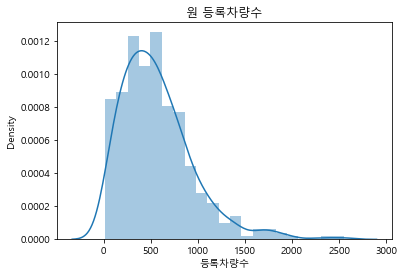

In [15]:
# y 분포
plt.title('원 등록차량수')
sns.distplot(X_train['등록차량수'])

<AxesSubplot:title={'center':'로그변환된 등록차량수'}, xlabel='등록차량수', ylabel='Density'>

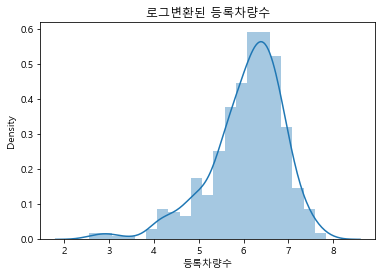

In [16]:
# train의 y를 로그변환

plt.title('로그변환된 등록차량수')
X_train['등록차량수'] = np.log(X_train['등록차량수'])
sns.distplot(X_train['등록차량수'])

#  6. Modeling with pycaret

In [17]:
# Modeling with pycaret
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True,
            n_jobs = -1
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(410, 44)"
3,Missing Values,False
4,Numeric Features,43
5,Categorical Features,0
6,Transformed Train Set,"(409, 43)"
7,Transformed Test Set,"(1, 43)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [18]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2501,0.1255,0.3428,0.8116,0.0533,0.0448,0.0200
et,Extra Trees Regressor,0.2609,0.1373,0.3621,0.7912,0.0558,0.0463,0.0500
rf,Random Forest Regressor,0.2643,0.1375,0.3602,0.7955,0.0557,0.0473,0.0600
catboost,CatBoost Regressor,0.2661,0.1461,0.3712,0.7880,0.0608,0.0493,0.5310
xgboost,Extreme Gradient Boosting,0.2685,0.1376,0.3615,0.7919,0.0551,0.0472,0.1220
lightgbm,Light Gradient Boosting Machine,0.2791,0.1566,0.3865,0.7708,0.0631,0.0514,0.0910
huber,Huber Regressor,0.2955,0.1900,0.4260,0.7255,0.0706,0.0556,0.0080
ridge,Ridge Regression,0.3064,0.1912,0.4300,0.7202,0.0708,0.0568,0.0040
lr,Linear Regression,0.3119,0.1910,0.4305,0.7191,0.0701,0.0572,0.2790
br,Bayesian Ridge,0.3119,0.1987,0.4378,0.7105,0.0722,0.0580,0.0040


In [19]:
top5

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2021, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, m

In [20]:
# Top5 Model Tuning
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 50))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1398,0.0391,0.1976,0.9191,0.0305,0.0240
1,0.2240,0.0850,0.2916,0.8975,0.0426,0.0375
2,0.1656,0.0498,0.2233,0.9303,0.0338,0.0291
3,0.2617,0.1623,0.4028,0.7639,0.0605,0.0468
4,0.3498,0.3115,0.5581,0.5426,0.0958,0.0710
5,0.1930,0.0619,0.2487,0.8816,0.0354,0.0320
6,0.2876,0.1307,0.3616,0.8305,0.0573,0.0529
7,0.2462,0.1048,0.3237,0.8352,0.0490,0.0435
8,0.2618,0.1190,0.3449,0.7457,0.0497,0.0432
9,0.2721,0.1157,0.3401,0.8936,0.0473,0.0454


In [21]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 50)

voting = finalize_model(voting)
sample = pd.read_csv(PATH + '/sample_submission.csv')
layer1_pred = voting.predict(X_test)
sample['num'] = layer1_pred
sample.to_csv('pycaret.csv', index=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1477,0.0386,0.1965,0.9200,0.0297,0.0252
1,0.2140,0.0746,0.2731,0.9101,0.0402,0.0363
2,0.1715,0.0526,0.2293,0.9265,0.0375,0.0314
3,0.2672,0.1585,0.3982,0.7693,0.0599,0.0478
4,0.3464,0.3146,0.5609,0.5381,0.0960,0.0703
5,0.2007,0.0644,0.2538,0.8767,0.0364,0.0337
6,0.2864,0.1324,0.3639,0.8283,0.0592,0.0537
7,0.2506,0.1147,0.3386,0.8197,0.0514,0.0445
8,0.2522,0.1012,0.3181,0.7837,0.0456,0.0414
9,0.2522,0.1044,0.3230,0.9040,0.0451,0.0420


In [22]:
layer1_pred = voting.predict(X_test)
sample['num'] = layer1_pred
sample.to_csv('pycaret.csv', index=False)

In [23]:
layer1_pred

array([6.56394606, 6.98200236, 6.11819368, 6.19108902, 6.92046194,
       7.42220134, 6.78251437, 5.99335037, 5.74112674, 5.59645668,
       6.13249848, 5.12062396, 5.79105135, 5.6262691 , 5.3689269 ,
       5.53207724, 6.05607415, 5.7285968 , 5.07684543, 6.45963301,
       5.1906954 , 5.87556856, 5.94419546, 6.13063584, 5.80344828,
       4.71020617, 4.837024  , 6.22171923, 6.034705  , 6.06420692,
       6.70529272, 4.95136923, 6.06464627, 5.4931787 , 4.4370354 ,
       5.75096254, 6.15983557, 6.35941711, 6.66527731, 5.7710421 ,
       6.00489365, 6.11452673, 6.0509527 , 6.20224541, 6.68353369,
       7.08791237, 6.17504062, 6.47024982, 6.08564408, 5.99975519,
       6.66385734, 5.63381326, 6.86127278, 6.37110119, 6.23412457,
       5.56915716, 6.35740236, 5.54474149, 6.07830794, 4.75162848,
       5.89745478, 6.22588983, 6.84363399, 5.98415103, 4.77095561,
       5.71319402, 6.12721995, 6.66828361, 6.32768541, 5.98194977,
       6.60574165, 5.72464795, 6.40068847, 6.72282326, 6.81022

In [24]:
layer1_pred_to_real = np.exp(layer1_pred)
layer1_pred_to_real

array([ 709.06418987, 1077.07289487,  454.04380468,  488.37766895,
       1012.78773569, 1672.71167283,  882.28432948,  400.75504236,
        311.41509606,  269.46989706,  460.5854871 ,  167.43981213,
        327.35701026,  277.6243942 ,  214.63242241,  252.66821968,
        426.69699418,  307.53742896,  160.26768171,  638.82657341,
        179.59339913,  356.22713979,  381.53228146,  459.72838098,
        331.44049053,  111.07505842,  126.09353882,  503.5682355 ,
        417.67557541,  430.18137272,  816.7170616 ,  141.3683977 ,
        430.37041442,  243.02849385,   84.52399019,  314.49322693,
        473.3502355 ,  577.90940077,  784.68103674,  320.87194002,
        405.40787253,  452.38190017,  424.51727394,  493.85670826,
        799.13803086, 1197.40545241,  480.60254622,  645.64500008,
        439.50279735,  403.33004415,  783.56759927,  279.72675782,
        954.58126597,  584.70134364,  509.85408229,  262.21300178,
        576.74623077,  255.88841913,  436.29033934,  115.77266

In [25]:
sample['num'] = layer1_pred_to_real
sample.to_csv('submission_layer1_pred_to_real_0729.csv', index=False)

# 7. Modeling

In [26]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

In [27]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 1.0, 3.0), 
        "iterations": 2000,
        "verbose" : 100,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 200),
        "max_bin": trial.suggest_int("max_bin", 200, 1000),
        "grow_policy" : 'SymmetricTree'
        #"max_leaves": 20
        
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [39]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt_0730_3000",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=6000)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-30 17:07:07,149] A new study created in memory with name: cat_opt_0730_3000
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-07-30 17:07:08,710] Trial 0 finished with value: 0.3101974640665732 and parameters: {'learning_rate': 0.04370861069626263, 'l2_leaf_reg': 2.9014286128198323, 'max_depth': 12, 'colsample_bylevel': 0.6789267873576292, 'subsample': 0.3248149123539492, 'min_child_samples': 33, 'max_bin': 246}. Best is trial 0 with value: 0.3101974640665732.
[I 2021-07-30 17:07:09,466] Trial 1 finished with value: 0.27795689864362705 and parameters: {'learning_rate': 0.08795585311974417, 'l2_leaf_reg': 2.2022300234864174, 'max_depth': 12, 'colsample_bylevel': 0.21646759543664196, 'subsample': 0.9759278817295955, 'min_child_samples': 167, 'max_bin': 370}. Best is trial 1 with value: 0.27795689864362705.
[I 2021-07-30 17:07:09,744] Trial 2 finished with value: 0.28399091831678147 and parameters: {'learning_rate': 0.02636

[I 2021-07-30 17:07:29,792] Trial 23 finished with value: 0.2680973619506368 and parameters: {'learning_rate': 0.07898585634039888, 'l2_leaf_reg': 1.4879621797877662, 'max_depth': 2, 'colsample_bylevel': 0.42419098056200494, 'subsample': 0.5639695752615105, 'min_child_samples': 148, 'max_bin': 893}. Best is trial 5 with value: 0.2242840070395834.
[I 2021-07-30 17:07:29,936] Trial 24 finished with value: 0.251362322146429 and parameters: {'learning_rate': 0.09815219881590302, 'l2_leaf_reg': 1.687966574784875, 'max_depth': 4, 'colsample_bylevel': 0.5861007947510591, 'subsample': 0.3073355954455678, 'min_child_samples': 173, 'max_bin': 788}. Best is trial 5 with value: 0.2242840070395834.
[I 2021-07-30 17:07:30,096] Trial 25 finished with value: 0.2966910218798694 and parameters: {'learning_rate': 0.06835184307315337, 'l2_leaf_reg': 1.1115317031602565, 'max_depth': 2, 'colsample_bylevel': 0.23704245024818407, 'subsample': 0.41445666937611786, 'min_child_samples': 135, 'max_bin': 543}. Bes

[I 2021-07-30 17:07:38,433] Trial 46 finished with value: 0.2739471837076129 and parameters: {'learning_rate': 0.07233998133455971, 'l2_leaf_reg': 1.0596389164326097, 'max_depth': 4, 'colsample_bylevel': 0.6571944486780378, 'subsample': 0.8332845272482011, 'min_child_samples': 82, 'max_bin': 623}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:38,645] Trial 47 finished with value: 0.2484864564345143 and parameters: {'learning_rate': 0.06490731528925969, 'l2_leaf_reg': 1.38907531333901, 'max_depth': 5, 'colsample_bylevel': 0.8554147034272551, 'subsample': 0.956945737258774, 'min_child_samples': 99, 'max_bin': 752}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:38,930] Trial 48 finished with value: 0.2557575564513292 and parameters: {'learning_rate': 0.07681478523932998, 'l2_leaf_reg': 1.783430683080977, 'max_depth': 7, 'colsample_bylevel': 0.561870994710997, 'subsample': 0.8726261141327276, 'min_child_samples': 145, 'max_bin': 796}. Best is

[I 2021-07-30 17:07:41,933] Trial 69 finished with value: 0.2216653638727924 and parameters: {'learning_rate': 0.0739171641297161, 'l2_leaf_reg': 2.720066300977539, 'max_depth': 2, 'colsample_bylevel': 0.6725054558994294, 'subsample': 0.9686729392091097, 'min_child_samples': 156, 'max_bin': 621}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:42,055] Trial 70 finished with value: 0.2789208299763982 and parameters: {'learning_rate': 0.08461170594980115, 'l2_leaf_reg': 1.8926841994486756, 'max_depth': 1, 'colsample_bylevel': 0.7323692279983669, 'subsample': 0.5394947434102232, 'min_child_samples': 104, 'max_bin': 414}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:42,160] Trial 71 finished with value: 0.25656508813976003 and parameters: {'learning_rate': 0.07471537458215603, 'l2_leaf_reg': 2.7819158723154263, 'max_depth': 2, 'colsample_bylevel': 0.6651632984243356, 'subsample': 0.9134704675280192, 'min_child_samples': 170, 'max_bin': 626}. B

[I 2021-07-30 17:07:45,424] Trial 92 finished with value: 0.24593191866922798 and parameters: {'learning_rate': 0.07540062211843056, 'l2_leaf_reg': 1.4692567163739338, 'max_depth': 2, 'colsample_bylevel': 0.5712215480903754, 'subsample': 0.5888976280286519, 'min_child_samples': 108, 'max_bin': 575}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:45,533] Trial 93 finished with value: 0.2560123452715517 and parameters: {'learning_rate': 0.07845044978053743, 'l2_leaf_reg': 1.5889024721641933, 'max_depth': 1, 'colsample_bylevel': 0.5512591458652627, 'subsample': 0.8934843415033246, 'min_child_samples': 129, 'max_bin': 551}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:45,653] Trial 94 finished with value: 0.26718880007826984 and parameters: {'learning_rate': 0.06735183423359345, 'l2_leaf_reg': 1.752794741779223, 'max_depth': 2, 'colsample_bylevel': 0.6243216703417579, 'subsample': 0.5595292090841475, 'min_child_samples': 124, 'max_bin': 594}.

[I 2021-07-30 17:07:56,106] Trial 115 finished with value: 0.33626119525821013 and parameters: {'learning_rate': 0.0659965664360872, 'l2_leaf_reg': 2.6593395815759036, 'max_depth': 12, 'colsample_bylevel': 0.7158716722976174, 'subsample': 0.6884977966883041, 'min_child_samples': 182, 'max_bin': 698}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:56,271] Trial 116 finished with value: 0.23932785270752008 and parameters: {'learning_rate': 0.05829343795512905, 'l2_leaf_reg': 2.8243673868162524, 'max_depth': 3, 'colsample_bylevel': 0.6545144888921796, 'subsample': 0.7107816304193559, 'min_child_samples': 165, 'max_bin': 527}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:56,422] Trial 117 finished with value: 0.22949205622226293 and parameters: {'learning_rate': 0.06980032212200758, 'l2_leaf_reg': 1.1989389639882817, 'max_depth': 2, 'colsample_bylevel': 0.5718357700543862, 'subsample': 0.8909453335334077, 'min_child_samples': 154, 'max_bin': 

[I 2021-07-30 17:07:59,277] Trial 138 finished with value: 0.26120890311793094 and parameters: {'learning_rate': 0.05289478538323103, 'l2_leaf_reg': 1.2266912090321545, 'max_depth': 4, 'colsample_bylevel': 0.6724473288880666, 'subsample': 0.7688741321106587, 'min_child_samples': 129, 'max_bin': 618}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:59,381] Trial 139 finished with value: 0.2679207255091529 and parameters: {'learning_rate': 0.06894141281206975, 'l2_leaf_reg': 1.001209137139248, 'max_depth': 3, 'colsample_bylevel': 0.7348757651360223, 'subsample': 0.9618407732050078, 'min_child_samples': 116, 'max_bin': 566}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:07:59,526] Trial 140 finished with value: 0.2376907163440135 and parameters: {'learning_rate': 0.07582146686320299, 'l2_leaf_reg': 2.123711094493968, 'max_depth': 1, 'colsample_bylevel': 0.6563849448088203, 'subsample': 0.882577226505707, 'min_child_samples': 165, 'max_bin': 676}.

[I 2021-07-30 17:08:02,356] Trial 161 finished with value: 0.3351388460494471 and parameters: {'learning_rate': 0.060195735855889165, 'l2_leaf_reg': 1.2856692544174102, 'max_depth': 1, 'colsample_bylevel': 0.6344710990092383, 'subsample': 0.6576543731499745, 'min_child_samples': 123, 'max_bin': 691}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:02,493] Trial 162 finished with value: 0.25138515277183376 and parameters: {'learning_rate': 0.06292021978890543, 'l2_leaf_reg': 1.3544091029384904, 'max_depth': 2, 'colsample_bylevel': 0.6216082392131618, 'subsample': 0.5823081331592355, 'min_child_samples': 115, 'max_bin': 642}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:02,636] Trial 163 finished with value: 0.23953291973966434 and parameters: {'learning_rate': 0.05890225906734296, 'l2_leaf_reg': 1.2969109558394485, 'max_depth': 3, 'colsample_bylevel': 0.66791467718203, 'subsample': 0.6156685472706462, 'min_child_samples': 121, 'max_bin': 67

[I 2021-07-30 17:08:05,895] Trial 184 finished with value: 0.2753869860060756 and parameters: {'learning_rate': 0.07868103572533612, 'l2_leaf_reg': 1.5278530012123406, 'max_depth': 3, 'colsample_bylevel': 0.6869670190120186, 'subsample': 0.7633796230782768, 'min_child_samples': 124, 'max_bin': 555}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:06,026] Trial 185 finished with value: 0.2577547089114971 and parameters: {'learning_rate': 0.08043728239633494, 'l2_leaf_reg': 1.3811615912834632, 'max_depth': 3, 'colsample_bylevel': 0.6615224997318458, 'subsample': 0.7547784930205648, 'min_child_samples': 109, 'max_bin': 580}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:06,165] Trial 186 finished with value: 0.2476023374199555 and parameters: {'learning_rate': 0.07509780226249171, 'l2_leaf_reg': 1.43372600122294, 'max_depth': 3, 'colsample_bylevel': 0.5896020442193742, 'subsample': 0.7210682525493389, 'min_child_samples': 118, 'max_bin': 604}.

[I 2021-07-30 17:08:09,305] Trial 207 finished with value: 0.23382476218316675 and parameters: {'learning_rate': 0.07906585417529553, 'l2_leaf_reg': 1.6051111259399788, 'max_depth': 1, 'colsample_bylevel': 0.681855463712653, 'subsample': 0.802979889016141, 'min_child_samples': 133, 'max_bin': 826}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:09,424] Trial 208 finished with value: 0.2894745693782807 and parameters: {'learning_rate': 0.074459137475184, 'l2_leaf_reg': 2.8922846911407283, 'max_depth': 2, 'colsample_bylevel': 0.7022115675741065, 'subsample': 0.7896616882518801, 'min_child_samples': 104, 'max_bin': 681}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:09,584] Trial 209 finished with value: 0.26717791143359204 and parameters: {'learning_rate': 0.0659523192500012, 'l2_leaf_reg': 1.3324161724917907, 'max_depth': 3, 'colsample_bylevel': 0.6570771824616919, 'subsample': 0.748969399360213, 'min_child_samples': 122, 'max_bin': 621}. B

[I 2021-07-30 17:08:12,497] Trial 230 finished with value: 0.2185445883091617 and parameters: {'learning_rate': 0.07922136413976771, 'l2_leaf_reg': 1.5759804073246215, 'max_depth': 2, 'colsample_bylevel': 0.6789248207444928, 'subsample': 0.7200714281765763, 'min_child_samples': 117, 'max_bin': 691}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:12,632] Trial 231 finished with value: 0.3100637390907377 and parameters: {'learning_rate': 0.08119244807844528, 'l2_leaf_reg': 1.5658837231627465, 'max_depth': 2, 'colsample_bylevel': 0.6788168644991739, 'subsample': 0.716927205117503, 'min_child_samples': 117, 'max_bin': 694}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:12,747] Trial 232 finished with value: 0.25950927570478405 and parameters: {'learning_rate': 0.07865750440109176, 'l2_leaf_reg': 1.5895802529588448, 'max_depth': 2, 'colsample_bylevel': 0.6985547595206858, 'subsample': 0.7372783576769968, 'min_child_samples': 115, 'max_bin': 681

[I 2021-07-30 17:08:18,390] Trial 253 finished with value: 0.19126873777099418 and parameters: {'learning_rate': 0.07724358098433894, 'l2_leaf_reg': 1.4670969001679957, 'max_depth': 3, 'colsample_bylevel': 0.7128242085501313, 'subsample': 0.7682673441050755, 'min_child_samples': 136, 'max_bin': 680}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:18,585] Trial 254 finished with value: 0.30345863900608205 and parameters: {'learning_rate': 0.07706690441197013, 'l2_leaf_reg': 1.4218081870853505, 'max_depth': 3, 'colsample_bylevel': 0.7138478276915087, 'subsample': 0.7692466500676685, 'min_child_samples': 135, 'max_bin': 690}. Best is trial 28 with value: 0.18955103671251147.
[I 2021-07-30 17:08:18,714] Trial 255 finished with value: 0.2855053709675154 and parameters: {'learning_rate': 0.08251943611692486, 'l2_leaf_reg': 1.4740125182502453, 'max_depth': 3, 'colsample_bylevel': 0.7016262803742067, 'subsample': 0.7276019643933499, 'min_child_samples': 137, 'max_bin': 6

[I 2021-07-30 17:08:21,683] Trial 276 finished with value: 0.2546908777293624 and parameters: {'learning_rate': 0.07130184050792747, 'l2_leaf_reg': 1.2224542450578113, 'max_depth': 3, 'colsample_bylevel': 0.7623620314999521, 'subsample': 0.7597501544419349, 'min_child_samples': 120, 'max_bin': 716}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:21,853] Trial 277 finished with value: 0.2295474569960634 and parameters: {'learning_rate': 0.07626970932338338, 'l2_leaf_reg': 1.3609743505382037, 'max_depth': 1, 'colsample_bylevel': 0.682150292727661, 'subsample': 0.7746486723601964, 'min_child_samples': 93, 'max_bin': 658}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:22,017] Trial 278 finished with value: 0.24961024569545015 and parameters: {'learning_rate': 0.047699142587926666, 'l2_leaf_reg': 1.1501140599293154, 'max_depth': 4, 'colsample_bylevel': 0.7055100320221168, 'subsample': 0.5286182433621628, 'min_child_samples': 107, 'max_bin': 5

[I 2021-07-30 17:08:25,021] Trial 299 finished with value: 0.2793369613471663 and parameters: {'learning_rate': 0.08019439252721138, 'l2_leaf_reg': 1.3283428803240043, 'max_depth': 5, 'colsample_bylevel': 0.680225169395403, 'subsample': 0.7644147202408663, 'min_child_samples': 119, 'max_bin': 573}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:25,180] Trial 300 finished with value: 0.2519816987619301 and parameters: {'learning_rate': 0.08319096608506933, 'l2_leaf_reg': 1.4163490935080483, 'max_depth': 4, 'colsample_bylevel': 0.5696008977181132, 'subsample': 0.8257092412620527, 'min_child_samples': 115, 'max_bin': 586}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:25,327] Trial 301 finished with value: 0.23418945257052418 and parameters: {'learning_rate': 0.07756755933894809, 'l2_leaf_reg': 1.3779731063970755, 'max_depth': 4, 'colsample_bylevel': 0.603037954386375, 'subsample': 0.7451262118055545, 'min_child_samples': 144, 'max_bin': 93

[I 2021-07-30 17:08:29,002] Trial 322 finished with value: 0.2996441362200822 and parameters: {'learning_rate': 0.07648772862287122, 'l2_leaf_reg': 1.488963125739439, 'max_depth': 2, 'colsample_bylevel': 0.6543417784198671, 'subsample': 0.7916049997435773, 'min_child_samples': 123, 'max_bin': 642}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:29,166] Trial 323 finished with value: 0.2487550636416506 and parameters: {'learning_rate': 0.08026978691299642, 'l2_leaf_reg': 1.3351148814962914, 'max_depth': 3, 'colsample_bylevel': 0.552998831586721, 'subsample': 0.36310252152682865, 'min_child_samples': 117, 'max_bin': 666}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:29,304] Trial 324 finished with value: 0.27494770430931303 and parameters: {'learning_rate': 0.08195133231071573, 'l2_leaf_reg': 1.528125138657896, 'max_depth': 2, 'colsample_bylevel': 0.6285737407130695, 'subsample': 0.7380194013374546, 'min_child_samples': 130, 'max_bin': 57

[I 2021-07-30 17:08:41,276] Trial 345 finished with value: 0.23724901656365152 and parameters: {'learning_rate': 0.07030289761051144, 'l2_leaf_reg': 1.55796900527841, 'max_depth': 4, 'colsample_bylevel': 0.6685274289168388, 'subsample': 0.8073632347170201, 'min_child_samples': 124, 'max_bin': 633}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:41,413] Trial 346 finished with value: 0.2209402812456539 and parameters: {'learning_rate': 0.08752895885127228, 'l2_leaf_reg': 1.3274583200772514, 'max_depth': 2, 'colsample_bylevel': 0.7610583508951746, 'subsample': 0.7437713312648903, 'min_child_samples': 118, 'max_bin': 664}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:41,524] Trial 347 finished with value: 0.23726504945372748 and parameters: {'learning_rate': 0.07321841488353203, 'l2_leaf_reg': 1.74864158348494, 'max_depth': 3, 'colsample_bylevel': 0.8210448278354165, 'subsample': 0.7063403975556656, 'min_child_samples': 93, 'max_bin': 707}

[I 2021-07-30 17:08:44,288] Trial 368 finished with value: 0.2317902074549586 and parameters: {'learning_rate': 0.08093548913315558, 'l2_leaf_reg': 1.7943802613862523, 'max_depth': 1, 'colsample_bylevel': 0.5722987098188089, 'subsample': 0.6711675518814946, 'min_child_samples': 109, 'max_bin': 599}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:44,425] Trial 369 finished with value: 0.27552109675669484 and parameters: {'learning_rate': 0.07933265396915912, 'l2_leaf_reg': 1.6701282850878028, 'max_depth': 4, 'colsample_bylevel': 0.6007832819049598, 'subsample': 0.6309949222178138, 'min_child_samples': 128, 'max_bin': 576}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:44,543] Trial 370 finished with value: 0.2847675803546751 and parameters: {'learning_rate': 0.08283224411430351, 'l2_leaf_reg': 1.5371651303261256, 'max_depth': 3, 'colsample_bylevel': 0.5612945132045666, 'subsample': 0.6095696616285716, 'min_child_samples': 133, 'max_bin': 

[I 2021-07-30 17:08:48,181] Trial 391 finished with value: 0.2719562694730327 and parameters: {'learning_rate': 0.08222517519726992, 'l2_leaf_reg': 1.5985116683751117, 'max_depth': 5, 'colsample_bylevel': 0.7086462285777985, 'subsample': 0.7412017338412953, 'min_child_samples': 126, 'max_bin': 558}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:48,323] Trial 392 finished with value: 0.30166700359964194 and parameters: {'learning_rate': 0.07314168521132347, 'l2_leaf_reg': 1.3474284874542415, 'max_depth': 1, 'colsample_bylevel': 0.5768148055843859, 'subsample': 0.6817503718820321, 'min_child_samples': 108, 'max_bin': 830}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:48,481] Trial 393 finished with value: 0.2369556867654413 and parameters: {'learning_rate': 0.0790672079992781, 'l2_leaf_reg': 1.4124930384556353, 'max_depth': 2, 'colsample_bylevel': 0.762050863867446, 'subsample': 0.7196943048311636, 'min_child_samples': 117, 'max_bin': 59

[I 2021-07-30 17:08:57,379] Trial 414 finished with value: 0.22748731610459902 and parameters: {'learning_rate': 0.06924927765940489, 'l2_leaf_reg': 1.4473096270687233, 'max_depth': 1, 'colsample_bylevel': 0.7515613488638194, 'subsample': 0.7575715568801977, 'min_child_samples': 114, 'max_bin': 747}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:57,583] Trial 415 finished with value: 0.2647776898802617 and parameters: {'learning_rate': 0.0777624009454663, 'l2_leaf_reg': 1.4034410611512076, 'max_depth': 5, 'colsample_bylevel': 0.601948234656753, 'subsample': 0.6242450172075409, 'min_child_samples': 103, 'max_bin': 581}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:08:57,803] Trial 416 finished with value: 0.26599938171626875 and parameters: {'learning_rate': 0.08017104823546074, 'l2_leaf_reg': 1.5147692451350787, 'max_depth': 2, 'colsample_bylevel': 0.6777744462057178, 'subsample': 0.7995168020436645, 'min_child_samples': 107, 'max_bin': 6

[I 2021-07-30 17:09:00,896] Trial 437 finished with value: 0.23640748956480337 and parameters: {'learning_rate': 0.07222385622669619, 'l2_leaf_reg': 1.5948055556542775, 'max_depth': 1, 'colsample_bylevel': 0.5694453146419829, 'subsample': 0.6110661363985097, 'min_child_samples': 111, 'max_bin': 589}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:01,056] Trial 438 finished with value: 0.3262935769055326 and parameters: {'learning_rate': 0.08476457030449408, 'l2_leaf_reg': 1.3368422378526534, 'max_depth': 4, 'colsample_bylevel': 0.6891676005259436, 'subsample': 0.7662081368060746, 'min_child_samples': 130, 'max_bin': 607}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:01,387] Trial 439 finished with value: 0.255962655717468 and parameters: {'learning_rate': 0.01002660163218709, 'l2_leaf_reg': 1.4345230081119353, 'max_depth': 2, 'colsample_bylevel': 0.7386826407443554, 'subsample': 0.5869438213066994, 'min_child_samples': 125, 'max_bin': 5

[I 2021-07-30 17:09:04,461] Trial 460 finished with value: 0.2770666516998849 and parameters: {'learning_rate': 0.08179179604181, 'l2_leaf_reg': 1.3599931538741257, 'max_depth': 3, 'colsample_bylevel': 0.6202684930815819, 'subsample': 0.6052167942305482, 'min_child_samples': 131, 'max_bin': 476}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:04,625] Trial 461 finished with value: 0.21840659316619546 and parameters: {'learning_rate': 0.07567805034408734, 'l2_leaf_reg': 1.4726947557611794, 'max_depth': 3, 'colsample_bylevel': 0.5547096379727328, 'subsample': 0.5974659944076094, 'min_child_samples': 200, 'max_bin': 604}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:04,766] Trial 462 finished with value: 0.24035402099102188 and parameters: {'learning_rate': 0.07973676219143777, 'l2_leaf_reg': 1.3965806520728405, 'max_depth': 3, 'colsample_bylevel': 0.5905603700338026, 'subsample': 0.5734901663983314, 'min_child_samples': 109, 'max_bin': 48

[I 2021-07-30 17:09:08,590] Trial 483 finished with value: 0.24722339270628815 and parameters: {'learning_rate': 0.061215426340814505, 'l2_leaf_reg': 1.520692628677915, 'max_depth': 2, 'colsample_bylevel': 0.6212283417818648, 'subsample': 0.7163863037590372, 'min_child_samples': 109, 'max_bin': 635}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:08,765] Trial 484 finished with value: 0.31586560978073663 and parameters: {'learning_rate': 0.07418287757727206, 'l2_leaf_reg': 1.3088779183856731, 'max_depth': 5, 'colsample_bylevel': 0.6612898782583481, 'subsample': 0.9154170440540197, 'min_child_samples': 116, 'max_bin': 567}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:08,928] Trial 485 finished with value: 0.2578004732292723 and parameters: {'learning_rate': 0.036142378817610635, 'l2_leaf_reg': 1.4885620002668052, 'max_depth': 1, 'colsample_bylevel': 0.6003386514069559, 'subsample': 0.6021411751604602, 'min_child_samples': 98, 'max_bin':

[I 2021-07-30 17:09:12,035] Trial 506 finished with value: 0.24743939931803344 and parameters: {'learning_rate': 0.0726957155106531, 'l2_leaf_reg': 1.694537849248204, 'max_depth': 4, 'colsample_bylevel': 0.6193173828803406, 'subsample': 0.7528273244130724, 'min_child_samples': 111, 'max_bin': 553}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:12,135] Trial 507 finished with value: 0.3329925427354236 and parameters: {'learning_rate': 0.07508647134018466, 'l2_leaf_reg': 1.2373372746864038, 'max_depth': 1, 'colsample_bylevel': 0.5279792391829695, 'subsample': 0.7859699657645313, 'min_child_samples': 140, 'max_bin': 577}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:12,234] Trial 508 finished with value: 0.3003660377950331 and parameters: {'learning_rate': 0.05957779513729476, 'l2_leaf_reg': 1.5845388585052442, 'max_depth': 3, 'colsample_bylevel': 0.6798441266165011, 'subsample': 0.42579297551775813, 'min_child_samples': 127, 'max_bin': 5

[I 2021-07-30 17:09:19,350] Trial 529 finished with value: 0.3004860690634758 and parameters: {'learning_rate': 0.06451284031969237, 'l2_leaf_reg': 1.4722327289212043, 'max_depth': 3, 'colsample_bylevel': 0.6285317515639661, 'subsample': 0.7961116720513448, 'min_child_samples': 109, 'max_bin': 639}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:19,491] Trial 530 finished with value: 0.3008683714377518 and parameters: {'learning_rate': 0.07841389891325362, 'l2_leaf_reg': 1.7906513215019875, 'max_depth': 2, 'colsample_bylevel': 0.5903543188831578, 'subsample': 0.6833263755449411, 'min_child_samples': 102, 'max_bin': 596}. Best is trial 258 with value: 0.17706333363956148.
[I 2021-07-30 17:09:19,631] Trial 531 finished with value: 0.1982802502993307 and parameters: {'learning_rate': 0.08181518036503195, 'l2_leaf_reg': 1.3540377081798254, 'max_depth': 4, 'colsample_bylevel': 0.6608651432433059, 'subsample': 0.8284458653679, 'min_child_samples': 117, 'max_bin': 551}

[I 2021-07-30 17:09:23,128] Trial 552 finished with value: 0.2572293143573536 and parameters: {'learning_rate': 0.07298984313315973, 'l2_leaf_reg': 1.3684426276501096, 'max_depth': 5, 'colsample_bylevel': 0.2844448230513573, 'subsample': 0.809281533440299, 'min_child_samples': 145, 'max_bin': 521}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:23,266] Trial 553 finished with value: 0.25520556593129745 and parameters: {'learning_rate': 0.07447757061088593, 'l2_leaf_reg': 1.3981623174462157, 'max_depth': 1, 'colsample_bylevel': 0.5992137479190381, 'subsample': 0.7993216529591318, 'min_child_samples': 136, 'max_bin': 541}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:23,463] Trial 554 finished with value: 0.2974003407702325 and parameters: {'learning_rate': 0.0745559097985943, 'l2_leaf_reg': 2.0865720230943605, 'max_depth': 4, 'colsample_bylevel': 0.6109432371863337, 'subsample': 0.8159087214684537, 'min_child_samples': 138, 'max_bin': 507}

[I 2021-07-30 17:09:27,828] Trial 575 finished with value: 0.23294709521397192 and parameters: {'learning_rate': 0.07596870921272023, 'l2_leaf_reg': 1.491211757539188, 'max_depth': 3, 'colsample_bylevel': 0.5913412503913589, 'subsample': 0.6323994828069869, 'min_child_samples': 112, 'max_bin': 593}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:28,002] Trial 576 finished with value: 0.29210858885287244 and parameters: {'learning_rate': 0.08070420913567136, 'l2_leaf_reg': 1.6083033436152407, 'max_depth': 4, 'colsample_bylevel': 0.6075874906325527, 'subsample': 0.8806566242572651, 'min_child_samples': 137, 'max_bin': 664}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:28,133] Trial 577 finished with value: 0.24669563149361212 and parameters: {'learning_rate': 0.07773073314427524, 'l2_leaf_reg': 1.4228996091222534, 'max_depth': 3, 'colsample_bylevel': 0.6968066932325855, 'subsample': 0.7893325059197104, 'min_child_samples': 125, 'max_bin': 5

[I 2021-07-30 17:09:30,952] Trial 598 finished with value: 0.2571441061191567 and parameters: {'learning_rate': 0.09139007429229103, 'l2_leaf_reg': 1.4118967799955515, 'max_depth': 2, 'colsample_bylevel': 0.6017324153260314, 'subsample': 0.6000271875505735, 'min_child_samples': 115, 'max_bin': 544}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:31,070] Trial 599 finished with value: 0.19863609972450924 and parameters: {'learning_rate': 0.08148931610401294, 'l2_leaf_reg': 1.1490056060072311, 'max_depth': 1, 'colsample_bylevel': 0.5779362966822797, 'subsample': 0.7693620510927476, 'min_child_samples': 101, 'max_bin': 577}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:31,225] Trial 600 finished with value: 0.23231450945971543 and parameters: {'learning_rate': 0.08184799791604887, 'l2_leaf_reg': 1.1752838289839551, 'max_depth': 4, 'colsample_bylevel': 0.575633036552339, 'subsample': 0.8170099692465136, 'min_child_samples': 100, 'max_bin': 57

[I 2021-07-30 17:09:36,015] Trial 621 finished with value: 0.2564527751399355 and parameters: {'learning_rate': 0.07987907483956304, 'l2_leaf_reg': 1.039020289989107, 'max_depth': 2, 'colsample_bylevel': 0.6194415023638986, 'subsample': 0.7930843354526376, 'min_child_samples': 133, 'max_bin': 563}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:36,135] Trial 622 finished with value: 0.2685753311630282 and parameters: {'learning_rate': 0.07835475953203073, 'l2_leaf_reg': 1.1292042173422385, 'max_depth': 2, 'colsample_bylevel': 0.6161340910296879, 'subsample': 0.7675897085859946, 'min_child_samples': 136, 'max_bin': 554}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:36,253] Trial 623 finished with value: 0.23229934137245306 and parameters: {'learning_rate': 0.07664959448024962, 'l2_leaf_reg': 1.0773732317046838, 'max_depth': 2, 'colsample_bylevel': 0.6003021574111179, 'subsample': 0.8091501864584781, 'min_child_samples': 139, 'max_bin': 536

[I 2021-07-30 17:09:39,311] Trial 644 finished with value: 0.24940050511526218 and parameters: {'learning_rate': 0.09731526882337556, 'l2_leaf_reg': 1.1541515024571887, 'max_depth': 2, 'colsample_bylevel': 0.5706037060442816, 'subsample': 0.7565621242576697, 'min_child_samples': 125, 'max_bin': 577}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:39,422] Trial 645 finished with value: 0.239625762029977 and parameters: {'learning_rate': 0.08162583774883227, 'l2_leaf_reg': 1.0732200917059505, 'max_depth': 3, 'colsample_bylevel': 0.6151847600034454, 'subsample': 0.8335688577773143, 'min_child_samples': 133, 'max_bin': 608}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:39,598] Trial 646 finished with value: 0.21846137220142722 and parameters: {'learning_rate': 0.07934590368236066, 'l2_leaf_reg': 1.2595136408220338, 'max_depth': 1, 'colsample_bylevel': 0.4646358495241571, 'subsample': 0.8084903264291186, 'min_child_samples': 139, 'max_bin': 59

[I 2021-07-30 17:09:43,102] Trial 667 finished with value: 0.2635598248727717 and parameters: {'learning_rate': 0.07641957611552985, 'l2_leaf_reg': 1.305865111951045, 'max_depth': 2, 'colsample_bylevel': 0.5608059884139003, 'subsample': 0.6973697385087159, 'min_child_samples': 25, 'max_bin': 561}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:43,226] Trial 668 finished with value: 0.24283613672316987 and parameters: {'learning_rate': 0.06751325600219502, 'l2_leaf_reg': 1.2615904518346626, 'max_depth': 3, 'colsample_bylevel': 0.5966767719430164, 'subsample': 0.8213689201451739, 'min_child_samples': 129, 'max_bin': 646}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:43,332] Trial 669 finished with value: 0.24723739222172672 and parameters: {'learning_rate': 0.07344291093537046, 'l2_leaf_reg': 1.3981766720416917, 'max_depth': 1, 'colsample_bylevel': 0.6247405986456286, 'subsample': 0.6032548657332685, 'min_child_samples': 148, 'max_bin': 539

[I 2021-07-30 17:09:50,085] Trial 690 finished with value: 0.2301496368571301 and parameters: {'learning_rate': 0.07495579995131177, 'l2_leaf_reg': 1.2956122624507247, 'max_depth': 2, 'colsample_bylevel': 0.5514912227177718, 'subsample': 0.681572670676546, 'min_child_samples': 123, 'max_bin': 585}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:50,227] Trial 691 finished with value: 0.28552764714260515 and parameters: {'learning_rate': 0.08302393779139468, 'l2_leaf_reg': 1.2296926453255583, 'max_depth': 5, 'colsample_bylevel': 0.6695255159574112, 'subsample': 0.8048184615901769, 'min_child_samples': 151, 'max_bin': 563}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:50,473] Trial 692 finished with value: 0.25896316158408533 and parameters: {'learning_rate': 0.08029506569717126, 'l2_leaf_reg': 1.903567846044758, 'max_depth': 4, 'colsample_bylevel': 0.5176573865900284, 'subsample': 0.587205505366736, 'min_child_samples': 119, 'max_bin': 634}

[I 2021-07-30 17:09:53,812] Trial 713 finished with value: 0.2834566879696405 and parameters: {'learning_rate': 0.08193432087365231, 'l2_leaf_reg': 1.5138808648472706, 'max_depth': 2, 'colsample_bylevel': 0.55809895934778, 'subsample': 0.817126610370422, 'min_child_samples': 147, 'max_bin': 529}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:53,988] Trial 714 finished with value: 0.26422911141818917 and parameters: {'learning_rate': 0.06972344865896357, 'l2_leaf_reg': 2.054073471396897, 'max_depth': 5, 'colsample_bylevel': 0.7446024841348973, 'subsample': 0.6388904990543568, 'min_child_samples': 111, 'max_bin': 615}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:54,185] Trial 715 finished with value: 0.24536522437601968 and parameters: {'learning_rate': 0.06250550631461188, 'l2_leaf_reg': 1.3049069907897195, 'max_depth': 3, 'colsample_bylevel': 0.5955931374155692, 'subsample': 0.8407565130003868, 'min_child_samples': 121, 'max_bin': 471}.

[I 2021-07-30 17:09:57,867] Trial 736 finished with value: 0.27844532464117294 and parameters: {'learning_rate': 0.07290386369754183, 'l2_leaf_reg': 2.5752394254962514, 'max_depth': 3, 'colsample_bylevel': 0.5787906067380282, 'subsample': 0.7692003625091004, 'min_child_samples': 133, 'max_bin': 522}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:57,982] Trial 737 finished with value: 0.29258172395815024 and parameters: {'learning_rate': 0.08189883632428759, 'l2_leaf_reg': 1.3874176277923165, 'max_depth': 2, 'colsample_bylevel': 0.5104773692717696, 'subsample': 0.6686823120153347, 'min_child_samples': 140, 'max_bin': 769}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:09:58,189] Trial 738 finished with value: 0.24960419830505176 and parameters: {'learning_rate': 0.07920309154317777, 'l2_leaf_reg': 1.5690906446884052, 'max_depth': 4, 'colsample_bylevel': 0.6165791615672489, 'subsample': 0.8067199843815975, 'min_child_samples': 126, 'max_bin': 

[I 2021-07-30 17:10:01,593] Trial 759 finished with value: 0.25411230321967054 and parameters: {'learning_rate': 0.07122743340831253, 'l2_leaf_reg': 1.5305457031562395, 'max_depth': 3, 'colsample_bylevel': 0.6853382549446088, 'subsample': 0.6925441610408604, 'min_child_samples': 107, 'max_bin': 636}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:01,779] Trial 760 finished with value: 0.2719633204340339 and parameters: {'learning_rate': 0.07187713670594316, 'l2_leaf_reg': 1.3568203030852004, 'max_depth': 5, 'colsample_bylevel': 0.7185506813926105, 'subsample': 0.7470884463037429, 'min_child_samples': 127, 'max_bin': 575}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:01,974] Trial 761 finished with value: 0.2932029851794107 and parameters: {'learning_rate': 0.05992534879881569, 'l2_leaf_reg': 1.2953419845448304, 'max_depth': 1, 'colsample_bylevel': 0.6315999540754913, 'subsample': 0.7930102201140679, 'min_child_samples': 115, 'max_bin': 61

[I 2021-07-30 17:10:05,412] Trial 782 finished with value: 0.29025418087069454 and parameters: {'learning_rate': 0.08440328385811113, 'l2_leaf_reg': 1.630577568845163, 'max_depth': 5, 'colsample_bylevel': 0.724379600855596, 'subsample': 0.7469600601745673, 'min_child_samples': 101, 'max_bin': 772}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:05,567] Trial 783 finished with value: 0.31026712018380276 and parameters: {'learning_rate': 0.07754811857936826, 'l2_leaf_reg': 1.49688266240005, 'max_depth': 4, 'colsample_bylevel': 0.7259305045915091, 'subsample': 0.7711446507260932, 'min_child_samples': 90, 'max_bin': 775}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:05,713] Trial 784 finished with value: 0.2721499120621 and parameters: {'learning_rate': 0.08046934358600982, 'l2_leaf_reg': 1.5978188354325786, 'max_depth': 2, 'colsample_bylevel': 0.7574798525094752, 'subsample': 0.7854164528721669, 'min_child_samples': 100, 'max_bin': 751}. Bes

[I 2021-07-30 17:10:09,159] Trial 805 finished with value: 0.3493706119475955 and parameters: {'learning_rate': 0.0856732813435421, 'l2_leaf_reg': 1.354206189274951, 'max_depth': 5, 'colsample_bylevel': 0.694668969816834, 'subsample': 0.6016559931491815, 'min_child_samples': 104, 'max_bin': 756}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:09,291] Trial 806 finished with value: 0.27568406787792027 and parameters: {'learning_rate': 0.07783852020463929, 'l2_leaf_reg': 1.279568829308726, 'max_depth': 2, 'colsample_bylevel': 0.6548918512288084, 'subsample': 0.7607236752103542, 'min_child_samples': 111, 'max_bin': 469}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:09,554] Trial 807 finished with value: 0.24346274811134086 and parameters: {'learning_rate': 0.08157011518795874, 'l2_leaf_reg': 1.4052003166924796, 'max_depth': 6, 'colsample_bylevel': 0.572904715065021, 'subsample': 0.7838169974941941, 'min_child_samples': 137, 'max_bin': 523}. 

[I 2021-07-30 17:10:12,819] Trial 828 finished with value: 0.2271418609856934 and parameters: {'learning_rate': 0.0814016333381393, 'l2_leaf_reg': 1.1524477024680904, 'max_depth': 2, 'colsample_bylevel': 0.6879754999770631, 'subsample': 0.788821322517035, 'min_child_samples': 119, 'max_bin': 602}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:13,015] Trial 829 finished with value: 0.2245141498645651 and parameters: {'learning_rate': 0.0726343519998929, 'l2_leaf_reg': 1.8676344226978396, 'max_depth': 4, 'colsample_bylevel': 0.5255335989560836, 'subsample': 0.6206833339773729, 'min_child_samples': 130, 'max_bin': 490}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:13,219] Trial 830 finished with value: 0.2638021484346876 and parameters: {'learning_rate': 0.07679593252529135, 'l2_leaf_reg': 1.329868462241928, 'max_depth': 1, 'colsample_bylevel': 0.5998321258077985, 'subsample': 0.6052070538014871, 'min_child_samples': 123, 'max_bin': 542}. B

[I 2021-07-30 17:10:23,484] Trial 851 finished with value: 0.2717303769500272 and parameters: {'learning_rate': 0.08255552361845615, 'l2_leaf_reg': 1.3541798498301643, 'max_depth': 3, 'colsample_bylevel': 0.5349039626441192, 'subsample': 0.6936972945300566, 'min_child_samples': 122, 'max_bin': 593}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:23,606] Trial 852 finished with value: 0.22319207645568573 and parameters: {'learning_rate': 0.07014871669259189, 'l2_leaf_reg': 1.1680413827872371, 'max_depth': 1, 'colsample_bylevel': 0.6970933123192055, 'subsample': 0.6105567790903503, 'min_child_samples': 129, 'max_bin': 808}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:23,794] Trial 853 finished with value: 0.20933941210224483 and parameters: {'learning_rate': 0.06094755524157703, 'l2_leaf_reg': 1.4561499319998354, 'max_depth': 4, 'colsample_bylevel': 0.621603821328891, 'subsample': 0.7846289345840255, 'min_child_samples': 104, 'max_bin': 56

[I 2021-07-30 17:10:27,553] Trial 874 finished with value: 0.27120386049776424 and parameters: {'learning_rate': 0.07841261208957358, 'l2_leaf_reg': 1.6641511557137698, 'max_depth': 4, 'colsample_bylevel': 0.5791331286959827, 'subsample': 0.5534572648359466, 'min_child_samples': 124, 'max_bin': 758}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:27,684] Trial 875 finished with value: 0.24844764729894842 and parameters: {'learning_rate': 0.07644587586364585, 'l2_leaf_reg': 2.252816859877635, 'max_depth': 2, 'colsample_bylevel': 0.5627098515421595, 'subsample': 0.824654392515025, 'min_child_samples': 140, 'max_bin': 691}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:27,817] Trial 876 finished with value: 0.29589892215021063 and parameters: {'learning_rate': 0.05570881814794274, 'l2_leaf_reg': 1.4422071849677691, 'max_depth': 3, 'colsample_bylevel': 0.7299428273428215, 'subsample': 0.7996121315818073, 'min_child_samples': 134, 'max_bin': 58

[I 2021-07-30 17:10:31,171] Trial 897 finished with value: 0.26814747844973935 and parameters: {'learning_rate': 0.07518600889406664, 'l2_leaf_reg': 1.1899446336581085, 'max_depth': 4, 'colsample_bylevel': 0.720354338152464, 'subsample': 0.7763765128493846, 'min_child_samples': 68, 'max_bin': 631}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:31,336] Trial 898 finished with value: 0.27058839427784964 and parameters: {'learning_rate': 0.03812499519015683, 'l2_leaf_reg': 1.212922494171379, 'max_depth': 1, 'colsample_bylevel': 0.7304381707758169, 'subsample': 0.7894166481063378, 'min_child_samples': 65, 'max_bin': 670}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:31,492] Trial 899 finished with value: 0.24859553265446535 and parameters: {'learning_rate': 0.07993877022789027, 'l2_leaf_reg': 1.1348804176126823, 'max_depth': 2, 'colsample_bylevel': 0.7446897798630224, 'subsample': 0.8242848090405692, 'min_child_samples': 27, 'max_bin': 713}.

[I 2021-07-30 17:10:35,363] Trial 920 finished with value: 0.2399039243770555 and parameters: {'learning_rate': 0.06535684927312918, 'l2_leaf_reg': 1.1971651280296576, 'max_depth': 2, 'colsample_bylevel': 0.5755399352189864, 'subsample': 0.7861958190420721, 'min_child_samples': 162, 'max_bin': 444}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:35,528] Trial 921 finished with value: 0.21649058209541697 and parameters: {'learning_rate': 0.061419393216498704, 'l2_leaf_reg': 1.3770281393382624, 'max_depth': 1, 'colsample_bylevel': 0.47668750347347194, 'subsample': 0.6638877556523732, 'min_child_samples': 157, 'max_bin': 521}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:35,711] Trial 922 finished with value: 0.2521897511163702 and parameters: {'learning_rate': 0.05616457807037746, 'l2_leaf_reg': 1.48017948670449, 'max_depth': 3, 'colsample_bylevel': 0.5546764289016993, 'subsample': 0.7532610760920394, 'min_child_samples': 55, 'max_bin': 478

[I 2021-07-30 17:10:51,812] Trial 943 finished with value: 0.2968599095904426 and parameters: {'learning_rate': 0.08159087378625213, 'l2_leaf_reg': 1.3292935552424714, 'max_depth': 2, 'colsample_bylevel': 0.5510303280832094, 'subsample': 0.7895223689425378, 'min_child_samples': 131, 'max_bin': 798}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:51,984] Trial 944 finished with value: 0.24680090589833106 and parameters: {'learning_rate': 0.06716216722026204, 'l2_leaf_reg': 1.4713119362918834, 'max_depth': 3, 'colsample_bylevel': 0.6089630753080738, 'subsample': 0.859197207327861, 'min_child_samples': 136, 'max_bin': 771}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:52,155] Trial 945 finished with value: 0.2260141950410776 and parameters: {'learning_rate': 0.07874403644471968, 'l2_leaf_reg': 1.1997068148952068, 'max_depth': 3, 'colsample_bylevel': 0.6272579044356215, 'subsample': 0.7668318724770506, 'min_child_samples': 145, 'max_bin': 518

[I 2021-07-30 17:10:55,445] Trial 966 finished with value: 0.23847573463399732 and parameters: {'learning_rate': 0.07521610733202813, 'l2_leaf_reg': 1.4511800699581658, 'max_depth': 3, 'colsample_bylevel': 0.518718727956472, 'subsample': 0.6738930582874081, 'min_child_samples': 116, 'max_bin': 716}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:57,661] Trial 967 finished with value: 0.32797383632078303 and parameters: {'learning_rate': 0.06622506885634682, 'l2_leaf_reg': 1.1440181814911747, 'max_depth': 12, 'colsample_bylevel': 0.5952433378589063, 'subsample': 0.5838488432779454, 'min_child_samples': 103, 'max_bin': 784}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:10:57,800] Trial 968 finished with value: 0.26363350570001703 and parameters: {'learning_rate': 0.07693704342971819, 'l2_leaf_reg': 1.3169802751444775, 'max_depth': 4, 'colsample_bylevel': 0.5614816474279244, 'subsample': 0.8307685567914249, 'min_child_samples': 125, 'max_bin': 

[I 2021-07-30 17:11:01,416] Trial 989 finished with value: 0.24535810068969643 and parameters: {'learning_rate': 0.06707011593372561, 'l2_leaf_reg': 1.169257782290227, 'max_depth': 3, 'colsample_bylevel': 0.5926262801967862, 'subsample': 0.7293370350327636, 'min_child_samples': 30, 'max_bin': 699}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:01,571] Trial 990 finished with value: 0.2222974718400148 and parameters: {'learning_rate': 0.07683289105702068, 'l2_leaf_reg': 1.4878093060231203, 'max_depth': 2, 'colsample_bylevel': 0.6540508685777485, 'subsample': 0.7869025502476863, 'min_child_samples': 147, 'max_bin': 617}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:01,767] Trial 991 finished with value: 0.2562220195840533 and parameters: {'learning_rate': 0.07914815339138163, 'l2_leaf_reg': 1.4299104152975968, 'max_depth': 3, 'colsample_bylevel': 0.6089723575001901, 'subsample': 0.6512464183050164, 'min_child_samples': 125, 'max_bin': 576}

[I 2021-07-30 17:11:05,712] Trial 1012 finished with value: 0.24241474312557687 and parameters: {'learning_rate': 0.0742070804438633, 'l2_leaf_reg': 1.8392422795079364, 'max_depth': 4, 'colsample_bylevel': 0.6405572934790171, 'subsample': 0.7158238677654896, 'min_child_samples': 123, 'max_bin': 592}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:05,943] Trial 1013 finished with value: 0.22911994122472018 and parameters: {'learning_rate': 0.0572313719559865, 'l2_leaf_reg': 2.151345965575802, 'max_depth': 3, 'colsample_bylevel': 0.5240069024525026, 'subsample': 0.7586165226008166, 'min_child_samples': 81, 'max_bin': 527}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:06,100] Trial 1014 finished with value: 0.25844871467237784 and parameters: {'learning_rate': 0.08376116310538256, 'l2_leaf_reg': 1.4128929536836936, 'max_depth': 2, 'colsample_bylevel': 0.6039122528845231, 'subsample': 0.6195860512770855, 'min_child_samples': 185, 'max_bin': 4

[I 2021-07-30 17:11:12,841] Trial 1035 finished with value: 0.23661677150605445 and parameters: {'learning_rate': 0.08068955912540973, 'l2_leaf_reg': 1.5678735637799621, 'max_depth': 4, 'colsample_bylevel': 0.6052689446128401, 'subsample': 0.743365823569828, 'min_child_samples': 114, 'max_bin': 645}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:12,995] Trial 1036 finished with value: 0.24489046281842908 and parameters: {'learning_rate': 0.07572435817884696, 'l2_leaf_reg': 2.003368824554974, 'max_depth': 3, 'colsample_bylevel': 0.6179927111591831, 'subsample': 0.8290394358987491, 'min_child_samples': 125, 'max_bin': 706}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:13,141] Trial 1037 finished with value: 0.24005403154033944 and parameters: {'learning_rate': 0.06078276336852625, 'l2_leaf_reg': 1.3062870202999077, 'max_depth': 2, 'colsample_bylevel': 0.5693175601584376, 'subsample': 0.7609690573589875, 'min_child_samples': 130, 'max_bin':

[I 2021-07-30 17:11:16,674] Trial 1058 finished with value: 0.23673076049862202 and parameters: {'learning_rate': 0.07579913906885966, 'l2_leaf_reg': 1.6405753700759511, 'max_depth': 2, 'colsample_bylevel': 0.6532830584398452, 'subsample': 0.7041629371446193, 'min_child_samples': 112, 'max_bin': 598}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:16,833] Trial 1059 finished with value: 0.2618394408316838 and parameters: {'learning_rate': 0.07082774085794914, 'l2_leaf_reg': 1.4734398102626216, 'max_depth': 3, 'colsample_bylevel': 0.7221409001281969, 'subsample': 0.7552259055522945, 'min_child_samples': 120, 'max_bin': 767}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:16,955] Trial 1060 finished with value: 0.22593108797647435 and parameters: {'learning_rate': 0.08298765337758834, 'l2_leaf_reg': 1.5404270630555792, 'max_depth': 1, 'colsample_bylevel': 0.6263134438797207, 'subsample': 0.782186580690117, 'min_child_samples': 132, 'max_bin':

[I 2021-07-30 17:11:20,391] Trial 1081 finished with value: 0.2709983686132503 and parameters: {'learning_rate': 0.07432290641335113, 'l2_leaf_reg': 1.3982799190693183, 'max_depth': 3, 'colsample_bylevel': 0.6260545566942257, 'subsample': 0.6314413718117583, 'min_child_samples': 129, 'max_bin': 612}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:20,554] Trial 1082 finished with value: 0.20213608030193458 and parameters: {'learning_rate': 0.07574880744581654, 'l2_leaf_reg': 1.6122289962249634, 'max_depth': 4, 'colsample_bylevel': 0.661203201046924, 'subsample': 0.7648097883285886, 'min_child_samples': 155, 'max_bin': 552}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:20,717] Trial 1083 finished with value: 0.26958779453072257 and parameters: {'learning_rate': 0.06915373616216798, 'l2_leaf_reg': 1.5741675572253269, 'max_depth': 4, 'colsample_bylevel': 0.6554007187435613, 'subsample': 0.7498498221023991, 'min_child_samples': 150, 'max_bin':

[I 2021-07-30 17:11:24,599] Trial 1104 finished with value: 0.24075210996053018 and parameters: {'learning_rate': 0.07279465869073662, 'l2_leaf_reg': 1.5819419335960194, 'max_depth': 3, 'colsample_bylevel': 0.6826583501597975, 'subsample': 0.7257787151351597, 'min_child_samples': 153, 'max_bin': 546}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:24,866] Trial 1105 finished with value: 0.2952470494219217 and parameters: {'learning_rate': 0.08026786095048014, 'l2_leaf_reg': 1.7163046603405532, 'max_depth': 5, 'colsample_bylevel': 0.6262053760563813, 'subsample': 0.7491255826173007, 'min_child_samples': 151, 'max_bin': 493}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:25,051] Trial 1106 finished with value: 0.22048047413676455 and parameters: {'learning_rate': 0.07693208825137282, 'l2_leaf_reg': 1.6414815840240273, 'max_depth': 3, 'colsample_bylevel': 0.6310583484270205, 'subsample': 0.767792323818283, 'min_child_samples': 148, 'max_bin':

[I 2021-07-30 17:11:28,844] Trial 1127 finished with value: 0.27674004190223334 and parameters: {'learning_rate': 0.07302616730543429, 'l2_leaf_reg': 1.820107013317511, 'max_depth': 4, 'colsample_bylevel': 0.5728410326759533, 'subsample': 0.8182115763440732, 'min_child_samples': 172, 'max_bin': 465}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:29,011] Trial 1128 finished with value: 0.2833230024640166 and parameters: {'learning_rate': 0.06497478590238423, 'l2_leaf_reg': 1.1975225098508104, 'max_depth': 3, 'colsample_bylevel': 0.6948274419302243, 'subsample': 0.7767247316167744, 'min_child_samples': 138, 'max_bin': 566}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:29,143] Trial 1129 finished with value: 0.28837068849293457 and parameters: {'learning_rate': 0.07926027831543546, 'l2_leaf_reg': 1.9631838584005787, 'max_depth': 2, 'colsample_bylevel': 0.593665298929657, 'subsample': 0.8598561335390976, 'min_child_samples': 2, 'max_bin': 54

[I 2021-07-30 17:11:33,341] Trial 1150 finished with value: 0.2599283867305599 and parameters: {'learning_rate': 0.05491031093213068, 'l2_leaf_reg': 1.9403929975108996, 'max_depth': 1, 'colsample_bylevel': 0.6510403337961772, 'subsample': 0.7386229759735601, 'min_child_samples': 159, 'max_bin': 540}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:33,531] Trial 1151 finished with value: 0.23458031367731236 and parameters: {'learning_rate': 0.0567878757252394, 'l2_leaf_reg': 1.6656323964433684, 'max_depth': 1, 'colsample_bylevel': 0.6730858017410465, 'subsample': 0.7456493761877686, 'min_child_samples': 156, 'max_bin': 532}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:33,707] Trial 1152 finished with value: 0.26657266166962806 and parameters: {'learning_rate': 0.05761884445757384, 'l2_leaf_reg': 1.9130370896175104, 'max_depth': 1, 'colsample_bylevel': 0.6614745084848199, 'subsample': 0.7215974389510266, 'min_child_samples': 163, 'max_bin':

[I 2021-07-30 17:11:39,641] Trial 1173 finished with value: 0.26063476586700407 and parameters: {'learning_rate': 0.05940108917610549, 'l2_leaf_reg': 1.6487126275082216, 'max_depth': 1, 'colsample_bylevel': 0.7104708754103143, 'subsample': 0.6994801719358985, 'min_child_samples': 159, 'max_bin': 625}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:39,805] Trial 1174 finished with value: 0.3051153120803262 and parameters: {'learning_rate': 0.0605502859977407, 'l2_leaf_reg': 1.5995448713322171, 'max_depth': 1, 'colsample_bylevel': 0.6832656647354425, 'subsample': 0.7080866207295632, 'min_child_samples': 161, 'max_bin': 583}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:39,983] Trial 1175 finished with value: 0.2552718963428021 and parameters: {'learning_rate': 0.05750503729272699, 'l2_leaf_reg': 1.935249508906179, 'max_depth': 1, 'colsample_bylevel': 0.6468381119614931, 'subsample': 0.7223914961150636, 'min_child_samples': 152, 'max_bin': 7

[I 2021-07-30 17:11:44,323] Trial 1196 finished with value: 0.3348829128989392 and parameters: {'learning_rate': 0.06336908649963141, 'l2_leaf_reg': 1.5840024134552613, 'max_depth': 2, 'colsample_bylevel': 0.7827883913150377, 'subsample': 0.7675504050979323, 'min_child_samples': 110, 'max_bin': 560}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:44,458] Trial 1197 finished with value: 0.2899988420933722 and parameters: {'learning_rate': 0.05655112363237983, 'l2_leaf_reg': 1.0566918647794092, 'max_depth': 1, 'colsample_bylevel': 0.5280256156337877, 'subsample': 0.7972085082660222, 'min_child_samples': 100, 'max_bin': 592}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:44,641] Trial 1198 finished with value: 0.27192400680915 and parameters: {'learning_rate': 0.0588435928628075, 'l2_leaf_reg': 1.9075181956127754, 'max_depth': 2, 'colsample_bylevel': 0.7105966815023678, 'subsample': 0.8193501940518557, 'min_child_samples': 154, 'max_bin': 749

[I 2021-07-30 17:11:48,546] Trial 1219 finished with value: 0.2258492854335984 and parameters: {'learning_rate': 0.06119737246323554, 'l2_leaf_reg': 1.5985664238581296, 'max_depth': 2, 'colsample_bylevel': 0.5133798426494272, 'subsample': 0.8043187994943785, 'min_child_samples': 101, 'max_bin': 737}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:48,990] Trial 1220 finished with value: 0.24157330443429828 and parameters: {'learning_rate': 0.05933528762147623, 'l2_leaf_reg': 1.2053157116922952, 'max_depth': 8, 'colsample_bylevel': 0.635802600653821, 'subsample': 0.7765747991220899, 'min_child_samples': 114, 'max_bin': 562}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:49,203] Trial 1221 finished with value: 0.24134219640897192 and parameters: {'learning_rate': 0.06587708447380675, 'l2_leaf_reg': 1.9732177198177283, 'max_depth': 5, 'colsample_bylevel': 0.6192288070362234, 'subsample': 0.7284839205105736, 'min_child_samples': 145, 'max_bin':

[I 2021-07-30 17:11:52,834] Trial 1242 finished with value: 0.24719557856967395 and parameters: {'learning_rate': 0.08750200108506427, 'l2_leaf_reg': 1.5451671191188383, 'max_depth': 1, 'colsample_bylevel': 0.7304593166366677, 'subsample': 0.40270401967167446, 'min_child_samples': 142, 'max_bin': 648}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:52,987] Trial 1243 finished with value: 0.30692392100814175 and parameters: {'learning_rate': 0.06660105837116588, 'l2_leaf_reg': 2.4217512521787556, 'max_depth': 3, 'colsample_bylevel': 0.6750106829897516, 'subsample': 0.7682425066635709, 'min_child_samples': 116, 'max_bin': 675}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:53,192] Trial 1244 finished with value: 0.2779430662970087 and parameters: {'learning_rate': 0.05576670932243643, 'l2_leaf_reg': 1.4773713067891885, 'max_depth': 3, 'colsample_bylevel': 0.6107162034878119, 'subsample': 0.7864412730880638, 'min_child_samples': 83, 'max_bin'

[I 2021-07-30 17:11:56,763] Trial 1265 finished with value: 0.2747379561935045 and parameters: {'learning_rate': 0.06925434306409384, 'l2_leaf_reg': 1.3598608328534718, 'max_depth': 3, 'colsample_bylevel': 0.5166974472152146, 'subsample': 0.4291015158807189, 'min_child_samples': 158, 'max_bin': 633}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:56,940] Trial 1266 finished with value: 0.27611357308588313 and parameters: {'learning_rate': 0.07581701134812134, 'l2_leaf_reg': 1.3849149943098364, 'max_depth': 5, 'colsample_bylevel': 0.48482807232773584, 'subsample': 0.43533051443491133, 'min_child_samples': 146, 'max_bin': 583}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:11:57,118] Trial 1267 finished with value: 0.26108888380578016 and parameters: {'learning_rate': 0.0575310432365428, 'l2_leaf_reg': 1.4388306537322357, 'max_depth': 4, 'colsample_bylevel': 0.45884484487139715, 'subsample': 0.4309564858257539, 'min_child_samples': 163, 'max_bi

[I 2021-07-30 17:12:00,896] Trial 1288 finished with value: 0.2569531007547103 and parameters: {'learning_rate': 0.08016420159501676, 'l2_leaf_reg': 1.1486282097223561, 'max_depth': 1, 'colsample_bylevel': 0.600712950253856, 'subsample': 0.8274743387104972, 'min_child_samples': 132, 'max_bin': 570}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:01,088] Trial 1289 finished with value: 0.2528298088998783 and parameters: {'learning_rate': 0.05794870343790879, 'l2_leaf_reg': 1.2904617186494485, 'max_depth': 4, 'colsample_bylevel': 0.4607728333374373, 'subsample': 0.8050051821064339, 'min_child_samples': 158, 'max_bin': 549}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:01,270] Trial 1290 finished with value: 0.2708280533743742 and parameters: {'learning_rate': 0.05248404571008351, 'l2_leaf_reg': 1.90147862584299, 'max_depth': 3, 'colsample_bylevel': 0.4578837367623385, 'subsample': 0.4958805390874703, 'min_child_samples': 138, 'max_bin': 608

[I 2021-07-30 17:12:04,493] Trial 1311 finished with value: 0.2997778969241539 and parameters: {'learning_rate': 0.05769239096646316, 'l2_leaf_reg': 1.448607711905274, 'max_depth': 3, 'colsample_bylevel': 0.5311993484479169, 'subsample': 0.33185537029536166, 'min_child_samples': 158, 'max_bin': 578}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:04,630] Trial 1312 finished with value: 0.24088476089587496 and parameters: {'learning_rate': 0.07546684892020063, 'l2_leaf_reg': 1.3577571691488233, 'max_depth': 1, 'colsample_bylevel': 0.5631815162228675, 'subsample': 0.7749058426133218, 'min_child_samples': 123, 'max_bin': 618}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:04,853] Trial 1313 finished with value: 0.3029914721634392 and parameters: {'learning_rate': 0.06076728105373584, 'l2_leaf_reg': 1.6956238333443998, 'max_depth': 4, 'colsample_bylevel': 0.594470121786631, 'subsample': 0.8097718980985434, 'min_child_samples': 140, 'max_bin': 

[I 2021-07-30 17:12:08,292] Trial 1334 finished with value: 0.2414972145384167 and parameters: {'learning_rate': 0.06316154299703905, 'l2_leaf_reg': 1.6247758811272717, 'max_depth': 1, 'colsample_bylevel': 0.5831025331101654, 'subsample': 0.6579645309596178, 'min_child_samples': 110, 'max_bin': 523}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:08,433] Trial 1335 finished with value: 0.24405687984444305 and parameters: {'learning_rate': 0.06596641082402036, 'l2_leaf_reg': 1.6713333271340498, 'max_depth': 1, 'colsample_bylevel': 0.6030085278127872, 'subsample': 0.6840960560422658, 'min_child_samples': 111, 'max_bin': 527}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:08,566] Trial 1336 finished with value: 0.2636465779858831 and parameters: {'learning_rate': 0.0640046592484648, 'l2_leaf_reg': 1.6704010228956465, 'max_depth': 1, 'colsample_bylevel': 0.6127356627051135, 'subsample': 0.6957220004805045, 'min_child_samples': 113, 'max_bin': 

[I 2021-07-30 17:12:11,829] Trial 1357 finished with value: 0.2660138876298854 and parameters: {'learning_rate': 0.06760657014960719, 'l2_leaf_reg': 1.7102923247400312, 'max_depth': 1, 'colsample_bylevel': 0.5640101060135976, 'subsample': 0.6771587959856121, 'min_child_samples': 113, 'max_bin': 540}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:11,993] Trial 1358 finished with value: 0.28051991882639477 and parameters: {'learning_rate': 0.06618642799889816, 'l2_leaf_reg': 1.7863261366831948, 'max_depth': 1, 'colsample_bylevel': 0.5386945267842848, 'subsample': 0.6385564009827298, 'min_child_samples': 108, 'max_bin': 520}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:12,134] Trial 1359 finished with value: 0.24305963889302132 and parameters: {'learning_rate': 0.0622451528286405, 'l2_leaf_reg': 1.647117017615187, 'max_depth': 2, 'colsample_bylevel': 0.4954000451960781, 'subsample': 0.7009503261730499, 'min_child_samples': 161, 'max_bin': 

[I 2021-07-30 17:12:23,255] Trial 1380 finished with value: 0.2661294291774285 and parameters: {'learning_rate': 0.07654444520714929, 'l2_leaf_reg': 1.1931186113447527, 'max_depth': 2, 'colsample_bylevel': 0.4722663310685681, 'subsample': 0.6866115952713407, 'min_child_samples': 119, 'max_bin': 508}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:23,412] Trial 1381 finished with value: 0.24775373647322876 and parameters: {'learning_rate': 0.07119562324436042, 'l2_leaf_reg': 2.6057609379945674, 'max_depth': 1, 'colsample_bylevel': 0.5947847003128601, 'subsample': 0.658938566591301, 'min_child_samples': 112, 'max_bin': 557}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:23,545] Trial 1382 finished with value: 0.2909602598791517 and parameters: {'learning_rate': 0.07439065225593315, 'l2_leaf_reg': 1.6918593205446661, 'max_depth': 2, 'colsample_bylevel': 0.689508905514134, 'subsample': 0.6962467231946002, 'min_child_samples': 161, 'max_bin': 5

[I 2021-07-30 17:12:26,683] Trial 1403 finished with value: 0.2840986136230224 and parameters: {'learning_rate': 0.08828317090740381, 'l2_leaf_reg': 1.8767301327404202, 'max_depth': 2, 'colsample_bylevel': 0.5146143159402335, 'subsample': 0.6376028736947736, 'min_child_samples': 103, 'max_bin': 588}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:26,835] Trial 1404 finished with value: 0.32074408468991655 and parameters: {'learning_rate': 0.09059041171029628, 'l2_leaf_reg': 1.9421188968301721, 'max_depth': 1, 'colsample_bylevel': 0.51620274233393, 'subsample': 0.6457756908642321, 'min_child_samples': 107, 'max_bin': 580}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:26,966] Trial 1405 finished with value: 0.3221798529120406 and parameters: {'learning_rate': 0.08198894538499098, 'l2_leaf_reg': 1.930380572363095, 'max_depth': 1, 'colsample_bylevel': 0.523586933553622, 'subsample': 0.6526095164208212, 'min_child_samples': 100, 'max_bin': 601

[I 2021-07-30 17:12:30,046] Trial 1426 finished with value: 0.2618016685326013 and parameters: {'learning_rate': 0.0818767678209632, 'l2_leaf_reg': 1.8932117982902912, 'max_depth': 2, 'colsample_bylevel': 0.5193493752494052, 'subsample': 0.6439823820185485, 'min_child_samples': 109, 'max_bin': 608}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:30,189] Trial 1427 finished with value: 0.27925773203116333 and parameters: {'learning_rate': 0.08163303742454886, 'l2_leaf_reg': 1.8347064384062792, 'max_depth': 2, 'colsample_bylevel': 0.540489119154268, 'subsample': 0.6174797743840827, 'min_child_samples': 106, 'max_bin': 622}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:30,338] Trial 1428 finished with value: 0.2571075208051096 and parameters: {'learning_rate': 0.08399094689349387, 'l2_leaf_reg': 1.792237615287445, 'max_depth': 2, 'colsample_bylevel': 0.5319049005324107, 'subsample': 0.6316027552162146, 'min_child_samples': 104, 'max_bin': 59

[I 2021-07-30 17:12:33,243] Trial 1449 finished with value: 0.27198632835923053 and parameters: {'learning_rate': 0.09449078443220994, 'l2_leaf_reg': 1.9291998973730522, 'max_depth': 2, 'colsample_bylevel': 0.4932645228962734, 'subsample': 0.6716300920970619, 'min_child_samples': 97, 'max_bin': 456}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:33,416] Trial 1450 finished with value: 0.2525180782023914 and parameters: {'learning_rate': 0.0904427102912158, 'l2_leaf_reg': 1.9754925340757559, 'max_depth': 2, 'colsample_bylevel': 0.5031711144507917, 'subsample': 0.688576173904881, 'min_child_samples': 101, 'max_bin': 450}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:33,589] Trial 1451 finished with value: 0.26140749699177246 and parameters: {'learning_rate': 0.09363632990587677, 'l2_leaf_reg': 1.9153437475570836, 'max_depth': 2, 'colsample_bylevel': 0.5196039787625389, 'subsample': 0.6800060693341045, 'min_child_samples': 104, 'max_bin': 4

[I 2021-07-30 17:12:36,855] Trial 1472 finished with value: 0.2675014434210593 and parameters: {'learning_rate': 0.08559086013338008, 'l2_leaf_reg': 1.8905264593441937, 'max_depth': 2, 'colsample_bylevel': 0.5150316757801132, 'subsample': 0.6555528324118841, 'min_child_samples': 116, 'max_bin': 608}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:36,981] Trial 1473 finished with value: 0.23398025615221668 and parameters: {'learning_rate': 0.09180787832921401, 'l2_leaf_reg': 1.7776043204702152, 'max_depth': 2, 'colsample_bylevel': 0.5446456746414967, 'subsample': 0.6749991768731833, 'min_child_samples': 105, 'max_bin': 468}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:37,124] Trial 1474 finished with value: 0.26686176841150605 and parameters: {'learning_rate': 0.09227386958905429, 'l2_leaf_reg': 1.963969848789814, 'max_depth': 2, 'colsample_bylevel': 0.5453813957630194, 'subsample': 0.6363586283285197, 'min_child_samples': 111, 'max_bin':

[I 2021-07-30 17:12:40,783] Trial 1495 finished with value: 0.30291374171900953 and parameters: {'learning_rate': 0.08022022986197241, 'l2_leaf_reg': 1.8039193123850261, 'max_depth': 9, 'colsample_bylevel': 0.5541006651913853, 'subsample': 0.7162700005367906, 'min_child_samples': 113, 'max_bin': 624}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:40,960] Trial 1496 finished with value: 0.26457860047564963 and parameters: {'learning_rate': 0.08217300239182472, 'l2_leaf_reg': 1.844289103586057, 'max_depth': 3, 'colsample_bylevel': 0.5381707801672995, 'subsample': 0.6376570455057703, 'min_child_samples': 90, 'max_bin': 583}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:41,147] Trial 1497 finished with value: 0.2892720398537575 and parameters: {'learning_rate': 0.09441751569947188, 'l2_leaf_reg': 1.8982371418099622, 'max_depth': 2, 'colsample_bylevel': 0.4639630885169358, 'subsample': 0.6986382261053243, 'min_child_samples': 103, 'max_bin': 

[I 2021-07-30 17:12:46,631] Trial 1518 finished with value: 0.2749690749185094 and parameters: {'learning_rate': 0.07905083856583571, 'l2_leaf_reg': 1.8426490424665325, 'max_depth': 1, 'colsample_bylevel': 0.7244156572969465, 'subsample': 0.698303928911548, 'min_child_samples': 105, 'max_bin': 465}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:46,778] Trial 1519 finished with value: 0.26435863412542626 and parameters: {'learning_rate': 0.08104229406546218, 'l2_leaf_reg': 1.9609988338440427, 'max_depth': 2, 'colsample_bylevel': 0.5618531528018302, 'subsample': 0.6595746059898718, 'min_child_samples': 115, 'max_bin': 592}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:46,922] Trial 1520 finished with value: 0.33350971251024525 and parameters: {'learning_rate': 0.08274305428632232, 'l2_leaf_reg': 1.8751952620768715, 'max_depth': 1, 'colsample_bylevel': 0.5468720738561004, 'subsample': 0.6162458857922058, 'min_child_samples': 120, 'max_bin':

[I 2021-07-30 17:12:50,389] Trial 1541 finished with value: 0.26063396626870655 and parameters: {'learning_rate': 0.08007943196120146, 'l2_leaf_reg': 1.8560352471399684, 'max_depth': 2, 'colsample_bylevel': 0.5035558911479442, 'subsample': 0.6710944597221848, 'min_child_samples': 94, 'max_bin': 705}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:50,569] Trial 1542 finished with value: 0.25964418046921334 and parameters: {'learning_rate': 0.09108239683992853, 'l2_leaf_reg': 1.9340762847400046, 'max_depth': 2, 'colsample_bylevel': 0.7286330318656736, 'subsample': 0.7024524728618231, 'min_child_samples': 47, 'max_bin': 589}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:50,708] Trial 1543 finished with value: 0.22217663304139015 and parameters: {'learning_rate': 0.07864221882668138, 'l2_leaf_reg': 1.9857601848768296, 'max_depth': 3, 'colsample_bylevel': 0.691493256422386, 'subsample': 0.6204664052055732, 'min_child_samples': 139, 'max_bin': 

[I 2021-07-30 17:12:54,516] Trial 1564 finished with value: 0.25908197255370585 and parameters: {'learning_rate': 0.07978853933057638, 'l2_leaf_reg': 1.7956778979691161, 'max_depth': 2, 'colsample_bylevel': 0.7228230812066467, 'subsample': 0.6647560401077588, 'min_child_samples': 169, 'max_bin': 545}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:54,686] Trial 1565 finished with value: 0.299634787118193 and parameters: {'learning_rate': 0.08149560791715361, 'l2_leaf_reg': 2.471368648689244, 'max_depth': 3, 'colsample_bylevel': 0.6088088241725065, 'subsample': 0.7243848801846335, 'min_child_samples': 105, 'max_bin': 508}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:54,954] Trial 1566 finished with value: 0.28521889935869577 and parameters: {'learning_rate': 0.015144540949505035, 'l2_leaf_reg': 2.040008125093379, 'max_depth': 1, 'colsample_bylevel': 0.5254485074705191, 'subsample': 0.5928944617344665, 'min_child_samples': 142, 'max_bin': 

[I 2021-07-30 17:12:58,805] Trial 1587 finished with value: 0.26049819586436257 and parameters: {'learning_rate': 0.08395231674006193, 'l2_leaf_reg': 1.8715525204265342, 'max_depth': 3, 'colsample_bylevel': 0.7687895166058006, 'subsample': 0.8298134366361778, 'min_child_samples': 145, 'max_bin': 714}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:58,952] Trial 1588 finished with value: 0.2498838721269651 and parameters: {'learning_rate': 0.07727026036988402, 'l2_leaf_reg': 1.7670694938003775, 'max_depth': 1, 'colsample_bylevel': 0.5038610259459614, 'subsample': 0.6383172127319724, 'min_child_samples': 106, 'max_bin': 986}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:12:59,110] Trial 1589 finished with value: 0.23469105867217743 and parameters: {'learning_rate': 0.09970171785307151, 'l2_leaf_reg': 1.9000231657482272, 'max_depth': 1, 'colsample_bylevel': 0.5927859757959403, 'subsample': 0.6635290056581327, 'min_child_samples': 114, 'max_bin'

[I 2021-07-30 17:13:18,816] Trial 1610 finished with value: 0.2559508625274662 and parameters: {'learning_rate': 0.09477144450426461, 'l2_leaf_reg': 1.214358181331454, 'max_depth': 2, 'colsample_bylevel': 0.6110207579424897, 'subsample': 0.7072035918385645, 'min_child_samples': 65, 'max_bin': 417}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:18,951] Trial 1611 finished with value: 0.21838615857847418 and parameters: {'learning_rate': 0.08067679471554558, 'l2_leaf_reg': 1.7732829652046218, 'max_depth': 1, 'colsample_bylevel': 0.5691129688991591, 'subsample': 0.731211243054185, 'min_child_samples': 116, 'max_bin': 463}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:19,101] Trial 1612 finished with value: 0.2961772429620704 and parameters: {'learning_rate': 0.07834873357211201, 'l2_leaf_reg': 1.2754381867249676, 'max_depth': 3, 'colsample_bylevel': 0.47686211087112285, 'subsample': 0.6697594262016429, 'min_child_samples': 123, 'max_bin': 5

[I 2021-07-30 17:13:23,287] Trial 1633 finished with value: 0.31047196487718115 and parameters: {'learning_rate': 0.08159886706838423, 'l2_leaf_reg': 1.3649575915065209, 'max_depth': 1, 'colsample_bylevel': 0.511433882735083, 'subsample': 0.6931220009168049, 'min_child_samples': 106, 'max_bin': 450}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:23,437] Trial 1634 finished with value: 0.2411510690967977 and parameters: {'learning_rate': 0.07729619865160949, 'l2_leaf_reg': 1.3925416129882895, 'max_depth': 2, 'colsample_bylevel': 0.484235499439234, 'subsample': 0.657927798039774, 'min_child_samples': 103, 'max_bin': 489}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:23,598] Trial 1635 finished with value: 0.25427654042420367 and parameters: {'learning_rate': 0.07904840169694431, 'l2_leaf_reg': 1.9344865979318946, 'max_depth': 3, 'colsample_bylevel': 0.5538334862331447, 'subsample': 0.7026618910099597, 'min_child_samples': 96, 'max_bin': 51

[I 2021-07-30 17:13:29,327] Trial 1656 finished with value: 0.22341715364852122 and parameters: {'learning_rate': 0.07761808692137413, 'l2_leaf_reg': 1.2965389047432216, 'max_depth': 2, 'colsample_bylevel': 0.4589181512246421, 'subsample': 0.6439736102839124, 'min_child_samples': 103, 'max_bin': 814}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:29,499] Trial 1657 finished with value: 0.28712952205756737 and parameters: {'learning_rate': 0.08472396372257987, 'l2_leaf_reg': 1.8703525340223952, 'max_depth': 1, 'colsample_bylevel': 0.5372169419014822, 'subsample': 0.7353491605963278, 'min_child_samples': 111, 'max_bin': 542}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:29,642] Trial 1658 finished with value: 0.2430674364375839 and parameters: {'learning_rate': 0.08019001935884115, 'l2_leaf_reg': 1.9093485442435691, 'max_depth': 3, 'colsample_bylevel': 0.5764715997716051, 'subsample': 0.6117109803149845, 'min_child_samples': 118, 'max_bin'

[I 2021-07-30 17:13:33,066] Trial 1679 finished with value: 0.23861238023976297 and parameters: {'learning_rate': 0.08442399884993095, 'l2_leaf_reg': 1.312031443262666, 'max_depth': 3, 'colsample_bylevel': 0.5634021637140034, 'subsample': 0.664050937232353, 'min_child_samples': 87, 'max_bin': 508}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:33,215] Trial 1680 finished with value: 0.30844185742164976 and parameters: {'learning_rate': 0.08036570488037002, 'l2_leaf_reg': 1.8287913487779421, 'max_depth': 1, 'colsample_bylevel': 0.6970996543415101, 'subsample': 0.647104356120102, 'min_child_samples': 158, 'max_bin': 597}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:33,361] Trial 1681 finished with value: 0.2712976134764855 and parameters: {'learning_rate': 0.08668546645187723, 'l2_leaf_reg': 1.3981450394645174, 'max_depth': 2, 'colsample_bylevel': 0.48021397186052683, 'subsample': 0.7249497396731893, 'min_child_samples': 107, 'max_bin': 5

[I 2021-07-30 17:13:37,032] Trial 1702 finished with value: 0.26342708807258836 and parameters: {'learning_rate': 0.08047439873702958, 'l2_leaf_reg': 1.3909787615222433, 'max_depth': 1, 'colsample_bylevel': 0.6969458344821459, 'subsample': 0.6693885937575574, 'min_child_samples': 110, 'max_bin': 801}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:37,194] Trial 1703 finished with value: 0.24858612847230918 and parameters: {'learning_rate': 0.06027231683953645, 'l2_leaf_reg': 1.3256348258789885, 'max_depth': 2, 'colsample_bylevel': 0.54774802224012, 'subsample': 0.6223804343311575, 'min_child_samples': 117, 'max_bin': 480}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:37,315] Trial 1704 finished with value: 0.26130439415255374 and parameters: {'learning_rate': 0.07507596444873203, 'l2_leaf_reg': 1.2581890816662331, 'max_depth': 3, 'colsample_bylevel': 0.6782499476707138, 'subsample': 0.6531289887504842, 'min_child_samples': 98, 'max_bin': 

[I 2021-07-30 17:13:40,826] Trial 1725 finished with value: 0.24293575452621285 and parameters: {'learning_rate': 0.0861017550141246, 'l2_leaf_reg': 1.2548310090126285, 'max_depth': 1, 'colsample_bylevel': 0.5929668652518026, 'subsample': 0.6788854312118873, 'min_child_samples': 106, 'max_bin': 600}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:40,980] Trial 1726 finished with value: 0.22915489020814353 and parameters: {'learning_rate': 0.07825068210747564, 'l2_leaf_reg': 1.413050837822325, 'max_depth': 3, 'colsample_bylevel': 0.5439227104073877, 'subsample': 0.7340451328628188, 'min_child_samples': 102, 'max_bin': 551}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:41,149] Trial 1727 finished with value: 0.25400734990727547 and parameters: {'learning_rate': 0.08094849821294099, 'l2_leaf_reg': 1.9158676586235917, 'max_depth': 2, 'colsample_bylevel': 0.6104584836334358, 'subsample': 0.5998134526672805, 'min_child_samples': 112, 'max_bin':

[I 2021-07-30 17:13:46,427] Trial 1748 finished with value: 0.215824582059233 and parameters: {'learning_rate': 0.08111970524008913, 'l2_leaf_reg': 1.4315580220619537, 'max_depth': 1, 'colsample_bylevel': 0.5967876864725903, 'subsample': 0.6855734144475389, 'min_child_samples': 118, 'max_bin': 824}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:46,579] Trial 1749 finished with value: 0.21899538734628546 and parameters: {'learning_rate': 0.07954720510411524, 'l2_leaf_reg': 1.3874304872513918, 'max_depth': 2, 'colsample_bylevel': 0.5249224192273005, 'subsample': 0.8115858786545681, 'min_child_samples': 95, 'max_bin': 487}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:46,720] Trial 1750 finished with value: 0.23887801762328897 and parameters: {'learning_rate': 0.0885281602730431, 'l2_leaf_reg': 1.2585636549708292, 'max_depth': 3, 'colsample_bylevel': 0.5522854750059562, 'subsample': 0.7226271212192332, 'min_child_samples': 105, 'max_bin': 7

[I 2021-07-30 17:13:50,049] Trial 1771 finished with value: 0.24492746750522812 and parameters: {'learning_rate': 0.0798735485730615, 'l2_leaf_reg': 1.2854617175184764, 'max_depth': 2, 'colsample_bylevel': 0.5898129930295966, 'subsample': 0.731716881416725, 'min_child_samples': 152, 'max_bin': 494}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:50,285] Trial 1772 finished with value: 0.24392728271105274 and parameters: {'learning_rate': 0.060652266389750235, 'l2_leaf_reg': 1.7476312508307381, 'max_depth': 2, 'colsample_bylevel': 0.6280411448264981, 'subsample': 0.7785010403604146, 'min_child_samples': 101, 'max_bin': 572}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:50,440] Trial 1773 finished with value: 0.2786243967214567 and parameters: {'learning_rate': 0.08550656974942354, 'l2_leaf_reg': 1.4493343318902532, 'max_depth': 1, 'colsample_bylevel': 0.492907737817173, 'subsample': 0.6799698880041514, 'min_child_samples': 111, 'max_bin': 

[I 2021-07-30 17:13:54,179] Trial 1794 finished with value: 0.25515184065405666 and parameters: {'learning_rate': 0.06782209646938937, 'l2_leaf_reg': 1.3491549902832303, 'max_depth': 3, 'colsample_bylevel': 0.715319937260376, 'subsample': 0.7292374768941282, 'min_child_samples': 176, 'max_bin': 513}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:54,800] Trial 1795 finished with value: 0.27907320415881043 and parameters: {'learning_rate': 0.07004605990130902, 'l2_leaf_reg': 1.3542506802123353, 'max_depth': 8, 'colsample_bylevel': 0.6971604998594441, 'subsample': 0.6706462344395172, 'min_child_samples': 167, 'max_bin': 495}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:55,052] Trial 1796 finished with value: 0.258667514924351 and parameters: {'learning_rate': 0.06900339876777778, 'l2_leaf_reg': 1.3300112643719741, 'max_depth': 2, 'colsample_bylevel': 0.72613554453891, 'subsample': 0.7070909472263486, 'min_child_samples': 176, 'max_bin': 52

[I 2021-07-30 17:13:58,644] Trial 1817 finished with value: 0.23310097218662787 and parameters: {'learning_rate': 0.06651358453964906, 'l2_leaf_reg': 1.408694633760214, 'max_depth': 3, 'colsample_bylevel': 0.7089943388698827, 'subsample': 0.7330052079445488, 'min_child_samples': 174, 'max_bin': 544}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:58,843] Trial 1818 finished with value: 0.23971905794514747 and parameters: {'learning_rate': 0.069341669127961, 'l2_leaf_reg': 2.011655552320735, 'max_depth': 2, 'colsample_bylevel': 0.6750630748533216, 'subsample': 0.6779808853049961, 'min_child_samples': 181, 'max_bin': 521}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:13:59,043] Trial 1819 finished with value: 0.2526884108670299 and parameters: {'learning_rate': 0.06979093774476806, 'l2_leaf_reg': 1.4450814524093252, 'max_depth': 2, 'colsample_bylevel': 0.6577515814890637, 'subsample': 0.6395359156472685, 'min_child_samples': 171, 'max_bin': 43

[I 2021-07-30 17:14:03,587] Trial 1840 finished with value: 0.2692682490711863 and parameters: {'learning_rate': 0.0575020101660213, 'l2_leaf_reg': 1.8873418842970464, 'max_depth': 2, 'colsample_bylevel': 0.5213053469912994, 'subsample': 0.6490076079345823, 'min_child_samples': 102, 'max_bin': 840}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:03,764] Trial 1841 finished with value: 0.21847110269752262 and parameters: {'learning_rate': 0.05498999448694188, 'l2_leaf_reg': 1.2865600413662936, 'max_depth': 2, 'colsample_bylevel': 0.504911748959632, 'subsample': 0.6850416244100546, 'min_child_samples': 91, 'max_bin': 530}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:03,942] Trial 1842 finished with value: 0.26344504869239077 and parameters: {'learning_rate': 0.05128114489978805, 'l2_leaf_reg': 1.449015233483511, 'max_depth': 3, 'colsample_bylevel': 0.6745519448824852, 'subsample': 0.6272696158936812, 'min_child_samples': 121, 'max_bin': 55

[I 2021-07-30 17:14:08,542] Trial 1863 finished with value: 0.2237445321777608 and parameters: {'learning_rate': 0.06422892912259195, 'l2_leaf_reg': 1.4612186663933167, 'max_depth': 1, 'colsample_bylevel': 0.7351737380763628, 'subsample': 0.6516810029415292, 'min_child_samples': 170, 'max_bin': 700}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:08,703] Trial 1864 finished with value: 0.21315243716888996 and parameters: {'learning_rate': 0.08813929091767733, 'l2_leaf_reg': 1.4235700035493355, 'max_depth': 3, 'colsample_bylevel': 0.5282115312856765, 'subsample': 0.830108869931659, 'min_child_samples': 111, 'max_bin': 508}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:08,847] Trial 1865 finished with value: 0.23354146892099986 and parameters: {'learning_rate': 0.0741584183227361, 'l2_leaf_reg': 1.7010401358400138, 'max_depth': 2, 'colsample_bylevel': 0.6726613971216361, 'subsample': 0.7651310719424879, 'min_child_samples': 104, 'max_bin': 

[I 2021-07-30 17:14:12,572] Trial 1886 finished with value: 0.21790040516411752 and parameters: {'learning_rate': 0.06816601607750544, 'l2_leaf_reg': 1.3551651949163899, 'max_depth': 3, 'colsample_bylevel': 0.4574995154622322, 'subsample': 0.6975753038934003, 'min_child_samples': 21, 'max_bin': 740}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:12,753] Trial 1887 finished with value: 0.29182837050847865 and parameters: {'learning_rate': 0.07024349372583799, 'l2_leaf_reg': 1.304954479259512, 'max_depth': 3, 'colsample_bylevel': 0.44086930549027914, 'subsample': 0.709875207763076, 'min_child_samples': 154, 'max_bin': 762}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:12,945] Trial 1888 finished with value: 0.2085256239815494 and parameters: {'learning_rate': 0.06673555850728796, 'l2_leaf_reg': 1.3887777962307137, 'max_depth': 3, 'colsample_bylevel': 0.47300055134454194, 'subsample': 0.6876757271285743, 'min_child_samples': 34, 'max_bin': 

[I 2021-07-30 17:14:17,059] Trial 1909 finished with value: 0.2809462884869947 and parameters: {'learning_rate': 0.06565985089297215, 'l2_leaf_reg': 1.4635380140470517, 'max_depth': 3, 'colsample_bylevel': 0.682035123452638, 'subsample': 0.6244167244903907, 'min_child_samples': 15, 'max_bin': 782}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:17,195] Trial 1910 finished with value: 0.3035485214889355 and parameters: {'learning_rate': 0.0738027011036376, 'l2_leaf_reg': 1.393041154069578, 'max_depth': 3, 'colsample_bylevel': 0.7438019088885877, 'subsample': 0.665141497209409, 'min_child_samples': 24, 'max_bin': 722}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:17,353] Trial 1911 finished with value: 0.2191157535727647 and parameters: {'learning_rate': 0.0681117836755061, 'l2_leaf_reg': 1.3280726004077583, 'max_depth': 3, 'colsample_bylevel': 0.768353446581645, 'subsample': 0.6041128706752417, 'min_child_samples': 8, 'max_bin': 731}. Best

[I 2021-07-30 17:14:21,312] Trial 1932 finished with value: 0.273632641196112 and parameters: {'learning_rate': 0.0746936958618626, 'l2_leaf_reg': 1.3541598349000576, 'max_depth': 4, 'colsample_bylevel': 0.5198721605928807, 'subsample': 0.718581300258274, 'min_child_samples': 9, 'max_bin': 571}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:21,507] Trial 1933 finished with value: 0.26498064952178074 and parameters: {'learning_rate': 0.07164388997005508, 'l2_leaf_reg': 1.2442211551426976, 'max_depth': 3, 'colsample_bylevel': 0.7012926309163037, 'subsample': 0.6637792481659842, 'min_child_samples': 24, 'max_bin': 780}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:21,719] Trial 1934 finished with value: 0.2293755602431626 and parameters: {'learning_rate': 0.07303593740032835, 'l2_leaf_reg': 1.43109337178638, 'max_depth': 3, 'colsample_bylevel': 0.7452166096205762, 'subsample': 0.642693069571214, 'min_child_samples': 12, 'max_bin': 620}. Bes

[I 2021-07-30 17:14:30,769] Trial 1955 finished with value: 0.22838150468100477 and parameters: {'learning_rate': 0.05525885672316793, 'l2_leaf_reg': 1.4244066110202926, 'max_depth': 2, 'colsample_bylevel': 0.6825589263260375, 'subsample': 0.6694828973416705, 'min_child_samples': 157, 'max_bin': 574}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:30,995] Trial 1956 finished with value: 0.27386956071209495 and parameters: {'learning_rate': 0.06034637091367961, 'l2_leaf_reg': 1.6399853703300944, 'max_depth': 4, 'colsample_bylevel': 0.5329823738565495, 'subsample': 0.6072430008532723, 'min_child_samples': 51, 'max_bin': 598}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:31,162] Trial 1957 finished with value: 0.2868772068696188 and parameters: {'learning_rate': 0.07027603660533156, 'l2_leaf_reg': 1.3831599660985536, 'max_depth': 2, 'colsample_bylevel': 0.7139735074088878, 'subsample': 0.693239719877079, 'min_child_samples': 20, 'max_bin': 6

[I 2021-07-30 17:14:35,814] Trial 1978 finished with value: 0.27706000991040697 and parameters: {'learning_rate': 0.07244068727301042, 'l2_leaf_reg': 1.4670920244641241, 'max_depth': 2, 'colsample_bylevel': 0.5108870782100318, 'subsample': 0.6091040477770848, 'min_child_samples': 166, 'max_bin': 535}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:35,977] Trial 1979 finished with value: 0.2683850506092695 and parameters: {'learning_rate': 0.07512892528401235, 'l2_leaf_reg': 1.4785160256426337, 'max_depth': 2, 'colsample_bylevel': 0.5284974326951085, 'subsample': 0.6061956202168132, 'min_child_samples': 161, 'max_bin': 531}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:36,138] Trial 1980 finished with value: 0.2534179048055095 and parameters: {'learning_rate': 0.07528364957694335, 'l2_leaf_reg': 1.4907595087847125, 'max_depth': 2, 'colsample_bylevel': 0.512819585128269, 'subsample': 0.5763363918455736, 'min_child_samples': 159, 'max_bin': 

[I 2021-07-30 17:14:39,995] Trial 2001 finished with value: 0.2544231708368166 and parameters: {'learning_rate': 0.0718668642339676, 'l2_leaf_reg': 1.692618557579885, 'max_depth': 2, 'colsample_bylevel': 0.4978643271058969, 'subsample': 0.6372389994814153, 'min_child_samples': 157, 'max_bin': 624}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:40,273] Trial 2002 finished with value: 0.31651827028908497 and parameters: {'learning_rate': 0.07559822338185322, 'l2_leaf_reg': 1.8859226157889966, 'max_depth': 6, 'colsample_bylevel': 0.47618153017468634, 'subsample': 0.6360864582060082, 'min_child_samples': 172, 'max_bin': 590}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:40,467] Trial 2003 finished with value: 0.2603826792666985 and parameters: {'learning_rate': 0.07705782237011662, 'l2_leaf_reg': 1.379748469623759, 'max_depth': 2, 'colsample_bylevel': 0.5172192070690279, 'subsample': 0.6460023954605195, 'min_child_samples': 152, 'max_bin': 5

[I 2021-07-30 17:14:44,314] Trial 2024 finished with value: 0.31161656871661025 and parameters: {'learning_rate': 0.06549758211477613, 'l2_leaf_reg': 1.3561310889735265, 'max_depth': 1, 'colsample_bylevel': 0.5634203022445299, 'subsample': 0.6794261843161936, 'min_child_samples': 154, 'max_bin': 460}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:44,490] Trial 2025 finished with value: 0.3124487798670199 and parameters: {'learning_rate': 0.06309664874322071, 'l2_leaf_reg': 1.9406139638657771, 'max_depth': 3, 'colsample_bylevel': 0.5274405168852108, 'subsample': 0.6449483066252301, 'min_child_samples': 150, 'max_bin': 571}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:44,643] Trial 2026 finished with value: 0.24831034130146085 and parameters: {'learning_rate': 0.0773778806755497, 'l2_leaf_reg': 1.8672483485750124, 'max_depth': 2, 'colsample_bylevel': 0.5074946383313699, 'subsample': 0.6630815066920164, 'min_child_samples': 157, 'max_bin':

[I 2021-07-30 17:14:48,488] Trial 2047 finished with value: 0.23772894689568438 and parameters: {'learning_rate': 0.06501259148812032, 'l2_leaf_reg': 1.8152800529510016, 'max_depth': 3, 'colsample_bylevel': 0.37367905231280446, 'subsample': 0.7427587875031646, 'min_child_samples': 16, 'max_bin': 763}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:48,681] Trial 2048 finished with value: 0.23663846823751858 and parameters: {'learning_rate': 0.06727222586772094, 'l2_leaf_reg': 1.3371504090517063, 'max_depth': 2, 'colsample_bylevel': 0.737474714834112, 'subsample': 0.7135589700040548, 'min_child_samples': 32, 'max_bin': 726}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:14:58,656] Trial 2049 finished with value: 0.38474542840764997 and parameters: {'learning_rate': 0.07058551215784886, 'l2_leaf_reg': 1.4355312408606742, 'max_depth': 15, 'colsample_bylevel': 0.23299576979012074, 'subsample': 0.6954260755358808, 'min_child_samples': 19, 'max_bin'

[I 2021-07-30 17:15:02,533] Trial 2070 finished with value: 0.2671830341849459 and parameters: {'learning_rate': 0.06443032278139864, 'l2_leaf_reg': 1.5344079697145274, 'max_depth': 3, 'colsample_bylevel': 0.2604038424585602, 'subsample': 0.6950598511921807, 'min_child_samples': 8, 'max_bin': 782}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:02,711] Trial 2071 finished with value: 0.3216448448339539 and parameters: {'learning_rate': 0.0608824906817202, 'l2_leaf_reg': 1.6738906307429533, 'max_depth': 3, 'colsample_bylevel': 0.3430135666141458, 'subsample': 0.6340509889271904, 'min_child_samples': 10, 'max_bin': 787}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:02,875] Trial 2072 finished with value: 0.2216374986880651 and parameters: {'learning_rate': 0.06636200735782036, 'l2_leaf_reg': 1.704591883714759, 'max_depth': 3, 'colsample_bylevel': 0.24024799204072658, 'subsample': 0.6713006002539638, 'min_child_samples': 14, 'max_bin': 726}.

[I 2021-07-30 17:15:06,886] Trial 2093 finished with value: 0.2837486521302566 and parameters: {'learning_rate': 0.06219981408817054, 'l2_leaf_reg': 1.5416694297984481, 'max_depth': 2, 'colsample_bylevel': 0.5796466339081866, 'subsample': 0.7581021488273406, 'min_child_samples': 2, 'max_bin': 809}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:07,042] Trial 2094 finished with value: 0.21714948082965205 and parameters: {'learning_rate': 0.07086383839294691, 'l2_leaf_reg': 1.324583752067315, 'max_depth': 3, 'colsample_bylevel': 0.3330043281295697, 'subsample': 0.7831288367962381, 'min_child_samples': 14, 'max_bin': 707}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:07,243] Trial 2095 finished with value: 0.32277191507320446 and parameters: {'learning_rate': 0.06467795808185829, 'l2_leaf_reg': 1.4676904148107237, 'max_depth': 2, 'colsample_bylevel': 0.36552479533895527, 'subsample': 0.7045461892886088, 'min_child_samples': 10, 'max_bin': 74

[I 2021-07-30 17:15:11,163] Trial 2116 finished with value: 0.27043476585417314 and parameters: {'learning_rate': 0.06977483654528192, 'l2_leaf_reg': 1.3309605827251771, 'max_depth': 1, 'colsample_bylevel': 0.4378098499635359, 'subsample': 0.7668549150745173, 'min_child_samples': 170, 'max_bin': 704}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:11,354] Trial 2117 finished with value: 0.35447652864216783 and parameters: {'learning_rate': 0.06672997458689675, 'l2_leaf_reg': 1.2729163899393054, 'max_depth': 3, 'colsample_bylevel': 0.3533843037967601, 'subsample': 0.7959732690940872, 'min_child_samples': 180, 'max_bin': 714}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:11,529] Trial 2118 finished with value: 0.24223963909206114 and parameters: {'learning_rate': 0.06828391608179496, 'l2_leaf_reg': 1.3554512105157992, 'max_depth': 1, 'colsample_bylevel': 0.4024127458187484, 'subsample': 0.773935535445951, 'min_child_samples': 173, 'max_bin'

[I 2021-07-30 17:15:15,332] Trial 2139 finished with value: 0.26432199241481014 and parameters: {'learning_rate': 0.06206451012752429, 'l2_leaf_reg': 1.7426779291725176, 'max_depth': 2, 'colsample_bylevel': 0.6043433142927537, 'subsample': 0.7169028664903374, 'min_child_samples': 10, 'max_bin': 740}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:15,492] Trial 2140 finished with value: 0.2545329975511728 and parameters: {'learning_rate': 0.07146628282814727, 'l2_leaf_reg': 1.3520596062176322, 'max_depth': 3, 'colsample_bylevel': 0.41931289054061577, 'subsample': 0.7420138936865377, 'min_child_samples': 2, 'max_bin': 715}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:15,640] Trial 2141 finished with value: 0.2505102944964293 and parameters: {'learning_rate': 0.06770402765774641, 'l2_leaf_reg': 1.2676278483236103, 'max_depth': 1, 'colsample_bylevel': 0.3649707706876418, 'subsample': 0.7036381317333892, 'min_child_samples': 174, 'max_bin': 7

[I 2021-07-30 17:15:19,776] Trial 2162 finished with value: 0.23012067837654188 and parameters: {'learning_rate': 0.06929153958530573, 'l2_leaf_reg': 2.870224753547417, 'max_depth': 3, 'colsample_bylevel': 0.614713821260826, 'subsample': 0.6808022550497095, 'min_child_samples': 187, 'max_bin': 754}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:19,975] Trial 2163 finished with value: 0.2732232525761068 and parameters: {'learning_rate': 0.06494010477051793, 'l2_leaf_reg': 1.4314043219668684, 'max_depth': 2, 'colsample_bylevel': 0.7343700701986169, 'subsample': 0.7254151912841258, 'min_child_samples': 173, 'max_bin': 469}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:20,163] Trial 2164 finished with value: 0.22345403075680342 and parameters: {'learning_rate': 0.06279135762077573, 'l2_leaf_reg': 1.6451710010964031, 'max_depth': 3, 'colsample_bylevel': 0.7150396107092748, 'subsample': 0.7633216506241577, 'min_child_samples': 5, 'max_bin': 72

[I 2021-07-30 17:15:23,998] Trial 2185 finished with value: 0.26368755851484793 and parameters: {'learning_rate': 0.05582696836394693, 'l2_leaf_reg': 1.518143289336988, 'max_depth': 2, 'colsample_bylevel': 0.5728034429690484, 'subsample': 0.7143453441015489, 'min_child_samples': 126, 'max_bin': 498}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:24,165] Trial 2186 finished with value: 0.24904418848693224 and parameters: {'learning_rate': 0.09050911289812552, 'l2_leaf_reg': 1.6505198143169317, 'max_depth': 3, 'colsample_bylevel': 0.7141298387366221, 'subsample': 0.8143684202457495, 'min_child_samples': 134, 'max_bin': 765}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:24,322] Trial 2187 finished with value: 0.20157904523399323 and parameters: {'learning_rate': 0.09202557800539114, 'l2_leaf_reg': 1.3738309732276381, 'max_depth': 1, 'colsample_bylevel': 0.363595428552658, 'subsample': 0.6853806942735958, 'min_child_samples': 59, 'max_bin': 

[I 2021-07-30 17:15:28,152] Trial 2208 finished with value: 0.2759609993802609 and parameters: {'learning_rate': 0.07057118088271437, 'l2_leaf_reg': 2.4867325848079895, 'max_depth': 3, 'colsample_bylevel': 0.6766898531410609, 'subsample': 0.7135637365099753, 'min_child_samples': 121, 'max_bin': 475}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:28,303] Trial 2209 finished with value: 0.2536839710874417 and parameters: {'learning_rate': 0.06311509311496419, 'l2_leaf_reg': 1.9140401537670513, 'max_depth': 1, 'colsample_bylevel': 0.6922691156033038, 'subsample': 0.8030719449787349, 'min_child_samples': 51, 'max_bin': 771}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:28,460] Trial 2210 finished with value: 0.22892216052390163 and parameters: {'learning_rate': 0.06943706911022055, 'l2_leaf_reg': 1.3848910731563822, 'max_depth': 2, 'colsample_bylevel': 0.6049829915104841, 'subsample': 0.7365058690833525, 'min_child_samples': 134, 'max_bin': 

[I 2021-07-30 17:15:32,909] Trial 2231 finished with value: 0.256357573015242 and parameters: {'learning_rate': 0.06892528391643153, 'l2_leaf_reg': 1.4923320825413033, 'max_depth': 1, 'colsample_bylevel': 0.7059226692887924, 'subsample': 0.8118512019744314, 'min_child_samples': 179, 'max_bin': 687}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:33,088] Trial 2232 finished with value: 0.2060164673494279 and parameters: {'learning_rate': 0.07479338815705631, 'l2_leaf_reg': 1.4052973609757287, 'max_depth': 1, 'colsample_bylevel': 0.7748051336584514, 'subsample': 0.7653121330283735, 'min_child_samples': 104, 'max_bin': 665}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:33,258] Trial 2233 finished with value: 0.25698393613960274 and parameters: {'learning_rate': 0.0726927791922501, 'l2_leaf_reg': 1.4637800417989246, 'max_depth': 1, 'colsample_bylevel': 0.6880489605738337, 'subsample': 0.7792533649293947, 'min_child_samples': 98, 'max_bin': 73

[I 2021-07-30 17:15:41,857] Trial 2254 finished with value: 0.2537036437445491 and parameters: {'learning_rate': 0.027873760909002482, 'l2_leaf_reg': 1.5316420669255786, 'max_depth': 1, 'colsample_bylevel': 0.6873544554602676, 'subsample': 0.6972089198724086, 'min_child_samples': 101, 'max_bin': 680}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:42,087] Trial 2255 finished with value: 0.23193215933557207 and parameters: {'learning_rate': 0.06827359291486414, 'l2_leaf_reg': 1.3442168396044405, 'max_depth': 4, 'colsample_bylevel': 0.7101489597404701, 'subsample': 0.7681805513204024, 'min_child_samples': 104, 'max_bin': 703}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:15:42,306] Trial 2256 finished with value: 0.27393784868798626 and parameters: {'learning_rate': 0.06578080863976479, 'l2_leaf_reg': 2.1048698068557523, 'max_depth': 1, 'colsample_bylevel': 0.6577536378289478, 'subsample': 0.7206758166286867, 'min_child_samples': 95, 'max_bin'

[I 2021-07-30 17:15:59,955] Trial 2277 finished with value: 0.29424409498980264 and parameters: {'learning_rate': 0.06625526226030619, 'l2_leaf_reg': 1.3902286421070567, 'max_depth': 9, 'colsample_bylevel': 0.7019252988440385, 'subsample': 0.7472915441674237, 'min_child_samples': 99, 'max_bin': 763}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:00,500] Trial 2278 finished with value: 0.29385990613831153 and parameters: {'learning_rate': 0.07639689742502775, 'l2_leaf_reg': 1.56712095763063, 'max_depth': 9, 'colsample_bylevel': 0.6618134530357062, 'subsample': 0.7838139866197575, 'min_child_samples': 90, 'max_bin': 779}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:00,674] Trial 2279 finished with value: 0.27883632826605637 and parameters: {'learning_rate': 0.07401056326048551, 'l2_leaf_reg': 1.4621765033135925, 'max_depth': 4, 'colsample_bylevel': 0.7106713206640373, 'subsample': 0.797398309187104, 'min_child_samples': 104, 'max_bin': 73

[I 2021-07-30 17:16:05,773] Trial 2300 finished with value: 0.29392612751965247 and parameters: {'learning_rate': 0.07013239074608846, 'l2_leaf_reg': 1.5093459666303592, 'max_depth': 6, 'colsample_bylevel': 0.29819400471819646, 'subsample': 0.7924209889478923, 'min_child_samples': 176, 'max_bin': 767}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:05,929] Trial 2301 finished with value: 0.25482462646918996 and parameters: {'learning_rate': 0.06653974100728356, 'l2_leaf_reg': 1.2224443287868296, 'max_depth': 3, 'colsample_bylevel': 0.7166102319170534, 'subsample': 0.7661349973609256, 'min_child_samples': 19, 'max_bin': 788}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:06,102] Trial 2302 finished with value: 0.3087808100275457 and parameters: {'learning_rate': 0.07161904184688074, 'l2_leaf_reg': 1.3933190590034652, 'max_depth': 4, 'colsample_bylevel': 0.6651763183270984, 'subsample': 0.7512678213928603, 'min_child_samples': 137, 'max_bin'

[I 2021-07-30 17:16:10,974] Trial 2323 finished with value: 0.25192467539870866 and parameters: {'learning_rate': 0.01925639864339595, 'l2_leaf_reg': 1.3591666444283284, 'max_depth': 5, 'colsample_bylevel': 0.7103071935418882, 'subsample': 0.7989177321797448, 'min_child_samples': 93, 'max_bin': 722}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:11,156] Trial 2324 finished with value: 0.24091751735645403 and parameters: {'learning_rate': 0.07704348920758312, 'l2_leaf_reg': 1.3849511262552157, 'max_depth': 2, 'colsample_bylevel': 0.6973331774381578, 'subsample': 0.7862922233351326, 'min_child_samples': 101, 'max_bin': 761}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:11,340] Trial 2325 finished with value: 0.25491103332038706 and parameters: {'learning_rate': 0.07873446943878594, 'l2_leaf_reg': 1.2393738536830143, 'max_depth': 3, 'colsample_bylevel': 0.6942319076345194, 'subsample': 0.7835341084383056, 'min_child_samples': 97, 'max_bin':

[I 2021-07-30 17:16:16,186] Trial 2346 finished with value: 0.22056905948287966 and parameters: {'learning_rate': 0.07240317937379079, 'l2_leaf_reg': 1.205444559709405, 'max_depth': 2, 'colsample_bylevel': 0.7525403179963999, 'subsample': 0.8622676038298064, 'min_child_samples': 98, 'max_bin': 809}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:16,387] Trial 2347 finished with value: 0.2575671729559831 and parameters: {'learning_rate': 0.07265996407945902, 'l2_leaf_reg': 1.2970266203261154, 'max_depth': 2, 'colsample_bylevel': 0.7580410183312948, 'subsample': 0.8920096023363351, 'min_child_samples': 89, 'max_bin': 834}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:16,550] Trial 2348 finished with value: 0.23930617376856533 and parameters: {'learning_rate': 0.07253806738898205, 'l2_leaf_reg': 1.2118563247481813, 'max_depth': 2, 'colsample_bylevel': 0.7695782058330889, 'subsample': 0.8954595629511108, 'min_child_samples': 98, 'max_bin': 84

[I 2021-07-30 17:16:20,303] Trial 2369 finished with value: 0.26332203183223185 and parameters: {'learning_rate': 0.07326684133139258, 'l2_leaf_reg': 1.2251624305178235, 'max_depth': 2, 'colsample_bylevel': 0.7343928370337107, 'subsample': 0.8855278434731033, 'min_child_samples': 97, 'max_bin': 840}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:20,454] Trial 2370 finished with value: 0.26716440580263257 and parameters: {'learning_rate': 0.07051281842237253, 'l2_leaf_reg': 1.3060781048064143, 'max_depth': 2, 'colsample_bylevel': 0.74348156764021, 'subsample': 0.8542592049561514, 'min_child_samples': 99, 'max_bin': 848}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:20,638] Trial 2371 finished with value: 0.2733611256623673 and parameters: {'learning_rate': 0.0754538607299446, 'l2_leaf_reg': 1.243777687055902, 'max_depth': 2, 'colsample_bylevel': 0.7529195044966362, 'subsample': 0.8975719932515082, 'min_child_samples': 102, 'max_bin': 826}

[I 2021-07-30 17:16:24,391] Trial 2392 finished with value: 0.2605803203133514 and parameters: {'learning_rate': 0.07017350173308, 'l2_leaf_reg': 1.2630342016596656, 'max_depth': 2, 'colsample_bylevel': 0.7247606029826124, 'subsample': 0.852903819085776, 'min_child_samples': 103, 'max_bin': 805}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:24,572] Trial 2393 finished with value: 0.22480734156727933 and parameters: {'learning_rate': 0.07375532884097687, 'l2_leaf_reg': 1.1837690137049341, 'max_depth': 2, 'colsample_bylevel': 0.7195264069437531, 'subsample': 0.8594092774054062, 'min_child_samples': 97, 'max_bin': 835}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:24,730] Trial 2394 finished with value: 0.22856142917833017 and parameters: {'learning_rate': 0.07160988777394348, 'l2_leaf_reg': 1.3765500651585205, 'max_depth': 3, 'colsample_bylevel': 0.745909138137672, 'subsample': 0.799389442196426, 'min_child_samples': 100, 'max_bin': 809}.

[I 2021-07-30 17:16:28,879] Trial 2415 finished with value: 0.22777917710466988 and parameters: {'learning_rate': 0.07395357567389468, 'l2_leaf_reg': 1.3527472343535436, 'max_depth': 2, 'colsample_bylevel': 0.7950673558343482, 'subsample': 0.8366611700020959, 'min_child_samples': 87, 'max_bin': 845}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:29,034] Trial 2416 finished with value: 0.26887322384801626 and parameters: {'learning_rate': 0.07659887606782248, 'l2_leaf_reg': 1.49743660506814, 'max_depth': 3, 'colsample_bylevel': 0.3573822693862086, 'subsample': 0.8600677959354737, 'min_child_samples': 107, 'max_bin': 834}. Best is trial 551 with value: 0.1729986461670179.
[I 2021-07-30 17:16:29,224] Trial 2417 finished with value: 0.24568758145967692 and parameters: {'learning_rate': 0.07453738277793595, 'l2_leaf_reg': 1.3046413693507033, 'max_depth': 2, 'colsample_bylevel': 0.7737490252311202, 'subsample': 0.8427328403181354, 'min_child_samples': 100, 'max_bin': 

[I 2021-07-30 17:16:33,155] Trial 2438 finished with value: 0.22519035935138576 and parameters: {'learning_rate': 0.07816261480192058, 'l2_leaf_reg': 1.3853052170612747, 'max_depth': 2, 'colsample_bylevel': 0.7682772899408075, 'subsample': 0.8579436165350215, 'min_child_samples': 93, 'max_bin': 806}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:33,350] Trial 2439 finished with value: 0.27149232341586543 and parameters: {'learning_rate': 0.07299604125142177, 'l2_leaf_reg': 1.44539656879282, 'max_depth': 3, 'colsample_bylevel': 0.8004611355307388, 'subsample': 0.8731811643509197, 'min_child_samples': 87, 'max_bin': 846}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:33,507] Trial 2440 finished with value: 0.2510758326910285 and parameters: {'learning_rate': 0.0755221100810735, 'l2_leaf_reg': 1.4080975572541596, 'max_depth': 2, 'colsample_bylevel': 0.782604656919961, 'subsample': 0.8336974135176234, 'min_child_samples': 86, 'max_bin': 8

[I 2021-07-30 17:16:37,557] Trial 2461 finished with value: 0.26343861001573027 and parameters: {'learning_rate': 0.07042336515614081, 'l2_leaf_reg': 1.5883359651821833, 'max_depth': 3, 'colsample_bylevel': 0.8114292424296061, 'subsample': 0.8488648041349146, 'min_child_samples': 99, 'max_bin': 816}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:37,732] Trial 2462 finished with value: 0.22451519277370513 and parameters: {'learning_rate': 0.07396208047355304, 'l2_leaf_reg': 1.4244834324319535, 'max_depth': 2, 'colsample_bylevel': 0.7448724135639999, 'subsample': 0.8773205445305791, 'min_child_samples': 102, 'max_bin': 797}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:37,905] Trial 2463 finished with value: 0.29105259375270537 and parameters: {'learning_rate': 0.07831037520053684, 'l2_leaf_reg': 1.4021664542071393, 'max_depth': 3, 'colsample_bylevel': 0.7394499497826887, 'subsample': 0.9266116338491995, 'min_child_samples': 84, 'max_b

[I 2021-07-30 17:16:42,158] Trial 2484 finished with value: 0.2760321781104701 and parameters: {'learning_rate': 0.0784113551887948, 'l2_leaf_reg': 1.344802300642457, 'max_depth': 2, 'colsample_bylevel': 0.7707211257255646, 'subsample': 0.8249939715475865, 'min_child_samples': 105, 'max_bin': 813}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:42,393] Trial 2485 finished with value: 0.2331228570815333 and parameters: {'learning_rate': 0.06979372119641584, 'l2_leaf_reg': 1.3851103298509715, 'max_depth': 3, 'colsample_bylevel': 0.7292224798711949, 'subsample': 0.8726201657901174, 'min_child_samples': 108, 'max_bin': 825}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:42,559] Trial 2486 finished with value: 0.2208092913534946 and parameters: {'learning_rate': 0.0739482769395067, 'l2_leaf_reg': 1.5490880893006296, 'max_depth': 2, 'colsample_bylevel': 0.3796127588567855, 'subsample': 0.8221217183453926, 'min_child_samples': 99, 'max_bin': 

[I 2021-07-30 17:16:50,288] Trial 2507 finished with value: 0.2602891830122745 and parameters: {'learning_rate': 0.0743340834573241, 'l2_leaf_reg': 1.2943384718637754, 'max_depth': 2, 'colsample_bylevel': 0.7377862551023385, 'subsample': 0.8152026251576431, 'min_child_samples': 100, 'max_bin': 828}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:50,473] Trial 2508 finished with value: 0.225042664162244 and parameters: {'learning_rate': 0.06880747539343766, 'l2_leaf_reg': 1.430634736070447, 'max_depth': 2, 'colsample_bylevel': 0.7147689482783619, 'subsample': 0.8370466178996788, 'min_child_samples': 102, 'max_bin': 741}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:50,649] Trial 2509 finished with value: 0.21072006538666088 and parameters: {'learning_rate': 0.0787846875026498, 'l2_leaf_reg': 1.3773226715866778, 'max_depth': 3, 'colsample_bylevel': 0.7581274905364037, 'subsample': 0.8783475980772913, 'min_child_samples': 93, 'max_bin': 

[I 2021-07-30 17:16:55,276] Trial 2530 finished with value: 0.28154288103237285 and parameters: {'learning_rate': 0.07710486419262572, 'l2_leaf_reg': 1.355997266204361, 'max_depth': 3, 'colsample_bylevel': 0.6978294972482215, 'subsample': 0.8049252378657255, 'min_child_samples': 95, 'max_bin': 791}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:55,451] Trial 2531 finished with value: 0.24610474868482174 and parameters: {'learning_rate': 0.0709066849170491, 'l2_leaf_reg': 1.4354412297010637, 'max_depth': 2, 'colsample_bylevel': 0.7487205734406674, 'subsample': 0.8507430451401794, 'min_child_samples': 104, 'max_bin': 742}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:16:55,711] Trial 2532 finished with value: 0.2574424695065397 and parameters: {'learning_rate': 0.07356633967070522, 'l2_leaf_reg': 1.3075235144649047, 'max_depth': 3, 'colsample_bylevel': 0.7958751067109676, 'subsample': 0.8097097790418503, 'min_child_samples': 91, 'max_bin'

[I 2021-07-30 17:16:59,869] Trial 2553 finished with value: 0.25200945209084374 and parameters: {'learning_rate': 0.06980599196623753, 'l2_leaf_reg': 1.5967275427851497, 'max_depth': 3, 'colsample_bylevel': 0.691154415352723, 'subsample': 0.8255678452601382, 'min_child_samples': 107, 'max_bin': 711}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:00,043] Trial 2554 finished with value: 0.2504789716110232 and parameters: {'learning_rate': 0.07425929371222463, 'l2_leaf_reg': 1.4938888102210726, 'max_depth': 2, 'colsample_bylevel': 0.3466835337923572, 'subsample': 0.8450898472801885, 'min_child_samples': 174, 'max_bin': 685}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:00,194] Trial 2555 finished with value: 0.2802605582119404 and parameters: {'learning_rate': 0.07273857949403914, 'l2_leaf_reg': 1.447804646748831, 'max_depth': 2, 'colsample_bylevel': 0.7354099939696894, 'subsample': 0.819666397234456, 'min_child_samples': 94, 'max_bin':

[I 2021-07-30 17:17:04,741] Trial 2576 finished with value: 0.24207669386451575 and parameters: {'learning_rate': 0.07275814102806584, 'l2_leaf_reg': 1.4569742373829129, 'max_depth': 2, 'colsample_bylevel': 0.6760476393946201, 'subsample': 0.8083635468772091, 'min_child_samples': 175, 'max_bin': 756}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:04,928] Trial 2577 finished with value: 0.2811005468418369 and parameters: {'learning_rate': 0.09997424151632936, 'l2_leaf_reg': 1.2810942846871878, 'max_depth': 4, 'colsample_bylevel': 0.6937710794007694, 'subsample': 0.7892140470852319, 'min_child_samples': 140, 'max_bin': 782}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:05,122] Trial 2578 finished with value: 0.2562980864512004 and parameters: {'learning_rate': 0.06329526753022406, 'l2_leaf_reg': 1.3946547488559884, 'max_depth': 3, 'colsample_bylevel': 0.7461229382258691, 'subsample': 0.829073843135015, 'min_child_samples': 97, 'max_bin

[I 2021-07-30 17:17:09,206] Trial 2599 finished with value: 0.23460066857067982 and parameters: {'learning_rate': 0.07686535711843236, 'l2_leaf_reg': 1.2668011241896764, 'max_depth': 2, 'colsample_bylevel': 0.7288764470579907, 'subsample': 0.9111866298194906, 'min_child_samples': 107, 'max_bin': 701}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:09,384] Trial 2600 finished with value: 0.27084950267633967 and parameters: {'learning_rate': 0.07879933510582803, 'l2_leaf_reg': 1.3435822860122888, 'max_depth': 2, 'colsample_bylevel': 0.7159240773436832, 'subsample': 0.778599168127806, 'min_child_samples': 94, 'max_bin': 719}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:09,626] Trial 2601 finished with value: 0.341580388728272 and parameters: {'learning_rate': 0.07520551197223123, 'l2_leaf_reg': 1.2992946036250888, 'max_depth': 4, 'colsample_bylevel': 0.6734887987274162, 'subsample': 0.8313208158994151, 'min_child_samples': 179, 'max_bin

[I 2021-07-30 17:17:14,188] Trial 2622 finished with value: 0.28789314354601225 and parameters: {'learning_rate': 0.07667410828786067, 'l2_leaf_reg': 1.2829477928913176, 'max_depth': 2, 'colsample_bylevel': 0.6722166907383506, 'subsample': 0.8402358714678234, 'min_child_samples': 112, 'max_bin': 701}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:14,403] Trial 2623 finished with value: 0.2810874426309687 and parameters: {'learning_rate': 0.07014098217286509, 'l2_leaf_reg': 1.4593042311795372, 'max_depth': 4, 'colsample_bylevel': 0.704429031400261, 'subsample': 0.8628789737880301, 'min_child_samples': 94, 'max_bin': 831}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:14,578] Trial 2624 finished with value: 0.227860133292188 and parameters: {'learning_rate': 0.06806083989916281, 'l2_leaf_reg': 1.2230837778907007, 'max_depth': 2, 'colsample_bylevel': 0.6949534554682325, 'subsample': 0.7689423631358571, 'min_child_samples': 136, 'max_bin'

[I 2021-07-30 17:17:18,986] Trial 2645 finished with value: 0.29933262407147243 and parameters: {'learning_rate': 0.07834491225097925, 'l2_leaf_reg': 1.6394163836364177, 'max_depth': 3, 'colsample_bylevel': 0.733628528454125, 'subsample': 0.7825927652706265, 'min_child_samples': 103, 'max_bin': 474}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:19,178] Trial 2646 finished with value: 0.23208201940043702 and parameters: {'learning_rate': 0.07480770749858633, 'l2_leaf_reg': 1.3435305596418181, 'max_depth': 2, 'colsample_bylevel': 0.7101218409562489, 'subsample': 0.816584925243292, 'min_child_samples': 108, 'max_bin': 815}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:19,380] Trial 2647 finished with value: 0.26797891492324677 and parameters: {'learning_rate': 0.07117894169726961, 'l2_leaf_reg': 1.4352357240888785, 'max_depth': 3, 'colsample_bylevel': 0.6847955350653246, 'subsample': 0.7639124560464597, 'min_child_samples': 113, 'max_b

[I 2021-07-30 17:17:23,464] Trial 2668 finished with value: 0.2748560948267109 and parameters: {'learning_rate': 0.08042144726599657, 'l2_leaf_reg': 1.7069882626890673, 'max_depth': 2, 'colsample_bylevel': 0.7813531422952804, 'subsample': 0.8235554648920704, 'min_child_samples': 100, 'max_bin': 799}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:23,688] Trial 2669 finished with value: 0.2479269344185455 and parameters: {'learning_rate': 0.08151688441159768, 'l2_leaf_reg': 1.5170166550463602, 'max_depth': 1, 'colsample_bylevel': 0.7803536414743015, 'subsample': 0.820727561868302, 'min_child_samples': 96, 'max_bin': 781}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:23,904] Trial 2670 finished with value: 0.2724707353032944 and parameters: {'learning_rate': 0.08065577853144622, 'l2_leaf_reg': 1.6715691394061232, 'max_depth': 2, 'colsample_bylevel': 0.7774608507755778, 'subsample': 0.8263127917962522, 'min_child_samples': 101, 'max_bin'

[I 2021-07-30 17:17:27,864] Trial 2691 finished with value: 0.27618254398403663 and parameters: {'learning_rate': 0.0815588921012244, 'l2_leaf_reg': 1.7123174602301359, 'max_depth': 1, 'colsample_bylevel': 0.7512278350815577, 'subsample': 0.8702386079950432, 'min_child_samples': 96, 'max_bin': 759}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:28,057] Trial 2692 finished with value: 0.2596478327511137 and parameters: {'learning_rate': 0.07927016431554289, 'l2_leaf_reg': 1.6108689396108615, 'max_depth': 2, 'colsample_bylevel': 0.7923782453067416, 'subsample': 0.8305535954556782, 'min_child_samples': 102, 'max_bin': 751}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:28,213] Trial 2693 finished with value: 0.24150825789699745 and parameters: {'learning_rate': 0.08137319998019434, 'l2_leaf_reg': 1.686816962391704, 'max_depth': 2, 'colsample_bylevel': 0.7545103234225391, 'subsample': 0.8133766475229143, 'min_child_samples': 110, 'max_bin

[I 2021-07-30 17:17:32,257] Trial 2714 finished with value: 0.2550152462830487 and parameters: {'learning_rate': 0.07645807085681444, 'l2_leaf_reg': 1.7133684159610063, 'max_depth': 1, 'colsample_bylevel': 0.7006761256465774, 'subsample': 0.8367158270960117, 'min_child_samples': 105, 'max_bin': 460}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:32,420] Trial 2715 finished with value: 0.27771997101195545 and parameters: {'learning_rate': 0.07982231754013486, 'l2_leaf_reg': 1.4986302327322538, 'max_depth': 2, 'colsample_bylevel': 0.7261496963361249, 'subsample': 0.8584328200397668, 'min_child_samples': 181, 'max_bin': 829}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:32,649] Trial 2716 finished with value: 0.2119020073556595 and parameters: {'learning_rate': 0.0626255814044312, 'l2_leaf_reg': 1.543268015541643, 'max_depth': 1, 'colsample_bylevel': 0.6847562340639008, 'subsample': 0.803491208068726, 'min_child_samples': 91, 'max_bin':

[I 2021-07-30 17:17:36,774] Trial 2737 finished with value: 0.275678948969817 and parameters: {'learning_rate': 0.08046907376480067, 'l2_leaf_reg': 1.6637985552297014, 'max_depth': 2, 'colsample_bylevel': 0.7849930144591762, 'subsample': 0.7865899072296205, 'min_child_samples': 171, 'max_bin': 681}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:36,940] Trial 2738 finished with value: 0.32357244682060615 and parameters: {'learning_rate': 0.08265613268773711, 'l2_leaf_reg': 1.4368958218352266, 'max_depth': 1, 'colsample_bylevel': 0.6917388326272256, 'subsample': 0.7691198794673176, 'min_child_samples': 96, 'max_bin': 767}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:37,144] Trial 2739 finished with value: 0.22836225182103861 and parameters: {'learning_rate': 0.07585223030012113, 'l2_leaf_reg': 1.583915344661231, 'max_depth': 2, 'colsample_bylevel': 0.6568291733232327, 'subsample': 0.7978232735016572, 'min_child_samples': 134, 'max_bin

[I 2021-07-30 17:17:41,036] Trial 2760 finished with value: 0.24761235150768757 and parameters: {'learning_rate': 0.0795259480207015, 'l2_leaf_reg': 1.388010160274339, 'max_depth': 2, 'colsample_bylevel': 0.7229623930214083, 'subsample': 0.8176878411877141, 'min_child_samples': 108, 'max_bin': 474}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:41,254] Trial 2761 finished with value: 0.29273904708435194 and parameters: {'learning_rate': 0.0770592166242704, 'l2_leaf_reg': 1.4471389148716787, 'max_depth': 1, 'colsample_bylevel': 0.3644164491716058, 'subsample': 0.6460036151967918, 'min_child_samples': 91, 'max_bin': 669}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:41,441] Trial 2762 finished with value: 0.25754561501553924 and parameters: {'learning_rate': 0.05959045399619008, 'l2_leaf_reg': 1.5175802418916167, 'max_depth': 2, 'colsample_bylevel': 0.7528939337223051, 'subsample': 0.8568638797614587, 'min_child_samples': 169, 'max_bin

[I 2021-07-30 17:17:45,772] Trial 2783 finished with value: 0.30064816449274034 and parameters: {'learning_rate': 0.07939676679237664, 'l2_leaf_reg': 1.2403991920080168, 'max_depth': 2, 'colsample_bylevel': 0.6885242452010017, 'subsample': 0.8625983213091944, 'min_child_samples': 106, 'max_bin': 823}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:45,959] Trial 2784 finished with value: 0.224879332423064 and parameters: {'learning_rate': 0.07652271137352372, 'l2_leaf_reg': 1.4011499866845738, 'max_depth': 2, 'colsample_bylevel': 0.7381279426480868, 'subsample': 0.7793564869640549, 'min_child_samples': 178, 'max_bin': 737}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:46,143] Trial 2785 finished with value: 0.271619108831911 and parameters: {'learning_rate': 0.07244613957298056, 'l2_leaf_reg': 1.3200364627553864, 'max_depth': 3, 'colsample_bylevel': 0.755458317993502, 'subsample': 0.6558904704993174, 'min_child_samples': 100, 'max_bin'

[I 2021-07-30 17:17:50,557] Trial 2806 finished with value: 0.2629512305041509 and parameters: {'learning_rate': 0.06649468313415544, 'l2_leaf_reg': 1.4382046796991979, 'max_depth': 2, 'colsample_bylevel': 0.7281588289385339, 'subsample': 0.6286691442809726, 'min_child_samples': 99, 'max_bin': 756}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:50,813] Trial 2807 finished with value: 0.28416564413953904 and parameters: {'learning_rate': 0.0693522666432691, 'l2_leaf_reg': 1.5723920322963403, 'max_depth': 1, 'colsample_bylevel': 0.6998402953536021, 'subsample': 0.8760553654907844, 'min_child_samples': 102, 'max_bin': 698}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:50,992] Trial 2808 finished with value: 0.24894542188461344 and parameters: {'learning_rate': 0.0640697443424973, 'l2_leaf_reg': 1.3344456169888312, 'max_depth': 3, 'colsample_bylevel': 0.6736823852833866, 'subsample': 0.8076052751692899, 'min_child_samples': 92, 'max_bin'

[I 2021-07-30 17:17:55,371] Trial 2829 finished with value: 0.3312230119625482 and parameters: {'learning_rate': 0.038376449219889336, 'l2_leaf_reg': 1.612686270836662, 'max_depth': 1, 'colsample_bylevel': 0.7486831100357497, 'subsample': 0.862440996100557, 'min_child_samples': 114, 'max_bin': 690}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:55,606] Trial 2830 finished with value: 0.23350166286735108 and parameters: {'learning_rate': 0.06340267758190982, 'l2_leaf_reg': 1.3277962556433422, 'max_depth': 2, 'colsample_bylevel': 0.7124675169601945, 'subsample': 0.6330906807794029, 'min_child_samples': 144, 'max_bin': 796}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:17:59,946] Trial 2831 finished with value: 0.2800763285657072 and parameters: {'learning_rate': 0.0782954615084714, 'l2_leaf_reg': 1.1983634761971966, 'max_depth': 15, 'colsample_bylevel': 0.7991194084005194, 'subsample': 0.7810211126096683, 'min_child_samples': 103, 'max_bi

[I 2021-07-30 17:18:04,815] Trial 2852 finished with value: 0.2276782017352238 and parameters: {'learning_rate': 0.07309239761625837, 'l2_leaf_reg': 1.4589532021033944, 'max_depth': 2, 'colsample_bylevel': 0.7876996943172931, 'subsample': 0.6703336220914958, 'min_child_samples': 92, 'max_bin': 461}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:05,026] Trial 2853 finished with value: 0.2466514846938791 and parameters: {'learning_rate': 0.0752298686950169, 'l2_leaf_reg': 1.3223180049509624, 'max_depth': 3, 'colsample_bylevel': 0.6917737398371059, 'subsample': 0.8875663988283814, 'min_child_samples': 104, 'max_bin': 793}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:05,229] Trial 2854 finished with value: 0.23792909822211472 and parameters: {'learning_rate': 0.06293892870096239, 'l2_leaf_reg': 1.4047197369410847, 'max_depth': 2, 'colsample_bylevel': 0.7259688084195572, 'subsample': 0.858076570297676, 'min_child_samples': 98, 'max_bin':

[I 2021-07-30 17:18:09,320] Trial 2875 finished with value: 0.25234137991906136 and parameters: {'learning_rate': 0.07647363033080372, 'l2_leaf_reg': 1.2614283503648134, 'max_depth': 1, 'colsample_bylevel': 0.721655829222429, 'subsample': 0.6690598859620068, 'min_child_samples': 113, 'max_bin': 762}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:09,491] Trial 2876 finished with value: 0.2887084714390375 and parameters: {'learning_rate': 0.07030611100007922, 'l2_leaf_reg': 1.3255554096685296, 'max_depth': 2, 'colsample_bylevel': 0.7445869936314529, 'subsample': 0.7983730880018016, 'min_child_samples': 101, 'max_bin': 803}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:09,708] Trial 2877 finished with value: 0.24643253961789144 and parameters: {'learning_rate': 0.06002666181086551, 'l2_leaf_reg': 1.3695610108509182, 'max_depth': 3, 'colsample_bylevel': 0.660362474919778, 'subsample': 0.8572581408224129, 'min_child_samples': 108, 'max_bi

[I 2021-07-30 17:18:14,117] Trial 2898 finished with value: 0.2755791013319356 and parameters: {'learning_rate': 0.07695295709466175, 'l2_leaf_reg': 1.4624786922111732, 'max_depth': 2, 'colsample_bylevel': 0.32536631120950976, 'subsample': 0.639618626354838, 'min_child_samples': 101, 'max_bin': 754}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:14,300] Trial 2899 finished with value: 0.23425900232838442 and parameters: {'learning_rate': 0.06973170481074333, 'l2_leaf_reg': 1.5446692233523966, 'max_depth': 1, 'colsample_bylevel': 0.64458242498267, 'subsample': 0.888616046315083, 'min_child_samples': 109, 'max_bin': 206}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:14,490] Trial 2900 finished with value: 0.22702324283092362 and parameters: {'learning_rate': 0.07172530151862266, 'l2_leaf_reg': 1.3030623552185296, 'max_depth': 2, 'colsample_bylevel': 0.7115157286615127, 'subsample': 0.7439393285115976, 'min_child_samples': 103, 'max_bin

[I 2021-07-30 17:18:21,823] Trial 2921 finished with value: 0.2434436350646431 and parameters: {'learning_rate': 0.06800771934825159, 'l2_leaf_reg': 1.2824072560908022, 'max_depth': 2, 'colsample_bylevel': 0.6335381874220782, 'subsample': 0.7942470501805645, 'min_child_samples': 96, 'max_bin': 675}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:22,022] Trial 2922 finished with value: 0.2576858169572725 and parameters: {'learning_rate': 0.06799440455552003, 'l2_leaf_reg': 1.2888889754376616, 'max_depth': 1, 'colsample_bylevel': 0.6716075495443463, 'subsample': 0.7963451112105674, 'min_child_samples': 99, 'max_bin': 662}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:22,217] Trial 2923 finished with value: 0.27729611337486215 and parameters: {'learning_rate': 0.06680088098970656, 'l2_leaf_reg': 1.2546501954387461, 'max_depth': 2, 'colsample_bylevel': 0.6564971290819956, 'subsample': 0.7855403458189953, 'min_child_samples': 94, 'max_bin'

[I 2021-07-30 17:18:26,499] Trial 2944 finished with value: 0.2752014843002688 and parameters: {'learning_rate': 0.030488634405767333, 'l2_leaf_reg': 1.3065845885477978, 'max_depth': 1, 'colsample_bylevel': 0.6408568664601851, 'subsample': 0.7969938231116371, 'min_child_samples': 93, 'max_bin': 701}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:26,700] Trial 2945 finished with value: 0.3113996823134384 and parameters: {'learning_rate': 0.06924667281006093, 'l2_leaf_reg': 1.2231701506741515, 'max_depth': 2, 'colsample_bylevel': 0.6616024729780412, 'subsample': 0.781526719344148, 'min_child_samples': 100, 'max_bin': 671}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:26,901] Trial 2946 finished with value: 0.23356817053569986 and parameters: {'learning_rate': 0.0678694438041827, 'l2_leaf_reg': 1.3282846676763402, 'max_depth': 2, 'colsample_bylevel': 0.6739018366670957, 'subsample': 0.8294410727825906, 'min_child_samples': 104, 'max_bin

[I 2021-07-30 17:18:31,226] Trial 2967 finished with value: 0.2849611569989853 and parameters: {'learning_rate': 0.07956600328657083, 'l2_leaf_reg': 1.3832746400307088, 'max_depth': 1, 'colsample_bylevel': 0.6546364057838229, 'subsample': 0.7752626214056618, 'min_child_samples': 182, 'max_bin': 735}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:31,447] Trial 2968 finished with value: 0.24615188294301243 and parameters: {'learning_rate': 0.07528957686726703, 'l2_leaf_reg': 1.268694212830281, 'max_depth': 1, 'colsample_bylevel': 0.6529632258002852, 'subsample': 0.7777688229103286, 'min_child_samples': 171, 'max_bin': 853}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:31,647] Trial 2969 finished with value: 0.2547521910689463 and parameters: {'learning_rate': 0.06834515520183068, 'l2_leaf_reg': 1.35225887406046, 'max_depth': 1, 'colsample_bylevel': 0.6401193853109457, 'subsample': 0.7520391463343302, 'min_child_samples': 166, 'max_bin'

[I 2021-07-30 17:18:36,286] Trial 2990 finished with value: 0.2987403006990818 and parameters: {'learning_rate': 0.08288157963850488, 'l2_leaf_reg': 1.648757024213692, 'max_depth': 1, 'colsample_bylevel': 0.6734794227994546, 'subsample': 0.7511438174211311, 'min_child_samples': 167, 'max_bin': 693}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:36,468] Trial 2991 finished with value: 0.285543401110285 and parameters: {'learning_rate': 0.07909259825737541, 'l2_leaf_reg': 1.3023121754112823, 'max_depth': 2, 'colsample_bylevel': 0.6786213845508084, 'subsample': 0.776245152590785, 'min_child_samples': 177, 'max_bin': 841}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:36,644] Trial 2992 finished with value: 0.23203896121757564 and parameters: {'learning_rate': 0.06537950883404893, 'l2_leaf_reg': 2.0827489822096865, 'max_depth': 1, 'colsample_bylevel': 0.6291342530036417, 'subsample': 0.8052772737619857, 'min_child_samples': 178, 'max_bin'

[I 2021-07-30 17:18:41,584] Trial 3013 finished with value: 0.22633252357359854 and parameters: {'learning_rate': 0.07216357367174309, 'l2_leaf_reg': 1.4084134520701572, 'max_depth': 5, 'colsample_bylevel': 0.663500398304955, 'subsample': 0.8182379066526442, 'min_child_samples': 130, 'max_bin': 813}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:41,823] Trial 3014 finished with value: 0.2855472985857869 and parameters: {'learning_rate': 0.07955294586263242, 'l2_leaf_reg': 1.5878028965899502, 'max_depth': 1, 'colsample_bylevel': 0.6490133796637055, 'subsample': 0.7950030006733242, 'min_child_samples': 175, 'max_bin': 925}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:42,283] Trial 3015 finished with value: 0.24498837928820957 and parameters: {'learning_rate': 0.06566608848137438, 'l2_leaf_reg': 1.2991804105038625, 'max_depth': 8, 'colsample_bylevel': 0.6196740397063063, 'subsample': 0.7443441320785631, 'min_child_samples': 136, 'max_b

[I 2021-07-30 17:18:46,973] Trial 3036 finished with value: 0.2554781293794069 and parameters: {'learning_rate': 0.06638254149390199, 'l2_leaf_reg': 1.7474642400150533, 'max_depth': 2, 'colsample_bylevel': 0.3781016754298279, 'subsample': 0.797755184817991, 'min_child_samples': 164, 'max_bin': 745}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:47,216] Trial 3037 finished with value: 0.1812671428565435 and parameters: {'learning_rate': 0.07881290077885027, 'l2_leaf_reg': 1.3389983306708766, 'max_depth': 2, 'colsample_bylevel': 0.6974959918894827, 'subsample': 0.8219312553737215, 'min_child_samples': 102, 'max_bin': 637}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:47,434] Trial 3038 finished with value: 0.271247037712337 and parameters: {'learning_rate': 0.06970139287236388, 'l2_leaf_reg': 1.4305619329250756, 'max_depth': 2, 'colsample_bylevel': 0.6673589848721448, 'subsample': 0.8263643132022976, 'min_child_samples': 108, 'max_bin'

[I 2021-07-30 17:18:51,448] Trial 3059 finished with value: 0.26301830921543606 and parameters: {'learning_rate': 0.08020159558084837, 'l2_leaf_reg': 1.722261674606511, 'max_depth': 1, 'colsample_bylevel': 0.675413677231599, 'subsample': 0.6809023984375747, 'min_child_samples': 107, 'max_bin': 661}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:51,638] Trial 3060 finished with value: 0.25037217984563626 and parameters: {'learning_rate': 0.06662969735630576, 'l2_leaf_reg': 1.5923016690702083, 'max_depth': 2, 'colsample_bylevel': 0.6508344368716366, 'subsample': 0.8339817321055292, 'min_child_samples': 101, 'max_bin': 625}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:51,861] Trial 3061 finished with value: 0.24559669136529658 and parameters: {'learning_rate': 0.07607014966742012, 'l2_leaf_reg': 1.442370041214269, 'max_depth': 2, 'colsample_bylevel': 0.689949884640496, 'subsample': 0.743250641448423, 'min_child_samples': 190, 'max_bin'

[I 2021-07-30 17:18:56,203] Trial 3082 finished with value: 0.25588367588771127 and parameters: {'learning_rate': 0.06561395130911055, 'l2_leaf_reg': 1.3838098388825182, 'max_depth': 2, 'colsample_bylevel': 0.3354506332764764, 'subsample': 0.7605574453862163, 'min_child_samples': 110, 'max_bin': 680}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:56,421] Trial 3083 finished with value: 0.269088460976533 and parameters: {'learning_rate': 0.06392433701198434, 'l2_leaf_reg': 1.4113472696837508, 'max_depth': 2, 'colsample_bylevel': 0.6267379330977948, 'subsample': 0.777597008494099, 'min_child_samples': 108, 'max_bin': 668}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:18:56,637] Trial 3084 finished with value: 0.2310640469610851 and parameters: {'learning_rate': 0.06540744684615682, 'l2_leaf_reg': 2.07396783130778, 'max_depth': 2, 'colsample_bylevel': 0.6289212762261488, 'subsample': 0.7488884364779403, 'min_child_samples': 109, 'max_bin':

[I 2021-07-30 17:19:01,049] Trial 3105 finished with value: 0.22054517137354804 and parameters: {'learning_rate': 0.06647549704914153, 'l2_leaf_reg': 1.3543962946146892, 'max_depth': 2, 'colsample_bylevel': 0.7051458624619863, 'subsample': 0.8342288391912084, 'min_child_samples': 117, 'max_bin': 680}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:01,286] Trial 3106 finished with value: 0.26916669681726657 and parameters: {'learning_rate': 0.06388317305973107, 'l2_leaf_reg': 1.4185020525564667, 'max_depth': 2, 'colsample_bylevel': 0.8342037724662973, 'subsample': 0.7636254993733234, 'min_child_samples': 101, 'max_bin': 683}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:01,469] Trial 3107 finished with value: 0.25128849137468845 and parameters: {'learning_rate': 0.07050169414799401, 'l2_leaf_reg': 1.3435591927676394, 'max_depth': 2, 'colsample_bylevel': 0.6081195985492758, 'subsample': 0.80167639274484, 'min_child_samples': 200, 'max_b

[I 2021-07-30 17:19:08,554] Trial 3128 finished with value: 0.2800703362997964 and parameters: {'learning_rate': 0.07341699232687093, 'l2_leaf_reg': 1.3864613626102307, 'max_depth': 2, 'colsample_bylevel': 0.6286029330728388, 'subsample': 0.8428889666571264, 'min_child_samples': 103, 'max_bin': 687}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:08,732] Trial 3129 finished with value: 0.2303088462365712 and parameters: {'learning_rate': 0.06999691392553836, 'l2_leaf_reg': 1.2763238081094472, 'max_depth': 2, 'colsample_bylevel': 0.5983487797614007, 'subsample': 0.7338031983922567, 'min_child_samples': 100, 'max_bin': 670}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:08,956] Trial 3130 finished with value: 0.22504374612900233 and parameters: {'learning_rate': 0.07396933581384839, 'l2_leaf_reg': 1.333194834972843, 'max_depth': 2, 'colsample_bylevel': 0.6364732628872206, 'subsample': 0.777331318340698, 'min_child_samples': 94, 'max_bin'

[I 2021-07-30 17:19:21,939] Trial 3151 finished with value: 0.24566630700155423 and parameters: {'learning_rate': 0.07466648792610958, 'l2_leaf_reg': 1.3812362472123225, 'max_depth': 2, 'colsample_bylevel': 0.5947800886015117, 'subsample': 0.7649966438654684, 'min_child_samples': 108, 'max_bin': 661}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:22,155] Trial 3152 finished with value: 0.2424782053667892 and parameters: {'learning_rate': 0.07286552409471463, 'l2_leaf_reg': 1.434338014948425, 'max_depth': 2, 'colsample_bylevel': 0.6448933746078498, 'subsample': 0.8468251279459672, 'min_child_samples': 115, 'max_bin': 673}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:22,335] Trial 3153 finished with value: 0.22295733865611395 and parameters: {'learning_rate': 0.07858122664303833, 'l2_leaf_reg': 1.2313029030238791, 'max_depth': 2, 'colsample_bylevel': 0.7091307733918325, 'subsample': 0.7968440988730836, 'min_child_samples': 104, 'max_b

[I 2021-07-30 17:19:26,552] Trial 3174 finished with value: 0.2205086238634995 and parameters: {'learning_rate': 0.07489141494076454, 'l2_leaf_reg': 1.388830688673029, 'max_depth': 2, 'colsample_bylevel': 0.772203096776134, 'subsample': 0.7937797597971603, 'min_child_samples': 105, 'max_bin': 658}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:27,529] Trial 3175 finished with value: 0.26447081850633614 and parameters: {'learning_rate': 0.07696156277941327, 'l2_leaf_reg': 1.2981790461712708, 'max_depth': 12, 'colsample_bylevel': 0.5970994174991759, 'subsample': 0.7629039381504278, 'min_child_samples': 127, 'max_bin': 710}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:27,737] Trial 3176 finished with value: 0.2400220190066248 and parameters: {'learning_rate': 0.07081269913024753, 'l2_leaf_reg': 1.4104332141825284, 'max_depth': 1, 'colsample_bylevel': 0.7031723098075382, 'subsample': 0.8481613282357148, 'min_child_samples': 111, 'max_bi

[I 2021-07-30 17:19:31,921] Trial 3197 finished with value: 0.24354442863003975 and parameters: {'learning_rate': 0.06966810528670962, 'l2_leaf_reg': 1.2687977570349016, 'max_depth': 1, 'colsample_bylevel': 0.6961016593598404, 'subsample': 0.7686225927833461, 'min_child_samples': 115, 'max_bin': 694}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:32,125] Trial 3198 finished with value: 0.23879501824354443 and parameters: {'learning_rate': 0.0693573056242701, 'l2_leaf_reg': 1.3153113705434807, 'max_depth': 2, 'colsample_bylevel': 0.7253625149738296, 'subsample': 0.7452782773347999, 'min_child_samples': 116, 'max_bin': 711}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:32,342] Trial 3199 finished with value: 0.2584770536829804 and parameters: {'learning_rate': 0.06768385645536132, 'l2_leaf_reg': 1.3265970213147926, 'max_depth': 3, 'colsample_bylevel': 0.6919811023155837, 'subsample': 0.7629106741426465, 'min_child_samples': 121, 'max_b

[I 2021-07-30 17:19:36,767] Trial 3220 finished with value: 0.30980857307050763 and parameters: {'learning_rate': 0.07099129931033496, 'l2_leaf_reg': 1.2103609900762797, 'max_depth': 2, 'colsample_bylevel': 0.6116432998144641, 'subsample': 0.7411988802355023, 'min_child_samples': 121, 'max_bin': 683}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:36,947] Trial 3221 finished with value: 0.26584039383909625 and parameters: {'learning_rate': 0.07182363418445577, 'l2_leaf_reg': 1.2834381505811026, 'max_depth': 3, 'colsample_bylevel': 0.7087944378654305, 'subsample': 0.7881610427681374, 'min_child_samples': 134, 'max_bin': 719}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:37,122] Trial 3222 finished with value: 0.25292036098705534 and parameters: {'learning_rate': 0.09746609246955852, 'l2_leaf_reg': 1.3714830261163036, 'max_depth': 2, 'colsample_bylevel': 0.3035607031349847, 'subsample': 0.769909245830807, 'min_child_samples': 126, 'max_

[I 2021-07-30 17:19:41,538] Trial 3243 finished with value: 0.26203061302374014 and parameters: {'learning_rate': 0.09377646471073706, 'l2_leaf_reg': 1.230992225341976, 'max_depth': 3, 'colsample_bylevel': 0.6771391687991116, 'subsample': 0.7968726934341172, 'min_child_samples': 114, 'max_bin': 722}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:41,723] Trial 3244 finished with value: 0.23541624507519876 and parameters: {'learning_rate': 0.06566195852834304, 'l2_leaf_reg': 1.3506187573048931, 'max_depth': 2, 'colsample_bylevel': 0.7408131848567698, 'subsample': 0.7373420090013132, 'min_child_samples': 104, 'max_bin': 723}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:41,918] Trial 3245 finished with value: 0.2770158147163167 and parameters: {'learning_rate': 0.0700806717124789, 'l2_leaf_reg': 1.2673916291740326, 'max_depth': 2, 'colsample_bylevel': 0.6876108971114108, 'subsample': 0.7694293400259292, 'min_child_samples': 94, 'max_bin

[I 2021-07-30 17:19:46,266] Trial 3266 finished with value: 0.23002943524267438 and parameters: {'learning_rate': 0.08616234603799934, 'l2_leaf_reg': 1.1351317891798347, 'max_depth': 2, 'colsample_bylevel': 0.6813617518617868, 'subsample': 0.6819614640437568, 'min_child_samples': 107, 'max_bin': 727}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:46,477] Trial 3267 finished with value: 0.2920092107194436 and parameters: {'learning_rate': 0.08459017107680392, 'l2_leaf_reg': 1.1827330097217026, 'max_depth': 3, 'colsample_bylevel': 0.6693165121754638, 'subsample': 0.6690226391898431, 'min_child_samples': 112, 'max_bin': 713}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:46,671] Trial 3268 finished with value: 0.23484559194907692 and parameters: {'learning_rate': 0.08419237565174996, 'l2_leaf_reg': 1.266510098249998, 'max_depth': 1, 'colsample_bylevel': 0.6466963715187417, 'subsample': 0.6573345105912248, 'min_child_samples': 103, 'max_b

[I 2021-07-30 17:19:51,033] Trial 3289 finished with value: 0.30189845632715734 and parameters: {'learning_rate': 0.08165956930416057, 'l2_leaf_reg': 1.2022983951798638, 'max_depth': 3, 'colsample_bylevel': 0.693149962658348, 'subsample': 0.6522770552524462, 'min_child_samples': 110, 'max_bin': 734}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:51,234] Trial 3290 finished with value: 0.25399810807444245 and parameters: {'learning_rate': 0.08518195609347966, 'l2_leaf_reg': 1.2593579756687683, 'max_depth': 2, 'colsample_bylevel': 0.62131989970824, 'subsample': 0.6550615851835225, 'min_child_samples': 102, 'max_bin': 690}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:51,453] Trial 3291 finished with value: 0.24873829664731067 and parameters: {'learning_rate': 0.06914760066892613, 'l2_leaf_reg': 1.308121089948536, 'max_depth': 3, 'colsample_bylevel': 0.35104987636094853, 'subsample': 0.6235180547543676, 'min_child_samples': 116, 'max_bi

[I 2021-07-30 17:19:58,269] Trial 3312 finished with value: 0.23821860597761388 and parameters: {'learning_rate': 0.07003924422016566, 'l2_leaf_reg': 1.324921829125946, 'max_depth': 3, 'colsample_bylevel': 0.7049379211645646, 'subsample': 0.6723774404256287, 'min_child_samples': 99, 'max_bin': 615}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:58,468] Trial 3313 finished with value: 0.28589730539550995 and parameters: {'learning_rate': 0.0834914848946478, 'l2_leaf_reg': 1.23902685069728, 'max_depth': 1, 'colsample_bylevel': 0.35877115879247484, 'subsample': 0.6500851668617924, 'min_child_samples': 105, 'max_bin': 702}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:19:58,666] Trial 3314 finished with value: 0.2610872473179412 and parameters: {'learning_rate': 0.07881058346968887, 'l2_leaf_reg': 1.3212050068338672, 'max_depth': 2, 'colsample_bylevel': 0.6868109328312026, 'subsample': 0.709198332842015, 'min_child_samples': 109, 'max_bin':

[I 2021-07-30 17:20:03,703] Trial 3335 finished with value: 0.23248724777588625 and parameters: {'learning_rate': 0.07812419341946224, 'l2_leaf_reg': 1.1051827008319233, 'max_depth': 2, 'colsample_bylevel': 0.6189938237815251, 'subsample': 0.6255418170741156, 'min_child_samples': 109, 'max_bin': 494}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:03,898] Trial 3336 finished with value: 0.2457449157488544 and parameters: {'learning_rate': 0.06525334295876363, 'l2_leaf_reg': 1.35486227398257, 'max_depth': 1, 'colsample_bylevel': 0.6872207222845402, 'subsample': 0.694443909010485, 'min_child_samples': 113, 'max_bin': 676}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:04,093] Trial 3337 finished with value: 0.29236279881796484 and parameters: {'learning_rate': 0.09465692142932543, 'l2_leaf_reg': 1.2628909177544045, 'max_depth': 3, 'colsample_bylevel': 0.7253744201817505, 'subsample': 0.6651979410509894, 'min_child_samples': 107, 'max_bin

[I 2021-07-30 17:20:08,152] Trial 3358 finished with value: 0.2634810035401284 and parameters: {'learning_rate': 0.07980481559672388, 'l2_leaf_reg': 1.3783106761495585, 'max_depth': 3, 'colsample_bylevel': 0.6650959496739054, 'subsample': 0.8179549315566735, 'min_child_samples': 112, 'max_bin': 757}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:08,324] Trial 3359 finished with value: 0.27150358302869465 and parameters: {'learning_rate': 0.07104403908781377, 'l2_leaf_reg': 1.3082694836640596, 'max_depth': 1, 'colsample_bylevel': 0.7309180300992468, 'subsample': 0.6773510909109963, 'min_child_samples': 97, 'max_bin': 469}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:11,406] Trial 3360 finished with value: 0.33525738546868844 and parameters: {'learning_rate': 0.0735556374351964, 'l2_leaf_reg': 1.2704491121945811, 'max_depth': 15, 'colsample_bylevel': 0.7480432705378103, 'subsample': 0.6104449363327682, 'min_child_samples': 86, 'max_bi

[I 2021-07-30 17:20:15,767] Trial 3381 finished with value: 0.28481938911092414 and parameters: {'learning_rate': 0.07383813746083219, 'l2_leaf_reg': 1.1970697246525024, 'max_depth': 3, 'colsample_bylevel': 0.7384205923924021, 'subsample': 0.6857602350696033, 'min_child_samples': 90, 'max_bin': 705}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:15,967] Trial 3382 finished with value: 0.2741395395197291 and parameters: {'learning_rate': 0.07488248679136365, 'l2_leaf_reg': 1.2033594460725126, 'max_depth': 2, 'colsample_bylevel': 0.7515606183293585, 'subsample': 0.670298090040722, 'min_child_samples': 90, 'max_bin': 708}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:16,143] Trial 3383 finished with value: 0.24467418213060702 and parameters: {'learning_rate': 0.07235727896827228, 'l2_leaf_reg': 1.1893201833374258, 'max_depth': 1, 'colsample_bylevel': 0.7242945038584995, 'subsample': 0.6917024996552255, 'min_child_samples': 83, 'max_bin'

[I 2021-07-30 17:20:28,544] Trial 3404 finished with value: 0.28220389048890976 and parameters: {'learning_rate': 0.07118440704375881, 'l2_leaf_reg': 1.1390769065831177, 'max_depth': 2, 'colsample_bylevel': 0.712616203910817, 'subsample': 0.7077511402396904, 'min_child_samples': 97, 'max_bin': 695}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:28,750] Trial 3405 finished with value: 0.24731268028635442 and parameters: {'learning_rate': 0.07309565852692669, 'l2_leaf_reg': 1.2316823869486435, 'max_depth': 3, 'colsample_bylevel': 0.5994336911119181, 'subsample': 0.6481840260034573, 'min_child_samples': 99, 'max_bin': 664}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:28,960] Trial 3406 finished with value: 0.2630214151066167 and parameters: {'learning_rate': 0.09188575233703478, 'l2_leaf_reg': 1.2750287288808784, 'max_depth': 2, 'colsample_bylevel': 0.5054593314158127, 'subsample': 0.6861583226639419, 'min_child_samples': 93, 'max_bin'

[I 2021-07-30 17:20:33,534] Trial 3427 finished with value: 0.28625976641564016 and parameters: {'learning_rate': 0.08509526955700755, 'l2_leaf_reg': 1.18617809220036, 'max_depth': 2, 'colsample_bylevel': 0.4928221356960852, 'subsample': 0.7084206007410905, 'min_child_samples': 107, 'max_bin': 683}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:33,746] Trial 3428 finished with value: 0.30718869946346045 and parameters: {'learning_rate': 0.04503862356540191, 'l2_leaf_reg': 1.2669208456823602, 'max_depth': 3, 'colsample_bylevel': 0.5540095868894237, 'subsample': 0.6952337503145264, 'min_child_samples': 101, 'max_bin': 739}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:33,950] Trial 3429 finished with value: 0.20014181985294785 and parameters: {'learning_rate': 0.07255427797707051, 'l2_leaf_reg': 1.32022941815021, 'max_depth': 3, 'colsample_bylevel': 0.7014085532886488, 'subsample': 0.6485587362833535, 'min_child_samples': 91, 'max_bin'

[I 2021-07-30 17:20:38,382] Trial 3450 finished with value: 0.31418958096943533 and parameters: {'learning_rate': 0.06948287009050168, 'l2_leaf_reg': 1.282669564689006, 'max_depth': 2, 'colsample_bylevel': 0.6939362218847084, 'subsample': 0.6428718519734705, 'min_child_samples': 113, 'max_bin': 728}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:38,579] Trial 3451 finished with value: 0.28548153020974776 and parameters: {'learning_rate': 0.07666895646555855, 'l2_leaf_reg': 1.4104848288211547, 'max_depth': 2, 'colsample_bylevel': 0.6541852283279013, 'subsample': 0.7224755773035199, 'min_child_samples': 93, 'max_bin': 773}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:38,780] Trial 3452 finished with value: 0.2563712385753611 and parameters: {'learning_rate': 0.08289849952275706, 'l2_leaf_reg': 1.1674469641766854, 'max_depth': 1, 'colsample_bylevel': 0.7312109692528068, 'subsample': 0.6795219744794945, 'min_child_samples': 100, 'max_bi

[I 2021-07-30 17:20:43,264] Trial 3473 finished with value: 0.24115950496570718 and parameters: {'learning_rate': 0.06912361531339044, 'l2_leaf_reg': 1.2252353853344327, 'max_depth': 2, 'colsample_bylevel': 0.5714580145431497, 'subsample': 0.69044052555904, 'min_child_samples': 98, 'max_bin': 650}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:43,475] Trial 3474 finished with value: 0.2649327106972039 and parameters: {'learning_rate': 0.08044017553582476, 'l2_leaf_reg': 1.3938073438869143, 'max_depth': 3, 'colsample_bylevel': 0.6801129419317353, 'subsample': 0.6729170348191863, 'min_child_samples': 104, 'max_bin': 599}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:43,659] Trial 3475 finished with value: 0.2639916138504595 and parameters: {'learning_rate': 0.09853813117603294, 'l2_leaf_reg': 1.872617990366918, 'max_depth': 1, 'colsample_bylevel': 0.7161231794379601, 'subsample': 0.7095680592058682, 'min_child_samples': 111, 'max_bin':

[I 2021-07-30 17:20:48,345] Trial 3496 finished with value: 0.23630028038276507 and parameters: {'learning_rate': 0.07839497642188067, 'l2_leaf_reg': 1.171729048770375, 'max_depth': 1, 'colsample_bylevel': 0.5537756252462563, 'subsample': 0.9193282048002671, 'min_child_samples': 90, 'max_bin': 748}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:48,541] Trial 3497 finished with value: 0.2679241129194354 and parameters: {'learning_rate': 0.0822472744241901, 'l2_leaf_reg': 1.226144766795408, 'max_depth': 3, 'colsample_bylevel': 0.608287643760662, 'subsample': 0.7518414035021999, 'min_child_samples': 100, 'max_bin': 658}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:48,788] Trial 3498 finished with value: 0.27850730389556727 and parameters: {'learning_rate': 0.07284164034458417, 'l2_leaf_reg': 1.3508204275576983, 'max_depth': 2, 'colsample_bylevel': 0.7446265578013703, 'subsample': 0.6770336724782371, 'min_child_samples': 104, 'max_bin':

[I 2021-07-30 17:20:53,216] Trial 3519 finished with value: 0.21856108131674187 and parameters: {'learning_rate': 0.08030532734691694, 'l2_leaf_reg': 1.356387216308019, 'max_depth': 3, 'colsample_bylevel': 0.6504301726621861, 'subsample': 0.847604623448775, 'min_child_samples': 110, 'max_bin': 705}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:53,389] Trial 3520 finished with value: 0.20876004850773758 and parameters: {'learning_rate': 0.08164841626085294, 'l2_leaf_reg': 1.3109833091928766, 'max_depth': 2, 'colsample_bylevel': 0.66481253338071, 'subsample': 0.8272625219801318, 'min_child_samples': 103, 'max_bin': 677}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:53,601] Trial 3521 finished with value: 0.26521822293741276 and parameters: {'learning_rate': 0.08126493280359905, 'l2_leaf_reg': 1.4285851026617433, 'max_depth': 2, 'colsample_bylevel': 0.621251698776288, 'subsample': 0.6600502977185745, 'min_child_samples': 117, 'max_bin'

[I 2021-07-30 17:20:58,166] Trial 3542 finished with value: 0.2928246040375848 and parameters: {'learning_rate': 0.08603137001559501, 'l2_leaf_reg': 1.4535051655134354, 'max_depth': 2, 'colsample_bylevel': 0.6197610654665153, 'subsample': 0.7801555143311306, 'min_child_samples': 111, 'max_bin': 720}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:58,361] Trial 3543 finished with value: 0.24643144181511545 and parameters: {'learning_rate': 0.07941237464720564, 'l2_leaf_reg': 1.3828308143845636, 'max_depth': 1, 'colsample_bylevel': 0.6035993793637886, 'subsample': 0.8385302800364359, 'min_child_samples': 101, 'max_bin': 672}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:20:58,567] Trial 3544 finished with value: 0.2598893524658721 and parameters: {'learning_rate': 0.08398323850861349, 'l2_leaf_reg': 1.2664780241815665, 'max_depth': 2, 'colsample_bylevel': 0.6491193211337937, 'subsample': 0.7377679668067052, 'min_child_samples': 116, 'max_b

[I 2021-07-30 17:21:03,119] Trial 3565 finished with value: 0.23787347963544833 and parameters: {'learning_rate': 0.07997608534125751, 'l2_leaf_reg': 1.3593670826916562, 'max_depth': 3, 'colsample_bylevel': 0.6911096939111395, 'subsample': 0.81160567675919, 'min_child_samples': 115, 'max_bin': 723}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:03,368] Trial 3566 finished with value: 0.24279507202405054 and parameters: {'learning_rate': 0.07546460206768002, 'l2_leaf_reg': 1.4455228515114884, 'max_depth': 2, 'colsample_bylevel': 0.6408769235318358, 'subsample': 0.656965919325856, 'min_child_samples': 99, 'max_bin': 685}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:03,544] Trial 3567 finished with value: 0.2281329177318931 and parameters: {'learning_rate': 0.07779083522484158, 'l2_leaf_reg': 1.1976288138576938, 'max_depth': 1, 'colsample_bylevel': 0.6645788866980014, 'subsample': 0.7499082577415263, 'min_child_samples': 105, 'max_bin'

[I 2021-07-30 17:21:08,134] Trial 3588 finished with value: 0.3125818011491536 and parameters: {'learning_rate': 0.07874123032771378, 'l2_leaf_reg': 1.2557858594077136, 'max_depth': 1, 'colsample_bylevel': 0.623259068630777, 'subsample': 0.8582347260641532, 'min_child_samples': 97, 'max_bin': 711}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:08,370] Trial 3589 finished with value: 0.2388044496189079 and parameters: {'learning_rate': 0.07162437044156429, 'l2_leaf_reg': 1.370806235170251, 'max_depth': 2, 'colsample_bylevel': 0.7266902159985047, 'subsample': 0.8040961929317202, 'min_child_samples': 104, 'max_bin': 727}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:08,609] Trial 3590 finished with value: 0.19089948187020006 and parameters: {'learning_rate': 0.07401003482925048, 'l2_leaf_reg': 1.3270508609153508, 'max_depth': 3, 'colsample_bylevel': 0.6498759784885288, 'subsample': 0.6585326622488997, 'min_child_samples': 115, 'max_bin'

[I 2021-07-30 17:21:13,500] Trial 3611 finished with value: 0.2927064703656188 and parameters: {'learning_rate': 0.08677419353024901, 'l2_leaf_reg': 1.3703260165742672, 'max_depth': 4, 'colsample_bylevel': 0.6391124691155198, 'subsample': 0.6156168723546444, 'min_child_samples': 119, 'max_bin': 693}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:13,688] Trial 3612 finished with value: 0.21982645237075316 and parameters: {'learning_rate': 0.08190047961987852, 'l2_leaf_reg': 1.3117188374796482, 'max_depth': 3, 'colsample_bylevel': 0.6693210674216296, 'subsample': 0.6794449002844779, 'min_child_samples': 119, 'max_bin': 708}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:13,921] Trial 3613 finished with value: 0.3378111469351645 and parameters: {'learning_rate': 0.07742270257538306, 'l2_leaf_reg': 1.377729160302994, 'max_depth': 3, 'colsample_bylevel': 0.6324949594896462, 'subsample': 0.654445125225266, 'min_child_samples': 117, 'max_bin

[I 2021-07-30 17:21:18,711] Trial 3634 finished with value: 0.2436560434979698 and parameters: {'learning_rate': 0.07756867299688076, 'l2_leaf_reg': 1.427371162451304, 'max_depth': 4, 'colsample_bylevel': 0.6301874797085459, 'subsample': 0.6933845851984487, 'min_child_samples': 109, 'max_bin': 695}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:18,937] Trial 3635 finished with value: 0.2618473213532168 and parameters: {'learning_rate': 0.06818562586459115, 'l2_leaf_reg': 1.333149665606852, 'max_depth': 3, 'colsample_bylevel': 0.5989193330136672, 'subsample': 0.6395985698744249, 'min_child_samples': 112, 'max_bin': 713}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:19,193] Trial 3636 finished with value: 0.2802490738561973 and parameters: {'learning_rate': 0.07232975337228631, 'l2_leaf_reg': 1.3047787560408681, 'max_depth': 4, 'colsample_bylevel': 0.6516920714685669, 'subsample': 0.6601317431445276, 'min_child_samples': 119, 'max_bin'

[I 2021-07-30 17:21:24,719] Trial 3657 finished with value: 0.2318187875760509 and parameters: {'learning_rate': 0.08785338552008883, 'l2_leaf_reg': 1.320350933667583, 'max_depth': 3, 'colsample_bylevel': 0.6490593728219485, 'subsample': 0.7224052476884312, 'min_child_samples': 115, 'max_bin': 601}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:24,913] Trial 3658 finished with value: 0.29201932440292855 and parameters: {'learning_rate': 0.07626324534356359, 'l2_leaf_reg': 1.4006317559466668, 'max_depth': 2, 'colsample_bylevel': 0.4526449021831426, 'subsample': 0.5953281003056063, 'min_child_samples': 106, 'max_bin': 729}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:25,100] Trial 3659 finished with value: 0.26087613056314385 and parameters: {'learning_rate': 0.08265900033975869, 'l2_leaf_reg': 1.3472721184902994, 'max_depth': 3, 'colsample_bylevel': 0.6675535802814594, 'subsample': 0.7393993852426965, 'min_child_samples': 126, 'max_b

[I 2021-07-30 17:21:30,284] Trial 3680 finished with value: 0.25577533638580574 and parameters: {'learning_rate': 0.07503746200679967, 'l2_leaf_reg': 1.319055455269516, 'max_depth': 3, 'colsample_bylevel': 0.47917990198162386, 'subsample': 0.7909969440533703, 'min_child_samples': 109, 'max_bin': 722}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:30,538] Trial 3681 finished with value: 0.2523469614839808 and parameters: {'learning_rate': 0.06706772168576573, 'l2_leaf_reg': 1.3944872721758232, 'max_depth': 2, 'colsample_bylevel': 0.655756482610994, 'subsample': 0.69988991878363, 'min_child_samples': 103, 'max_bin': 607}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:30,709] Trial 3682 finished with value: 0.2489493740498964 and parameters: {'learning_rate': 0.08595034196716143, 'l2_leaf_reg': 1.2775950648426895, 'max_depth': 1, 'colsample_bylevel': 0.6446364430956126, 'subsample': 0.6826410485766574, 'min_child_samples': 115, 'max_bin'

[I 2021-07-30 17:21:35,641] Trial 3703 finished with value: 0.23096632225427596 and parameters: {'learning_rate': 0.08502092668216886, 'l2_leaf_reg': 1.4375124317825934, 'max_depth': 2, 'colsample_bylevel': 0.621411355081911, 'subsample': 0.6437415390619116, 'min_child_samples': 102, 'max_bin': 408}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:35,850] Trial 3704 finished with value: 0.2303600114208199 and parameters: {'learning_rate': 0.07703100981956283, 'l2_leaf_reg': 1.3204784195616261, 'max_depth': 3, 'colsample_bylevel': 0.5194903037421568, 'subsample': 0.5986935986079478, 'min_child_samples': 106, 'max_bin': 709}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:36,051] Trial 3705 finished with value: 0.28081613351843004 and parameters: {'learning_rate': 0.0817874865796945, 'l2_leaf_reg': 1.3857207904629043, 'max_depth': 1, 'colsample_bylevel': 0.6755096395633801, 'subsample': 0.7858411537846245, 'min_child_samples': 100, 'max_bi

[I 2021-07-30 17:21:40,774] Trial 3726 finished with value: 0.22834843303808916 and parameters: {'learning_rate': 0.09874210335071588, 'l2_leaf_reg': 1.4347492669618764, 'max_depth': 1, 'colsample_bylevel': 0.6052304298315044, 'subsample': 0.656555004944829, 'min_child_samples': 87, 'max_bin': 464}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:41,001] Trial 3727 finished with value: 0.24588321927716938 and parameters: {'learning_rate': 0.09491022874474188, 'l2_leaf_reg': 1.4103501717105016, 'max_depth': 1, 'colsample_bylevel': 0.6176842177639487, 'subsample': 0.6830965588436598, 'min_child_samples': 92, 'max_bin': 446}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:41,194] Trial 3728 finished with value: 0.19782457246486854 and parameters: {'learning_rate': 0.08829400036609382, 'l2_leaf_reg': 1.3651841970912364, 'max_depth': 1, 'colsample_bylevel': 0.5751663175147942, 'subsample': 0.6930693159758626, 'min_child_samples': 75, 'max_bin

[I 2021-07-30 17:21:45,659] Trial 3749 finished with value: 0.2078576884358515 and parameters: {'learning_rate': 0.09999021268217384, 'l2_leaf_reg': 1.396220293228983, 'max_depth': 1, 'colsample_bylevel': 0.6112886920294199, 'subsample': 0.631285473309856, 'min_child_samples': 88, 'max_bin': 454}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:45,864] Trial 3750 finished with value: 0.23684494636933273 and parameters: {'learning_rate': 0.09082552334899248, 'l2_leaf_reg': 1.3484672476839965, 'max_depth': 1, 'colsample_bylevel': 0.5935787949538729, 'subsample': 0.6513310336430753, 'min_child_samples': 99, 'max_bin': 467}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:46,091] Trial 3751 finished with value: 0.2519132148970213 and parameters: {'learning_rate': 0.0914198427922271, 'l2_leaf_reg': 1.4896001607256708, 'max_depth': 1, 'colsample_bylevel': 0.5317390358291141, 'subsample': 0.667604267894957, 'min_child_samples': 80, 'max_bin': 72

[I 2021-07-30 17:21:50,757] Trial 3772 finished with value: 0.2921364282261739 and parameters: {'learning_rate': 0.0800430791981274, 'l2_leaf_reg': 1.3857770138597225, 'max_depth': 2, 'colsample_bylevel': 0.4787149487003002, 'subsample': 0.6381676031351113, 'min_child_samples': 107, 'max_bin': 748}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:50,951] Trial 3773 finished with value: 0.22648826862520635 and parameters: {'learning_rate': 0.07433852376085667, 'l2_leaf_reg': 1.445614004145436, 'max_depth': 1, 'colsample_bylevel': 0.6368138280634471, 'subsample': 0.6613404478740967, 'min_child_samples': 101, 'max_bin': 594}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:51,176] Trial 3774 finished with value: 0.2160507412075253 and parameters: {'learning_rate': 0.07847172502360725, 'l2_leaf_reg': 1.328649025332406, 'max_depth': 2, 'colsample_bylevel': 0.6030985784210077, 'subsample': 0.6743774311574251, 'min_child_samples': 85, 'max_bin':

[I 2021-07-30 17:21:55,628] Trial 3795 finished with value: 0.28652129292183354 and parameters: {'learning_rate': 0.08564718983829374, 'l2_leaf_reg': 1.4900011048940587, 'max_depth': 2, 'colsample_bylevel': 0.5205334535188781, 'subsample': 0.6906811245678418, 'min_child_samples': 114, 'max_bin': 731}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:55,855] Trial 3796 finished with value: 0.22695674395368431 and parameters: {'learning_rate': 0.07483257152079206, 'l2_leaf_reg': 1.410384845354555, 'max_depth': 2, 'colsample_bylevel': 0.7153959889254181, 'subsample': 0.6234327235966483, 'min_child_samples': 103, 'max_bin': 685}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:21:56,107] Trial 3797 finished with value: 0.2778491426371735 and parameters: {'learning_rate': 0.0789850680922886, 'l2_leaf_reg': 1.3313020697851474, 'max_depth': 1, 'colsample_bylevel': 0.6501606662700578, 'subsample': 0.7145152127100967, 'min_child_samples': 107, 'max_bi

[I 2021-07-30 17:22:01,769] Trial 3818 finished with value: 0.27498088228097695 and parameters: {'learning_rate': 0.07889383688243143, 'l2_leaf_reg': 1.2807810085803595, 'max_depth': 2, 'colsample_bylevel': 0.5335408472320379, 'subsample': 0.6897578529134402, 'min_child_samples': 95, 'max_bin': 668}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:01,971] Trial 3819 finished with value: 0.22802126170212234 and parameters: {'learning_rate': 0.09991146626311126, 'l2_leaf_reg': 1.4731971577365224, 'max_depth': 1, 'colsample_bylevel': 0.6089433059676386, 'subsample': 0.6491450547566022, 'min_child_samples': 110, 'max_bin': 467}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:02,205] Trial 3820 finished with value: 0.24230837631544327 and parameters: {'learning_rate': 0.0700046641211096, 'l2_leaf_reg': 1.3383192156325505, 'max_depth': 1, 'colsample_bylevel': 0.6958967622481044, 'subsample': 0.6721555849165491, 'min_child_samples': 102, 'max_b

[I 2021-07-30 17:22:08,625] Trial 3841 finished with value: 0.22952740568636457 and parameters: {'learning_rate': 0.0999564138302711, 'l2_leaf_reg': 1.262701969014534, 'max_depth': 1, 'colsample_bylevel': 0.5231832261635689, 'subsample': 0.8261611608782664, 'min_child_samples': 50, 'max_bin': 740}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:08,839] Trial 3842 finished with value: 0.22854242856636323 and parameters: {'learning_rate': 0.08550374397180065, 'l2_leaf_reg': 1.4973377579305946, 'max_depth': 1, 'colsample_bylevel': 0.546518630295533, 'subsample': 0.7185438246117893, 'min_child_samples': 106, 'max_bin': 701}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:09,064] Trial 3843 finished with value: 0.25488468193408653 and parameters: {'learning_rate': 0.07229479162848068, 'l2_leaf_reg': 1.3758717626330204, 'max_depth': 2, 'colsample_bylevel': 0.6438398942388665, 'subsample': 0.6733533589712383, 'min_child_samples': 97, 'max_bin'

[I 2021-07-30 17:22:13,838] Trial 3864 finished with value: 0.23631153952275255 and parameters: {'learning_rate': 0.06935059710630469, 'l2_leaf_reg': 1.453943407493547, 'max_depth': 2, 'colsample_bylevel': 0.5600839326458781, 'subsample': 0.6362873044773424, 'min_child_samples': 102, 'max_bin': 452}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:14,087] Trial 3865 finished with value: 0.27172733046449865 and parameters: {'learning_rate': 0.07280811609372169, 'l2_leaf_reg': 1.4962644276330677, 'max_depth': 2, 'colsample_bylevel': 0.6595715933861778, 'subsample': 0.8182615846938762, 'min_child_samples': 107, 'max_bin': 697}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:14,306] Trial 3866 finished with value: 0.27195203200867096 and parameters: {'learning_rate': 0.08018171108230306, 'l2_leaf_reg': 1.2336776557697289, 'max_depth': 2, 'colsample_bylevel': 0.7002127599667907, 'subsample': 0.6586717638953766, 'min_child_samples': 114, 'max_

[I 2021-07-30 17:22:19,303] Trial 3887 finished with value: 0.23373706836944996 and parameters: {'learning_rate': 0.06702788663594117, 'l2_leaf_reg': 1.2461526298205232, 'max_depth': 2, 'colsample_bylevel': 0.528722580254819, 'subsample': 0.7238945192855356, 'min_child_samples': 102, 'max_bin': 620}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:19,608] Trial 3888 finished with value: 0.2778350432676109 and parameters: {'learning_rate': 0.06677879845209149, 'l2_leaf_reg': 1.2654156734787794, 'max_depth': 2, 'colsample_bylevel': 0.7781970171164916, 'subsample': 0.6959251163620189, 'min_child_samples': 100, 'max_bin': 608}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:19,843] Trial 3889 finished with value: 0.24069625528171473 and parameters: {'learning_rate': 0.06681625567650556, 'l2_leaf_reg': 1.2609292634760594, 'max_depth': 1, 'colsample_bylevel': 0.30746974609690547, 'subsample': 0.7262330199896944, 'min_child_samples': 107, 'max_

[I 2021-07-30 17:22:24,723] Trial 3910 finished with value: 0.23327153175379725 and parameters: {'learning_rate': 0.08379623528713705, 'l2_leaf_reg': 1.3496163810705872, 'max_depth': 1, 'colsample_bylevel': 0.25378992371218945, 'subsample': 0.6979875177816448, 'min_child_samples': 105, 'max_bin': 627}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:24,941] Trial 3911 finished with value: 0.2409094517261086 and parameters: {'learning_rate': 0.07000804498384625, 'l2_leaf_reg': 2.25699783673555, 'max_depth': 1, 'colsample_bylevel': 0.7535549809132926, 'subsample': 0.8347854920949656, 'min_child_samples': 101, 'max_bin': 611}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:25,167] Trial 3912 finished with value: 0.26483584858913467 and parameters: {'learning_rate': 0.07048836430413447, 'l2_leaf_reg': 1.286596469239995, 'max_depth': 2, 'colsample_bylevel': 0.49593081605101347, 'subsample': 0.7992375156756755, 'min_child_samples': 96, 'max_bi

[I 2021-07-30 17:22:30,094] Trial 3933 finished with value: 0.23202707830410452 and parameters: {'learning_rate': 0.07103361523351935, 'l2_leaf_reg': 1.3859062242761793, 'max_depth': 2, 'colsample_bylevel': 0.24708771013862252, 'subsample': 0.8180048447122704, 'min_child_samples': 87, 'max_bin': 599}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:30,318] Trial 3934 finished with value: 0.2249849807751385 and parameters: {'learning_rate': 0.0688291010040362, 'l2_leaf_reg': 1.3685437864022456, 'max_depth': 1, 'colsample_bylevel': 0.7438981666466435, 'subsample': 0.8085580856468958, 'min_child_samples': 41, 'max_bin': 632}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:30,556] Trial 3935 finished with value: 0.2569318216313156 and parameters: {'learning_rate': 0.07084589719104806, 'l2_leaf_reg': 1.4607966604089366, 'max_depth': 2, 'colsample_bylevel': 0.20449011772798145, 'subsample': 0.8141862256306799, 'min_child_samples': 75, 'max_bin

[I 2021-07-30 17:22:36,198] Trial 3956 finished with value: 0.25161770861071564 and parameters: {'learning_rate': 0.06800435945351935, 'l2_leaf_reg': 2.129690833844042, 'max_depth': 2, 'colsample_bylevel': 0.2692440682486355, 'subsample': 0.805646527754869, 'min_child_samples': 91, 'max_bin': 656}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:36,454] Trial 3957 finished with value: 0.26676705249199983 and parameters: {'learning_rate': 0.07107400871043791, 'l2_leaf_reg': 1.4248198585978014, 'max_depth': 2, 'colsample_bylevel': 0.8217829654499198, 'subsample': 0.7776279008475008, 'min_child_samples': 77, 'max_bin': 644}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:36,750] Trial 3958 finished with value: 0.24485447578047742 and parameters: {'learning_rate': 0.06667274019759267, 'l2_leaf_reg': 1.3101318213046482, 'max_depth': 1, 'colsample_bylevel': 0.2976592235539997, 'subsample': 0.8236627212162225, 'min_child_samples': 72, 'max_bin'

[I 2021-07-30 17:22:41,547] Trial 3979 finished with value: 0.2261909883926603 and parameters: {'learning_rate': 0.07139299310079186, 'l2_leaf_reg': 1.4400933443785962, 'max_depth': 1, 'colsample_bylevel': 0.3046898942018443, 'subsample': 0.7819052275134356, 'min_child_samples': 92, 'max_bin': 465}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:41,940] Trial 3980 finished with value: 0.27625740608548577 and parameters: {'learning_rate': 0.06941394065725195, 'l2_leaf_reg': 1.39601009147827, 'max_depth': 1, 'colsample_bylevel': 0.28863334535882446, 'subsample': 0.7676332101523048, 'min_child_samples': 84, 'max_bin': 480}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:42,175] Trial 3981 finished with value: 0.3188963276897013 and parameters: {'learning_rate': 0.07391365845480011, 'l2_leaf_reg': 1.3230318312223184, 'max_depth': 1, 'colsample_bylevel': 0.31708707466989644, 'subsample': 0.7476614181827638, 'min_child_samples': 87, 'max_bin'

[I 2021-07-30 17:22:46,958] Trial 4002 finished with value: 0.2506439701684438 and parameters: {'learning_rate': 0.07412946351207035, 'l2_leaf_reg': 1.3545129882899114, 'max_depth': 1, 'colsample_bylevel': 0.3087117540168839, 'subsample': 0.7605870000701189, 'min_child_samples': 97, 'max_bin': 424}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:47,171] Trial 4003 finished with value: 0.24076963316992647 and parameters: {'learning_rate': 0.09989121126549323, 'l2_leaf_reg': 1.2901681875593825, 'max_depth': 1, 'colsample_bylevel': 0.24791054461603992, 'subsample': 0.5595988454996269, 'min_child_samples': 95, 'max_bin': 446}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:47,371] Trial 4004 finished with value: 0.24614593307331328 and parameters: {'learning_rate': 0.07169673999730164, 'l2_leaf_reg': 1.431529875667973, 'max_depth': 1, 'colsample_bylevel': 0.2360649673930157, 'subsample': 0.8049657661317188, 'min_child_samples': 92, 'max_bin

[I 2021-07-30 17:22:55,341] Trial 4025 finished with value: 0.27880555236094307 and parameters: {'learning_rate': 0.06605507431104404, 'l2_leaf_reg': 1.3032912631235478, 'max_depth': 2, 'colsample_bylevel': 0.20518120363667885, 'subsample': 0.8423968546007148, 'min_child_samples': 88, 'max_bin': 481}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:55,568] Trial 4026 finished with value: 0.3055586207705676 and parameters: {'learning_rate': 0.06802752650325651, 'l2_leaf_reg': 1.2416418534836648, 'max_depth': 1, 'colsample_bylevel': 0.2584155633746865, 'subsample': 0.8088282153686593, 'min_child_samples': 100, 'max_bin': 479}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:22:55,797] Trial 4027 finished with value: 0.28572962288343356 and parameters: {'learning_rate': 0.0757068143377851, 'l2_leaf_reg': 1.345986765679991, 'max_depth': 1, 'colsample_bylevel': 0.31224777772429263, 'subsample': 0.7332141233902932, 'min_child_samples': 94, 'max_bi

[I 2021-07-30 17:23:00,551] Trial 4048 finished with value: 0.255254179990713 and parameters: {'learning_rate': 0.07248903256663522, 'l2_leaf_reg': 1.4704809853101986, 'max_depth': 2, 'colsample_bylevel': 0.2526133717508159, 'subsample': 0.8213102252997391, 'min_child_samples': 82, 'max_bin': 613}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:00,758] Trial 4049 finished with value: 0.2574831492611872 and parameters: {'learning_rate': 0.07717640972581792, 'l2_leaf_reg': 1.3104560784155663, 'max_depth': 1, 'colsample_bylevel': 0.33184101434154356, 'subsample': 0.773892168265431, 'min_child_samples': 101, 'max_bin': 656}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:00,979] Trial 4050 finished with value: 0.25928368108911237 and parameters: {'learning_rate': 0.06849587956836149, 'l2_leaf_reg': 1.376926632697157, 'max_depth': 2, 'colsample_bylevel': 0.20259027017036907, 'subsample': 0.8380551251302393, 'min_child_samples': 95, 'max_bin'

[I 2021-07-30 17:23:29,187] Trial 4071 finished with value: 0.25865659178506 and parameters: {'learning_rate': 0.06968650453099319, 'l2_leaf_reg': 1.3093541893664824, 'max_depth': 2, 'colsample_bylevel': 0.27056962494475956, 'subsample': 0.7617002008604276, 'min_child_samples': 93, 'max_bin': 464}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:29,422] Trial 4072 finished with value: 0.20497900320090448 and parameters: {'learning_rate': 0.0725643006691707, 'l2_leaf_reg': 1.3982818661378789, 'max_depth': 2, 'colsample_bylevel': 0.5901577024213606, 'subsample': 0.7819080479253094, 'min_child_samples': 113, 'max_bin': 671}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:29,624] Trial 4073 finished with value: 0.24591079848572747 and parameters: {'learning_rate': 0.07837389903000958, 'l2_leaf_reg': 1.2440217442287347, 'max_depth': 2, 'colsample_bylevel': 0.2022102064204031, 'subsample': 0.7466309079601676, 'min_child_samples': 97, 'max_bin'

[I 2021-07-30 17:23:35,474] Trial 4094 finished with value: 0.2529162465897975 and parameters: {'learning_rate': 0.07202629412788922, 'l2_leaf_reg': 2.2753959025885178, 'max_depth': 1, 'colsample_bylevel': 0.27363008425803087, 'subsample': 0.7232789899261827, 'min_child_samples': 107, 'max_bin': 597}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:35,717] Trial 4095 finished with value: 0.21754875968972265 and parameters: {'learning_rate': 0.07832341735268494, 'l2_leaf_reg': 1.267721695755669, 'max_depth': 3, 'colsample_bylevel': 0.6013881992076944, 'subsample': 0.7983099736628149, 'min_child_samples': 192, 'max_bin': 632}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:35,976] Trial 4096 finished with value: 0.2096413109908158 and parameters: {'learning_rate': 0.07105777768332668, 'l2_leaf_reg': 1.428982608368924, 'max_depth': 2, 'colsample_bylevel': 0.7407369482194882, 'subsample': 0.7625148769402929, 'min_child_samples': 99, 'max_bin

[I 2021-07-30 17:23:40,752] Trial 4117 finished with value: 0.32720735258557837 and parameters: {'learning_rate': 0.07534135996857111, 'l2_leaf_reg': 1.2869582923686784, 'max_depth': 2, 'colsample_bylevel': 0.6036167552911006, 'subsample': 0.732760518416326, 'min_child_samples': 107, 'max_bin': 463}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:40,967] Trial 4118 finished with value: 0.2442493343236275 and parameters: {'learning_rate': 0.07329731200281928, 'l2_leaf_reg': 1.31869112784903, 'max_depth': 1, 'colsample_bylevel': 0.3076281439176642, 'subsample': 0.7119165031449101, 'min_child_samples': 92, 'max_bin': 610}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:41,168] Trial 4119 finished with value: 0.28779462458978167 and parameters: {'learning_rate': 0.0793287112196698, 'l2_leaf_reg': 1.4318704750726305, 'max_depth': 3, 'colsample_bylevel': 0.721614828586815, 'subsample': 0.7741002115141216, 'min_child_samples': 100, 'max_bin': 

[I 2021-07-30 17:23:46,142] Trial 4140 finished with value: 0.23218089862068864 and parameters: {'learning_rate': 0.07711390093630788, 'l2_leaf_reg': 1.3957041075674939, 'max_depth': 1, 'colsample_bylevel': 0.7775555190025064, 'subsample': 0.8277120859149683, 'min_child_samples': 105, 'max_bin': 649}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:46,366] Trial 4141 finished with value: 0.22287708490099062 and parameters: {'learning_rate': 0.07333143252661503, 'l2_leaf_reg': 1.2692976653776555, 'max_depth': 2, 'colsample_bylevel': 0.7097422635011054, 'subsample': 0.8480688675194681, 'min_child_samples': 108, 'max_bin': 709}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:46,634] Trial 4142 finished with value: 0.26771185998472713 and parameters: {'learning_rate': 0.06906907105579518, 'l2_leaf_reg': 1.3431038584898929, 'max_depth': 2, 'colsample_bylevel': 0.7210288125934855, 'subsample': 0.7838226404579038, 'min_child_samples': 90, 'max_

[I 2021-07-30 17:23:51,441] Trial 4163 finished with value: 0.2536620448781224 and parameters: {'learning_rate': 0.06521553195512052, 'l2_leaf_reg': 1.241341177058913, 'max_depth': 2, 'colsample_bylevel': 0.7638066728032848, 'subsample': 0.7678187871842124, 'min_child_samples': 111, 'max_bin': 581}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:51,701] Trial 4164 finished with value: 0.24241361712590287 and parameters: {'learning_rate': 0.07825384959842083, 'l2_leaf_reg': 1.2994320721684651, 'max_depth': 3, 'colsample_bylevel': 0.7076106713413748, 'subsample': 0.7541539102118364, 'min_child_samples': 97, 'max_bin': 496}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:23:55,543] Trial 4165 finished with value: 0.3426876462391291 and parameters: {'learning_rate': 0.06717217220334597, 'l2_leaf_reg': 1.403513460425691, 'max_depth': 15, 'colsample_bylevel': 0.45853318980516466, 'subsample': 0.7088185004294173, 'min_child_samples': 105, 'max_bi

[I 2021-07-30 17:24:00,300] Trial 4186 finished with value: 0.2368857798734816 and parameters: {'learning_rate': 0.0719231033188008, 'l2_leaf_reg': 1.3460727314128702, 'max_depth': 1, 'colsample_bylevel': 0.6082870344760682, 'subsample': 0.7629593750976743, 'min_child_samples': 110, 'max_bin': 414}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:00,547] Trial 4187 finished with value: 0.25321769793112603 and parameters: {'learning_rate': 0.07703794200548554, 'l2_leaf_reg': 1.4412523128042007, 'max_depth': 3, 'colsample_bylevel': 0.2687583773989039, 'subsample': 0.7990267843297971, 'min_child_samples': 117, 'max_bin': 795}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:00,796] Trial 4188 finished with value: 0.2715445909606216 and parameters: {'learning_rate': 0.06766059978210284, 'l2_leaf_reg': 1.260099462879565, 'max_depth': 2, 'colsample_bylevel': 0.7023078860552943, 'subsample': 0.8529794798311386, 'min_child_samples': 88, 'max_bin'

[I 2021-07-30 17:24:05,510] Trial 4209 finished with value: 0.2331730645850723 and parameters: {'learning_rate': 0.07615986325016061, 'l2_leaf_reg': 1.3723654516396844, 'max_depth': 1, 'colsample_bylevel': 0.5748438248103097, 'subsample': 0.815855256863981, 'min_child_samples': 118, 'max_bin': 736}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:05,734] Trial 4210 finished with value: 0.2613505543954061 and parameters: {'learning_rate': 0.08104508587699394, 'l2_leaf_reg': 1.509638626466025, 'max_depth': 1, 'colsample_bylevel': 0.759766616043894, 'subsample': 0.7792505385922062, 'min_child_samples': 114, 'max_bin': 709}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:05,966] Trial 4211 finished with value: 0.20257922275128476 and parameters: {'learning_rate': 0.07914455373944028, 'l2_leaf_reg': 1.329607381488001, 'max_depth': 1, 'colsample_bylevel': 0.5698609884841148, 'subsample': 0.8288502344417555, 'min_child_samples': 113, 'max_bin':

[I 2021-07-30 17:24:10,542] Trial 4232 finished with value: 0.23861838045724673 and parameters: {'learning_rate': 0.07783379524566375, 'l2_leaf_reg': 1.3493672504845207, 'max_depth': 1, 'colsample_bylevel': 0.564896606051975, 'subsample': 0.7167618419554117, 'min_child_samples': 115, 'max_bin': 718}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:10,769] Trial 4233 finished with value: 0.24031444793048967 and parameters: {'learning_rate': 0.07577403753151231, 'l2_leaf_reg': 1.412238802587097, 'max_depth': 1, 'colsample_bylevel': 0.5431432420969985, 'subsample': 0.6966391444950791, 'min_child_samples': 112, 'max_bin': 702}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:10,976] Trial 4234 finished with value: 0.2708372755137247 and parameters: {'learning_rate': 0.07919839779395907, 'l2_leaf_reg': 1.3603626857957558, 'max_depth': 1, 'colsample_bylevel': 0.5491768014665468, 'subsample': 0.7507448742488634, 'min_child_samples': 112, 'max_bi

[I 2021-07-30 17:24:17,901] Trial 4255 finished with value: 0.2502092811177343 and parameters: {'learning_rate': 0.07724792820142756, 'l2_leaf_reg': 1.4193941206488696, 'max_depth': 1, 'colsample_bylevel': 0.5772313088743187, 'subsample': 0.8498765928045662, 'min_child_samples': 126, 'max_bin': 749}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:18,134] Trial 4256 finished with value: 0.24893150529373262 and parameters: {'learning_rate': 0.07571533616692504, 'l2_leaf_reg': 1.3376574118814728, 'max_depth': 3, 'colsample_bylevel': 0.5468077141838699, 'subsample': 0.8076845299952256, 'min_child_samples': 111, 'max_bin': 715}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:18,338] Trial 4257 finished with value: 0.32627633825694774 and parameters: {'learning_rate': 0.07951238742365462, 'l2_leaf_reg': 1.3815917828787536, 'max_depth': 1, 'colsample_bylevel': 0.5561576675549667, 'subsample': 0.7646356754983512, 'min_child_samples': 114, 'max_

[I 2021-07-30 17:24:23,577] Trial 4278 finished with value: 0.2460474914097714 and parameters: {'learning_rate': 0.0751230626363475, 'l2_leaf_reg': 1.2998008177355034, 'max_depth': 2, 'colsample_bylevel': 0.5640819764759402, 'subsample': 0.8124038669958835, 'min_child_samples': 120, 'max_bin': 714}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:23,807] Trial 4279 finished with value: 0.26532366710702077 and parameters: {'learning_rate': 0.08106449356924654, 'l2_leaf_reg': 1.4739714689348906, 'max_depth': 3, 'colsample_bylevel': 0.5884226934527991, 'subsample': 0.746277008705671, 'min_child_samples': 114, 'max_bin': 757}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:24,012] Trial 4280 finished with value: 0.22261660365476085 and parameters: {'learning_rate': 0.09818967683307077, 'l2_leaf_reg': 1.3703350075566063, 'max_depth': 1, 'colsample_bylevel': 0.5341805099310464, 'subsample': 0.8388378213518121, 'min_child_samples': 112, 'max_bi

[I 2021-07-30 17:24:29,483] Trial 4301 finished with value: 0.30889809167812615 and parameters: {'learning_rate': 0.07945379352942226, 'l2_leaf_reg': 1.3716906273408278, 'max_depth': 3, 'colsample_bylevel': 0.5913465121676452, 'subsample': 0.7390894566019419, 'min_child_samples': 117, 'max_bin': 577}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:29,715] Trial 4302 finished with value: 0.21163096250688423 and parameters: {'learning_rate': 0.08280845815845693, 'l2_leaf_reg': 1.4452340773554213, 'max_depth': 2, 'colsample_bylevel': 0.5301114859629789, 'subsample': 0.6926031090890639, 'min_child_samples': 111, 'max_bin': 727}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:29,930] Trial 4303 finished with value: 0.2225028940632961 and parameters: {'learning_rate': 0.07462115002753808, 'l2_leaf_reg': 1.5099579535159797, 'max_depth': 1, 'colsample_bylevel': 0.576343511547925, 'subsample': 0.8188404571598794, 'min_child_samples': 107, 'max_b

[I 2021-07-30 17:24:34,775] Trial 4324 finished with value: 0.27645578700896584 and parameters: {'learning_rate': 0.08013822988835471, 'l2_leaf_reg': 1.3612444613060242, 'max_depth': 2, 'colsample_bylevel': 0.7990674276225779, 'subsample': 0.8015723789607885, 'min_child_samples': 113, 'max_bin': 615}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:35,058] Trial 4325 finished with value: 0.25741774395527933 and parameters: {'learning_rate': 0.07418395894173124, 'l2_leaf_reg': 1.2815456171111024, 'max_depth': 2, 'colsample_bylevel': 0.5749808539582736, 'subsample': 0.855345948736505, 'min_child_samples': 120, 'max_bin': 671}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:35,338] Trial 4326 finished with value: 0.22867349851752486 and parameters: {'learning_rate': 0.06492685925769713, 'l2_leaf_reg': 1.4086169877779924, 'max_depth': 4, 'colsample_bylevel': 0.7370170806903746, 'subsample': 0.7179535748684676, 'min_child_samples': 109, 'max_

[I 2021-07-30 17:24:40,231] Trial 4347 finished with value: 0.2503397119563129 and parameters: {'learning_rate': 0.07969506657124195, 'l2_leaf_reg': 1.4984044039070519, 'max_depth': 3, 'colsample_bylevel': 0.7305347001566427, 'subsample': 0.7720577207849789, 'min_child_samples': 113, 'max_bin': 723}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:40,469] Trial 4348 finished with value: 0.23713703434264904 and parameters: {'learning_rate': 0.07614213000917325, 'l2_leaf_reg': 1.3782590052129606, 'max_depth': 2, 'colsample_bylevel': 0.5935311745632971, 'subsample': 0.7544680955072464, 'min_child_samples': 118, 'max_bin': 489}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:40,705] Trial 4349 finished with value: 0.22971364604615066 and parameters: {'learning_rate': 0.09769983716024261, 'l2_leaf_reg': 1.3490558131940307, 'max_depth': 1, 'colsample_bylevel': 0.5321364207206598, 'subsample': 0.835320263991947, 'min_child_samples': 107, 'max_b

[I 2021-07-30 17:24:45,867] Trial 4370 finished with value: 0.2459006443017311 and parameters: {'learning_rate': 0.07775555034379003, 'l2_leaf_reg': 1.3693457288705346, 'max_depth': 2, 'colsample_bylevel': 0.5091654840334557, 'subsample': 0.756785635216086, 'min_child_samples': 125, 'max_bin': 608}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:46,080] Trial 4371 finished with value: 0.22679163008533784 and parameters: {'learning_rate': 0.09417476005607459, 'l2_leaf_reg': 1.2753550671104825, 'max_depth': 1, 'colsample_bylevel': 0.5690634175811309, 'subsample': 0.7006609519823872, 'min_child_samples': 119, 'max_bin': 749}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:46,298] Trial 4372 finished with value: 0.22136078234522 and parameters: {'learning_rate': 0.07497689660067139, 'l2_leaf_reg': 1.441244824029943, 'max_depth': 3, 'colsample_bylevel': 0.7202804360738747, 'subsample': 0.8552475260562198, 'min_child_samples': 102, 'max_bin':

[I 2021-07-30 17:24:51,293] Trial 4393 finished with value: 0.2424089876691983 and parameters: {'learning_rate': 0.08499635722042591, 'l2_leaf_reg': 1.4177872268120417, 'max_depth': 1, 'colsample_bylevel': 0.563604412617007, 'subsample': 0.8297293724057049, 'min_child_samples': 100, 'max_bin': 651}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:51,532] Trial 4394 finished with value: 0.23438611831542944 and parameters: {'learning_rate': 0.08365705699830964, 'l2_leaf_reg': 1.3271413286989338, 'max_depth': 1, 'colsample_bylevel': 0.559433603767997, 'subsample': 0.8077220884530775, 'min_child_samples': 117, 'max_bin': 665}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:51,758] Trial 4395 finished with value: 0.19369940063763033 and parameters: {'learning_rate': 0.08973597749998585, 'l2_leaf_reg': 1.460724512514496, 'max_depth': 1, 'colsample_bylevel': 0.5504702917850453, 'subsample': 0.7971013885397139, 'min_child_samples': 84, 'max_bin'

[I 2021-07-30 17:24:56,490] Trial 4416 finished with value: 0.29123897313711095 and parameters: {'learning_rate': 0.08516444980822141, 'l2_leaf_reg': 1.2546966594792701, 'max_depth': 1, 'colsample_bylevel': 0.5792356484210381, 'subsample': 0.786822338970708, 'min_child_samples': 109, 'max_bin': 627}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:56,709] Trial 4417 finished with value: 0.3078696228676633 and parameters: {'learning_rate': 0.08387074438478585, 'l2_leaf_reg': 1.4225687849354252, 'max_depth': 1, 'colsample_bylevel': 0.5569049568451704, 'subsample': 0.7870303382670268, 'min_child_samples': 102, 'max_bin': 659}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:24:56,919] Trial 4418 finished with value: 0.28335349843802365 and parameters: {'learning_rate': 0.09051540251303937, 'l2_leaf_reg': 1.3541679862561895, 'max_depth': 1, 'colsample_bylevel': 0.5413603383034374, 'subsample': 0.8122921158280946, 'min_child_samples': 78, 'max_bi

[I 2021-07-30 17:25:01,945] Trial 4439 finished with value: 0.24890773504018787 and parameters: {'learning_rate': 0.0859768667251563, 'l2_leaf_reg': 1.2960013563927433, 'max_depth': 1, 'colsample_bylevel': 0.5774590655177536, 'subsample': 0.8123920184562359, 'min_child_samples': 95, 'max_bin': 630}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:02,207] Trial 4440 finished with value: 0.2509221758726366 and parameters: {'learning_rate': 0.07918282132737126, 'l2_leaf_reg': 1.4360433168649998, 'max_depth': 1, 'colsample_bylevel': 0.5961952818564784, 'subsample': 0.8399927461658699, 'min_child_samples': 99, 'max_bin': 610}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:02,497] Trial 4441 finished with value: 0.33088548620834624 and parameters: {'learning_rate': 0.07989839066985627, 'l2_leaf_reg': 1.3769757310158304, 'max_depth': 5, 'colsample_bylevel': 0.5217770852594977, 'subsample': 0.7782122939417342, 'min_child_samples': 83, 'max_bin'

[I 2021-07-30 17:25:07,661] Trial 4462 finished with value: 0.24824182896011615 and parameters: {'learning_rate': 0.07803432142259749, 'l2_leaf_reg': 1.4451924738879431, 'max_depth': 2, 'colsample_bylevel': 0.5996432955086349, 'subsample': 0.8152424543942068, 'min_child_samples': 59, 'max_bin': 633}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:08,724] Trial 4463 finished with value: 0.2545732832710936 and parameters: {'learning_rate': 0.08983860980624608, 'l2_leaf_reg': 1.3246622891042341, 'max_depth': 12, 'colsample_bylevel': 0.20084557517705748, 'subsample': 0.7068748598711015, 'min_child_samples': 100, 'max_bin': 425}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:08,964] Trial 4464 finished with value: 0.2864049754251989 and parameters: {'learning_rate': 0.08023832321010826, 'l2_leaf_reg': 1.2007039938163284, 'max_depth': 1, 'colsample_bylevel': 0.5296515680708251, 'subsample': 0.7861597571857553, 'min_child_samples': 105, 'max_

[I 2021-07-30 17:25:14,113] Trial 4485 finished with value: 0.2994665404957571 and parameters: {'learning_rate': 0.07654891814685683, 'l2_leaf_reg': 2.0216659070624665, 'max_depth': 4, 'colsample_bylevel': 0.6032924167225993, 'subsample': 0.7920586761269838, 'min_child_samples': 108, 'max_bin': 682}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:14,349] Trial 4486 finished with value: 0.2683887825721368 and parameters: {'learning_rate': 0.0797595436561128, 'l2_leaf_reg': 1.402212711380754, 'max_depth': 3, 'colsample_bylevel': 0.20017293935964364, 'subsample': 0.6989644031713702, 'min_child_samples': 97, 'max_bin': 773}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:14,576] Trial 4487 finished with value: 0.21142238483806938 and parameters: {'learning_rate': 0.07795039743707015, 'l2_leaf_reg': 1.2899361543587242, 'max_depth': 1, 'colsample_bylevel': 0.2909453919405744, 'subsample': 0.6682831435261188, 'min_child_samples': 113, 'max_bin

[I 2021-07-30 17:25:19,666] Trial 4508 finished with value: 0.2827824194979113 and parameters: {'learning_rate': 0.0784968169603705, 'l2_leaf_reg': 1.3880514507445307, 'max_depth': 3, 'colsample_bylevel': 0.26033551234728053, 'subsample': 0.6890081551132872, 'min_child_samples': 101, 'max_bin': 658}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:19,912] Trial 4509 finished with value: 0.2018539641108445 and parameters: {'learning_rate': 0.08282414603295239, 'l2_leaf_reg': 1.431109104817967, 'max_depth': 1, 'colsample_bylevel': 0.34363393649766927, 'subsample': 0.8061395268694174, 'min_child_samples': 107, 'max_bin': 464}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:20,174] Trial 4510 finished with value: 0.24857530118757465 and parameters: {'learning_rate': 0.07524451319814297, 'l2_leaf_reg': 1.3285362529758942, 'max_depth': 2, 'colsample_bylevel': 0.6029044677938604, 'subsample': 0.7810681531026059, 'min_child_samples': 81, 'max_bi

[I 2021-07-30 17:25:25,200] Trial 4531 finished with value: 0.2569442530958068 and parameters: {'learning_rate': 0.07445261173954035, 'l2_leaf_reg': 1.379552053775656, 'max_depth': 2, 'colsample_bylevel': 0.40071876388301386, 'subsample': 0.697152375106328, 'min_child_samples': 102, 'max_bin': 583}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:25,432] Trial 4532 finished with value: 0.2838403360593259 and parameters: {'learning_rate': 0.07699976583620842, 'l2_leaf_reg': 1.2762231851425392, 'max_depth': 3, 'colsample_bylevel': 0.6082438686539262, 'subsample': 0.8072615255532368, 'min_child_samples': 97, 'max_bin': 445}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:25,668] Trial 4533 finished with value: 0.23047812296447945 and parameters: {'learning_rate': 0.07954104501278658, 'l2_leaf_reg': 1.348668535250343, 'max_depth': 1, 'colsample_bylevel': 0.573204780542772, 'subsample': 0.8638637053244153, 'min_child_samples': 109, 'max_bin':

[I 2021-07-30 17:25:32,462] Trial 4554 finished with value: 0.18478942586634087 and parameters: {'learning_rate': 0.08339765578826443, 'l2_leaf_reg': 1.3738830291340403, 'max_depth': 2, 'colsample_bylevel': 0.7814576845285851, 'subsample': 0.7633340148552978, 'min_child_samples': 116, 'max_bin': 666}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:32,712] Trial 4555 finished with value: 0.2950868122353496 and parameters: {'learning_rate': 0.08444505573494238, 'l2_leaf_reg': 1.4816311318516349, 'max_depth': 2, 'colsample_bylevel': 0.8121656912662111, 'subsample': 0.7512502797886264, 'min_child_samples': 121, 'max_bin': 687}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:32,968] Trial 4556 finished with value: 0.2971959236249135 and parameters: {'learning_rate': 0.08670660822207914, 'l2_leaf_reg': 1.450680349878504, 'max_depth': 3, 'colsample_bylevel': 0.8406724350193, 'subsample': 0.7590963912699912, 'min_child_samples': 123, 'max_bin':

[I 2021-07-30 17:25:43,355] Trial 4577 finished with value: 0.2786382907440563 and parameters: {'learning_rate': 0.08345748709458448, 'l2_leaf_reg': 1.3764707584833473, 'max_depth': 2, 'colsample_bylevel': 0.7662660073308462, 'subsample': 0.77951621141033, 'min_child_samples': 116, 'max_bin': 680}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:43,595] Trial 4578 finished with value: 0.30108404501927905 and parameters: {'learning_rate': 0.08398847879685377, 'l2_leaf_reg': 1.444541856042735, 'max_depth': 2, 'colsample_bylevel': 0.5731222350235884, 'subsample': 0.7294918106063575, 'min_child_samples': 125, 'max_bin': 649}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:43,812] Trial 4579 finished with value: 0.25631669759135994 and parameters: {'learning_rate': 0.08822628031954192, 'l2_leaf_reg': 1.3775615362202416, 'max_depth': 1, 'colsample_bylevel': 0.8335005490036416, 'subsample': 0.7664780835957801, 'min_child_samples': 121, 'max_bin

[I 2021-07-30 17:25:48,909] Trial 4600 finished with value: 0.29882130921811056 and parameters: {'learning_rate': 0.08783590964591138, 'l2_leaf_reg': 1.4455639336952992, 'max_depth': 3, 'colsample_bylevel': 0.3749315797331808, 'subsample': 0.7418155019908169, 'min_child_samples': 112, 'max_bin': 694}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:49,166] Trial 4601 finished with value: 0.23244281733866468 and parameters: {'learning_rate': 0.08101363517021054, 'l2_leaf_reg': 1.3800717758950105, 'max_depth': 2, 'colsample_bylevel': 0.7900062371354696, 'subsample': 0.7743515035175484, 'min_child_samples': 124, 'max_bin': 620}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:49,397] Trial 4602 finished with value: 0.24387400651439453 and parameters: {'learning_rate': 0.08383849577435071, 'l2_leaf_reg': 1.4911627835383021, 'max_depth': 1, 'colsample_bylevel': 0.22835241748310298, 'subsample': 0.7550625371045125, 'min_child_samples': 116, 'ma

[I 2021-07-30 17:25:54,634] Trial 4623 finished with value: 0.25807842636106026 and parameters: {'learning_rate': 0.08244903788093813, 'l2_leaf_reg': 1.368899870568086, 'max_depth': 3, 'colsample_bylevel': 0.7818188735036744, 'subsample': 0.7017490519496572, 'min_child_samples': 110, 'max_bin': 609}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:54,852] Trial 4624 finished with value: 0.2842227073772015 and parameters: {'learning_rate': 0.07958294519677542, 'l2_leaf_reg': 1.4951074997056144, 'max_depth': 2, 'colsample_bylevel': 0.5941295765445674, 'subsample': 0.7817861687471223, 'min_child_samples': 132, 'max_bin': 695}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:25:55,114] Trial 4625 finished with value: 0.28965743956026296 and parameters: {'learning_rate': 0.08751953337536286, 'l2_leaf_reg': 1.3231466068038826, 'max_depth': 2, 'colsample_bylevel': 0.7833644988810733, 'subsample': 0.7675697938983586, 'min_child_samples': 115, 'max_b

[I 2021-07-30 17:26:00,269] Trial 4646 finished with value: 0.2512978745263645 and parameters: {'learning_rate': 0.07883362256730064, 'l2_leaf_reg': 1.442577171079532, 'max_depth': 4, 'colsample_bylevel': 0.6134977931070815, 'subsample': 0.6686148598157562, 'min_child_samples': 112, 'max_bin': 711}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:00,523] Trial 4647 finished with value: 0.28156030283054184 and parameters: {'learning_rate': 0.08014439004742237, 'l2_leaf_reg': 1.310621583037743, 'max_depth': 2, 'colsample_bylevel': 0.512169373945834, 'subsample': 0.7009717326971643, 'min_child_samples': 120, 'max_bin': 626}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:00,732] Trial 4648 finished with value: 0.22342580032259046 and parameters: {'learning_rate': 0.08231193490869208, 'l2_leaf_reg': 1.3996561944816222, 'max_depth': 3, 'colsample_bylevel': 0.5760486262950794, 'subsample': 0.6628728939614891, 'min_child_samples': 108, 'max_bin

[I 2021-07-30 17:26:05,878] Trial 4669 finished with value: 0.2777635951606826 and parameters: {'learning_rate': 0.09817031214239158, 'l2_leaf_reg': 2.4356999525666723, 'max_depth': 1, 'colsample_bylevel': 0.6107024529866772, 'subsample': 0.7155223000607854, 'min_child_samples': 116, 'max_bin': 590}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:06,102] Trial 4670 finished with value: 0.24683750928843676 and parameters: {'learning_rate': 0.09371820898234536, 'l2_leaf_reg': 1.2846619995024315, 'max_depth': 2, 'colsample_bylevel': 0.5650340520038807, 'subsample': 0.6959066530233747, 'min_child_samples': 111, 'max_bin': 446}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:06,330] Trial 4671 finished with value: 0.29673209982125925 and parameters: {'learning_rate': 0.0836040940043266, 'l2_leaf_reg': 1.4262316852896937, 'max_depth': 1, 'colsample_bylevel': 0.2840522260473203, 'subsample': 0.8022073849820607, 'min_child_samples': 86, 'max_bi

[I 2021-07-30 17:26:11,659] Trial 4692 finished with value: 0.27346705424077467 and parameters: {'learning_rate': 0.0961874081549652, 'l2_leaf_reg': 2.0108999566112935, 'max_depth': 1, 'colsample_bylevel': 0.5396107134495037, 'subsample': 0.7534114488243651, 'min_child_samples': 105, 'max_bin': 720}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:11,907] Trial 4693 finished with value: 0.27832648131881715 and parameters: {'learning_rate': 0.07661571311474041, 'l2_leaf_reg': 1.2735483095332478, 'max_depth': 2, 'colsample_bylevel': 0.25832938910955966, 'subsample': 0.8056585905162129, 'min_child_samples': 200, 'max_bin': 675}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:12,140] Trial 4694 finished with value: 0.25435481379532704 and parameters: {'learning_rate': 0.08187802797047106, 'l2_leaf_reg': 1.3299623732297077, 'max_depth': 2, 'colsample_bylevel': 0.7734792729623932, 'subsample': 0.769816163145435, 'min_child_samples': 112, 'max_

[I 2021-07-30 17:26:18,962] Trial 4715 finished with value: 0.2594674793975345 and parameters: {'learning_rate': 0.07569968460666733, 'l2_leaf_reg': 1.2986168874707875, 'max_depth': 3, 'colsample_bylevel': 0.5651094306886186, 'subsample': 0.7312545790197811, 'min_child_samples': 110, 'max_bin': 696}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:19,201] Trial 4716 finished with value: 0.310001547787118 and parameters: {'learning_rate': 0.08686054113246226, 'l2_leaf_reg': 1.338472840069839, 'max_depth': 1, 'colsample_bylevel': 0.6066362480585932, 'subsample': 0.7718584836659309, 'min_child_samples': 105, 'max_bin': 655}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:19,416] Trial 4717 finished with value: 0.23227601398001552 and parameters: {'learning_rate': 0.07764021257223938, 'l2_leaf_reg': 1.5312339005008935, 'max_depth': 2, 'colsample_bylevel': 0.5086928904937199, 'subsample': 0.6870448502255868, 'min_child_samples': 99, 'max_bin'

[I 2021-07-30 17:26:24,682] Trial 4738 finished with value: 0.29860959909946616 and parameters: {'learning_rate': 0.08375410852269687, 'l2_leaf_reg': 1.4383023343068106, 'max_depth': 3, 'colsample_bylevel': 0.5569194754092379, 'subsample': 0.6498316841104685, 'min_child_samples': 76, 'max_bin': 735}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:24,909] Trial 4739 finished with value: 0.2695441110935007 and parameters: {'learning_rate': 0.0852034240074568, 'l2_leaf_reg': 1.4390619688590929, 'max_depth': 2, 'colsample_bylevel': 0.5702520458545056, 'subsample': 0.6464181788713019, 'min_child_samples': 97, 'max_bin': 715}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:25,125] Trial 4740 finished with value: 0.2216057034012989 and parameters: {'learning_rate': 0.0858973338154511, 'l2_leaf_reg': 1.474189496649504, 'max_depth': 1, 'colsample_bylevel': 0.5612625439244432, 'subsample': 0.6578912959373316, 'min_child_samples': 89, 'max_bin': 7

[I 2021-07-30 17:26:33,821] Trial 4761 finished with value: 0.24952086312351224 and parameters: {'learning_rate': 0.08248963560161919, 'l2_leaf_reg': 1.4892284220586054, 'max_depth': 2, 'colsample_bylevel': 0.5610832506464358, 'subsample': 0.6568641225061697, 'min_child_samples': 84, 'max_bin': 739}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:34,051] Trial 4762 finished with value: 0.23150511640735733 and parameters: {'learning_rate': 0.0851011166517095, 'l2_leaf_reg': 1.401967726510892, 'max_depth': 1, 'colsample_bylevel': 0.5256148743099942, 'subsample': 0.6228261444991702, 'min_child_samples': 93, 'max_bin': 556}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:34,270] Trial 4763 finished with value: 0.24006074743691577 and parameters: {'learning_rate': 0.08383447918843936, 'l2_leaf_reg': 1.3927034931862838, 'max_depth': 2, 'colsample_bylevel': 0.5791896358825535, 'subsample': 0.6387416407920612, 'min_child_samples': 98, 'max_bin'

[I 2021-07-30 17:26:39,347] Trial 4784 finished with value: 0.2620701151254495 and parameters: {'learning_rate': 0.08239025678352026, 'l2_leaf_reg': 1.4528358775853285, 'max_depth': 1, 'colsample_bylevel': 0.5631304775293077, 'subsample': 0.6734470191286331, 'min_child_samples': 88, 'max_bin': 703}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:39,590] Trial 4785 finished with value: 0.27605574256323323 and parameters: {'learning_rate': 0.08092693274395285, 'l2_leaf_reg': 1.4897567358999029, 'max_depth': 2, 'colsample_bylevel': 0.5310114860208813, 'subsample': 0.6868075677024268, 'min_child_samples': 95, 'max_bin': 546}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:39,825] Trial 4786 finished with value: 0.24154225134847604 and parameters: {'learning_rate': 0.08477790145071926, 'l2_leaf_reg': 1.3647521785418169, 'max_depth': 3, 'colsample_bylevel': 0.4990752721711126, 'subsample': 0.6357597217290825, 'min_child_samples': 98, 'max_bin

[I 2021-07-30 17:26:45,926] Trial 4807 finished with value: 0.30624149749769736 and parameters: {'learning_rate': 0.08953161025411645, 'l2_leaf_reg': 1.483704046267838, 'max_depth': 7, 'colsample_bylevel': 0.5556886148097688, 'subsample': 0.6633425642845363, 'min_child_samples': 95, 'max_bin': 524}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:46,179] Trial 4808 finished with value: 0.25120470415409535 and parameters: {'learning_rate': 0.08513036410292517, 'l2_leaf_reg': 1.3380096372543882, 'max_depth': 2, 'colsample_bylevel': 0.5030896778880163, 'subsample': 0.7027253005287664, 'min_child_samples': 101, 'max_bin': 642}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:46,459] Trial 4809 finished with value: 0.26729620548228644 and parameters: {'learning_rate': 0.08052423524180866, 'l2_leaf_reg': 1.3828004452785336, 'max_depth': 3, 'colsample_bylevel': 0.484521667518129, 'subsample': 0.6491858637232967, 'min_child_samples': 86, 'max_bin

[I 2021-07-30 17:26:51,561] Trial 4830 finished with value: 0.21450406383786697 and parameters: {'learning_rate': 0.08208540785861458, 'l2_leaf_reg': 1.5234772415494453, 'max_depth': 1, 'colsample_bylevel': 0.59652273706431, 'subsample': 0.6812541767936262, 'min_child_samples': 103, 'max_bin': 719}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:52,252] Trial 4831 finished with value: 0.2795043293669268 and parameters: {'learning_rate': 0.098439907639188, 'l2_leaf_reg': 1.4930405903848887, 'max_depth': 10, 'colsample_bylevel': 0.5729482753443285, 'subsample': 0.7008090020410445, 'min_child_samples': 112, 'max_bin': 692}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:52,500] Trial 4832 finished with value: 0.2738909724160037 and parameters: {'learning_rate': 0.07845936489938062, 'l2_leaf_reg': 1.398494314502976, 'max_depth': 2, 'colsample_bylevel': 0.5417766115214929, 'subsample': 0.6244797488018703, 'min_child_samples': 106, 'max_bin':

[I 2021-07-30 17:26:57,617] Trial 4853 finished with value: 0.22820241595667465 and parameters: {'learning_rate': 0.0769390487776097, 'l2_leaf_reg': 1.3900154470230806, 'max_depth': 1, 'colsample_bylevel': 0.5686308722184334, 'subsample': 0.6735972625546943, 'min_child_samples': 49, 'max_bin': 552}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:57,876] Trial 4854 finished with value: 0.2933403689772351 and parameters: {'learning_rate': 0.09999065052435331, 'l2_leaf_reg': 1.3463563729990162, 'max_depth': 2, 'colsample_bylevel': 0.5525470069900951, 'subsample': 0.7383701876410307, 'min_child_samples': 103, 'max_bin': 615}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:26:58,218] Trial 4855 finished with value: 0.2792129949780366 and parameters: {'learning_rate': 0.08475551729210477, 'l2_leaf_reg': 1.4068606858678954, 'max_depth': 5, 'colsample_bylevel': 0.5866161705573489, 'subsample': 0.6649084983523933, 'min_child_samples': 126, 'max_bin

[I 2021-07-30 17:27:03,696] Trial 4876 finished with value: 0.23442498100132322 and parameters: {'learning_rate': 0.07904770901799973, 'l2_leaf_reg': 1.4113192796563916, 'max_depth': 2, 'colsample_bylevel': 0.6025778738194263, 'subsample': 0.6608360773526465, 'min_child_samples': 98, 'max_bin': 567}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:03,926] Trial 4877 finished with value: 0.2792894748863859 and parameters: {'learning_rate': 0.07386873865547454, 'l2_leaf_reg': 1.312358655728086, 'max_depth': 2, 'colsample_bylevel': 0.2012082127912476, 'subsample': 0.709048372508287, 'min_child_samples': 109, 'max_bin': 539}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:04,176] Trial 4878 finished with value: 0.2749999264637889 and parameters: {'learning_rate': 0.08069840968055926, 'l2_leaf_reg': 1.389029561835896, 'max_depth': 3, 'colsample_bylevel': 0.5302421451966011, 'subsample': 0.751016727904549, 'min_child_samples': 54, 'max_bin': 4

[I 2021-07-30 17:27:09,756] Trial 4899 finished with value: 0.24319702109950123 and parameters: {'learning_rate': 0.07943693702838671, 'l2_leaf_reg': 1.5323120820720486, 'max_depth': 2, 'colsample_bylevel': 0.5801713890784839, 'subsample': 0.7644047283502656, 'min_child_samples': 105, 'max_bin': 405}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:10,009] Trial 4900 finished with value: 0.27121116501511955 and parameters: {'learning_rate': 0.07343756632329032, 'l2_leaf_reg': 1.3928396242988472, 'max_depth': 1, 'colsample_bylevel': 0.599354095161339, 'subsample': 0.7407146903330074, 'min_child_samples': 120, 'max_bin': 654}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:10,266] Trial 4901 finished with value: 0.23467557267763406 and parameters: {'learning_rate': 0.09092182332697628, 'l2_leaf_reg': 1.9722163915296431, 'max_depth': 3, 'colsample_bylevel': 0.6960771403988083, 'subsample': 0.6461138573872838, 'min_child_samples': 98, 'max_b

[I 2021-07-30 17:27:21,749] Trial 4922 finished with value: 0.3699251231846858 and parameters: {'learning_rate': 0.07611953310425734, 'l2_leaf_reg': 1.3200346385768085, 'max_depth': 14, 'colsample_bylevel': 0.5177015583393604, 'subsample': 0.7800490039310035, 'min_child_samples': 106, 'max_bin': 606}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:22,007] Trial 4923 finished with value: 0.25880389335753623 and parameters: {'learning_rate': 0.07468527096350495, 'l2_leaf_reg': 1.181072437340934, 'max_depth': 2, 'colsample_bylevel': 0.5613763011417523, 'subsample': 0.7500845481368476, 'min_child_samples': 87, 'max_bin': 642}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:22,294] Trial 4924 finished with value: 0.2331031100938868 and parameters: {'learning_rate': 0.07972120307017602, 'l2_leaf_reg': 1.2829754791284635, 'max_depth': 4, 'colsample_bylevel': 0.48523557089649066, 'subsample': 0.7006184711248008, 'min_child_samples': 113, 'max_b

[I 2021-07-30 17:27:27,735] Trial 4945 finished with value: 0.24083632906251365 and parameters: {'learning_rate': 0.07468753273407541, 'l2_leaf_reg': 1.4021106316210206, 'max_depth': 2, 'colsample_bylevel': 0.5293840299365883, 'subsample': 0.792786221011195, 'min_child_samples': 95, 'max_bin': 470}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:27,984] Trial 4946 finished with value: 0.26650546701745387 and parameters: {'learning_rate': 0.08446298069544837, 'l2_leaf_reg': 1.5165366875402295, 'max_depth': 1, 'colsample_bylevel': 0.7581964740514302, 'subsample': 0.7552793233880676, 'min_child_samples': 71, 'max_bin': 647}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:28,217] Trial 4947 finished with value: 0.27149202654306126 and parameters: {'learning_rate': 0.0799954658701896, 'l2_leaf_reg': 1.3259453113168078, 'max_depth': 1, 'colsample_bylevel': 0.27032067168939755, 'subsample': 0.6238073454364781, 'min_child_samples': 103, 'max_bi

[I 2021-07-30 17:27:33,622] Trial 4968 finished with value: 0.21855119871728507 and parameters: {'learning_rate': 0.07266457053204274, 'l2_leaf_reg': 1.4866603219975094, 'max_depth': 1, 'colsample_bylevel': 0.7862014962578057, 'subsample': 0.8341171925456657, 'min_child_samples': 87, 'max_bin': 748}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:33,860] Trial 4969 finished with value: 0.2545696797323658 and parameters: {'learning_rate': 0.0786418037765516, 'l2_leaf_reg': 1.3991976476541015, 'max_depth': 1, 'colsample_bylevel': 0.8426701184816501, 'subsample': 0.828643574475211, 'min_child_samples': 93, 'max_bin': 478}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:34,119] Trial 4970 finished with value: 0.26574439490661944 and parameters: {'learning_rate': 0.07666539214695112, 'l2_leaf_reg': 1.4518189789199685, 'max_depth': 1, 'colsample_bylevel': 0.8011934576800716, 'subsample': 0.8103150034647683, 'min_child_samples': 90, 'max_bin':

[I 2021-07-30 17:27:39,467] Trial 4991 finished with value: 0.28438338539957014 and parameters: {'learning_rate': 0.0789440950343491, 'l2_leaf_reg': 1.5332384901102132, 'max_depth': 1, 'colsample_bylevel': 0.8157435757206205, 'subsample': 0.8139110122258324, 'min_child_samples': 91, 'max_bin': 599}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:39,853] Trial 4992 finished with value: 0.2284609957336789 and parameters: {'learning_rate': 0.0729720570053316, 'l2_leaf_reg': 1.389917352453147, 'max_depth': 7, 'colsample_bylevel': 0.7783723995949537, 'subsample': 0.8027312122826281, 'min_child_samples': 98, 'max_bin': 732}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:40,128] Trial 4993 finished with value: 0.2651259535502992 and parameters: {'learning_rate': 0.07686597222543376, 'l2_leaf_reg': 1.3259119459365165, 'max_depth': 1, 'colsample_bylevel': 0.7960026578261713, 'subsample': 0.5218672550629088, 'min_child_samples': 94, 'max_bin': 7

[I 2021-07-30 17:27:45,319] Trial 5014 finished with value: 0.22317692455200902 and parameters: {'learning_rate': 0.0928511131876415, 'l2_leaf_reg': 1.5084943848512578, 'max_depth': 1, 'colsample_bylevel': 0.7927387392587971, 'subsample': 0.7923513128650159, 'min_child_samples': 85, 'max_bin': 558}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:45,539] Trial 5015 finished with value: 0.24895516580244612 and parameters: {'learning_rate': 0.09996192870934398, 'l2_leaf_reg': 1.4383564903229877, 'max_depth': 1, 'colsample_bylevel': 0.7997602443947243, 'subsample': 0.8283150390968943, 'min_child_samples': 92, 'max_bin': 583}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:45,773] Trial 5016 finished with value: 0.2782067029399652 and parameters: {'learning_rate': 0.07466231227632562, 'l2_leaf_reg': 1.48729615760933, 'max_depth': 1, 'colsample_bylevel': 0.7743580616339907, 'subsample': 0.7848617638501357, 'min_child_samples': 98, 'max_bin': 

[I 2021-07-30 17:27:50,954] Trial 5037 finished with value: 0.29910973126640994 and parameters: {'learning_rate': 0.07662386806729277, 'l2_leaf_reg': 1.435570522725459, 'max_depth': 1, 'colsample_bylevel': 0.8077440339174402, 'subsample': 0.7807585380999298, 'min_child_samples': 91, 'max_bin': 574}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:51,232] Trial 5038 finished with value: 0.21084154941634978 and parameters: {'learning_rate': 0.07938907184563752, 'l2_leaf_reg': 1.398605201693913, 'max_depth': 1, 'colsample_bylevel': 0.765303595110898, 'subsample': 0.8080885974569008, 'min_child_samples': 94, 'max_bin': 561}. Best is trial 2434 with value: 0.16948921638283107.
[I 2021-07-30 17:27:51,471] Trial 5039 finished with value: 0.20820580870440453 and parameters: {'learning_rate': 0.0755742095472142, 'l2_leaf_reg': 1.3614638094341778, 'max_depth': 1, 'colsample_bylevel': 0.8524920140507505, 'subsample': 0.8426764761353955, 'min_child_samples': 99, 'max_bin': 

[I 2021-07-30 17:27:56,769] Trial 5060 finished with value: 0.2814025039522457 and parameters: {'learning_rate': 0.07362307551929888, 'l2_leaf_reg': 1.5195121787064347, 'max_depth': 1, 'colsample_bylevel': 0.8092007506887173, 'subsample': 0.8260672988373822, 'min_child_samples': 97, 'max_bin': 534}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:27:57,069] Trial 5061 finished with value: 0.2247291472186723 and parameters: {'learning_rate': 0.07342173002005596, 'l2_leaf_reg': 1.4738849367841078, 'max_depth': 1, 'colsample_bylevel': 0.842186358532816, 'subsample': 0.8117604500753436, 'min_child_samples': 101, 'max_bin': 548}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:27:57,309] Trial 5062 finished with value: 0.26025070722392035 and parameters: {'learning_rate': 0.07180550972768093, 'l2_leaf_reg': 1.5311622959363689, 'max_depth': 1, 'colsample_bylevel': 0.7948809628053044, 'subsample': 0.8518508865540265, 'min_child_samples': 97, 'max_bin'

[I 2021-07-30 17:28:02,658] Trial 5083 finished with value: 0.2335880425144816 and parameters: {'learning_rate': 0.07274837595746562, 'l2_leaf_reg': 1.4265097270561393, 'max_depth': 1, 'colsample_bylevel': 0.8234566712637243, 'subsample': 0.8026285938597701, 'min_child_samples': 94, 'max_bin': 529}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:02,888] Trial 5084 finished with value: 0.263491241653937 and parameters: {'learning_rate': 0.07385723342692849, 'l2_leaf_reg': 1.4687121958387506, 'max_depth': 1, 'colsample_bylevel': 0.8506627159082002, 'subsample': 0.8521883083148373, 'min_child_samples': 101, 'max_bin': 560}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:03,151] Trial 5085 finished with value: 0.2883590655827258 and parameters: {'learning_rate': 0.07051749703804407, 'l2_leaf_reg': 1.4278842780075096, 'max_depth': 1, 'colsample_bylevel': 0.7819045068838287, 'subsample': 0.8184842841268952, 'min_child_samples': 98, 'max_bin':

[I 2021-07-30 17:28:09,195] Trial 5106 finished with value: 0.26066884660273426 and parameters: {'learning_rate': 0.0707681450495911, 'l2_leaf_reg': 1.4064146092958847, 'max_depth': 1, 'colsample_bylevel': 0.7669774855158193, 'subsample': 0.8082995200088089, 'min_child_samples': 101, 'max_bin': 593}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:09,464] Trial 5107 finished with value: 0.23665980255066715 and parameters: {'learning_rate': 0.0741916016566232, 'l2_leaf_reg': 1.3857512624153958, 'max_depth': 1, 'colsample_bylevel': 0.8186270597072405, 'subsample': 0.7982421060128615, 'min_child_samples': 96, 'max_bin': 549}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:09,703] Trial 5108 finished with value: 0.28378235674317653 and parameters: {'learning_rate': 0.07697538004776246, 'l2_leaf_reg': 1.4720206699482437, 'max_depth': 1, 'colsample_bylevel': 0.8265760541387248, 'subsample': 0.8333252159146921, 'min_child_samples': 101, 'max_bi

[I 2021-07-30 17:28:15,152] Trial 5129 finished with value: 0.26294402154919766 and parameters: {'learning_rate': 0.07511292529492537, 'l2_leaf_reg': 1.5394852493135178, 'max_depth': 1, 'colsample_bylevel': 0.8472725143168094, 'subsample': 0.8345953702672, 'min_child_samples': 98, 'max_bin': 541}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:15,443] Trial 5130 finished with value: 0.2685578919677387 and parameters: {'learning_rate': 0.07199214570705507, 'l2_leaf_reg': 1.3755416651964358, 'max_depth': 1, 'colsample_bylevel': 0.79137690927142, 'subsample': 0.7894631978434115, 'min_child_samples': 103, 'max_bin': 591}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:15,750] Trial 5131 finished with value: 0.26743353367365535 and parameters: {'learning_rate': 0.07774226924483162, 'l2_leaf_reg': 1.438352843280066, 'max_depth': 4, 'colsample_bylevel': 0.8341068374510129, 'subsample': 0.8040172144285745, 'min_child_samples': 94, 'max_bin': 60

[I 2021-07-30 17:28:21,293] Trial 5152 finished with value: 0.25321857870093634 and parameters: {'learning_rate': 0.07667076996313368, 'l2_leaf_reg': 1.5506781842827893, 'max_depth': 1, 'colsample_bylevel': 0.2524499187623469, 'subsample': 0.8012837994577641, 'min_child_samples': 76, 'max_bin': 578}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:21,555] Trial 5153 finished with value: 0.22801135255103228 and parameters: {'learning_rate': 0.07875360494586153, 'l2_leaf_reg': 1.3402377110546593, 'max_depth': 4, 'colsample_bylevel': 0.7938343490230648, 'subsample': 0.7820221382236445, 'min_child_samples': 103, 'max_bin': 537}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:21,807] Trial 5154 finished with value: 0.2297349122360092 and parameters: {'learning_rate': 0.07137483241097126, 'l2_leaf_reg': 1.4117049639566432, 'max_depth': 1, 'colsample_bylevel': 0.21558516028735947, 'subsample': 0.7933878722872145, 'min_child_samples': 103, 'max_

[I 2021-07-30 17:28:27,079] Trial 5175 finished with value: 0.28860035408719054 and parameters: {'learning_rate': 0.07524843119699864, 'l2_leaf_reg': 1.367449863361842, 'max_depth': 4, 'colsample_bylevel': 0.31487799613080397, 'subsample': 0.7892847888829633, 'min_child_samples': 137, 'max_bin': 505}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:27,884] Trial 5176 finished with value: 0.3152594681461401 and parameters: {'learning_rate': 0.07993193076609992, 'l2_leaf_reg': 1.3974541835067034, 'max_depth': 9, 'colsample_bylevel': 0.7627597507812073, 'subsample': 0.8406350057325899, 'min_child_samples': 99, 'max_bin': 586}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:28,142] Trial 5177 finished with value: 0.22626603974273296 and parameters: {'learning_rate': 0.07397848933593497, 'l2_leaf_reg': 1.5109824458712473, 'max_depth': 1, 'colsample_bylevel': 0.23945080391421283, 'subsample': 0.7993442748719468, 'min_child_samples': 91, 'max_b

[I 2021-07-30 17:28:34,155] Trial 5198 finished with value: 0.2964966721619293 and parameters: {'learning_rate': 0.0714020522036635, 'l2_leaf_reg': 1.43285025247954, 'max_depth': 1, 'colsample_bylevel': 0.20083287501370822, 'subsample': 0.6918976490061662, 'min_child_samples': 95, 'max_bin': 738}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:34,385] Trial 5199 finished with value: 0.2220647227811717 and parameters: {'learning_rate': 0.0745002632803212, 'l2_leaf_reg': 1.256835025825826, 'max_depth': 1, 'colsample_bylevel': 0.7566388967470282, 'subsample': 0.8141547370699705, 'min_child_samples': 101, 'max_bin': 500}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:34,631] Trial 5200 finished with value: 0.23449061684142466 and parameters: {'learning_rate': 0.07634119688710121, 'l2_leaf_reg': 1.1662175236529808, 'max_depth': 1, 'colsample_bylevel': 0.7264726110690182, 'subsample': 0.791398766536964, 'min_child_samples': 98, 'max_bin': 53

[I 2021-07-30 17:28:40,780] Trial 5221 finished with value: 0.26349828153348914 and parameters: {'learning_rate': 0.07863975325641007, 'l2_leaf_reg': 1.3619333373266995, 'max_depth': 1, 'colsample_bylevel': 0.7399586955111301, 'subsample': 0.8440376648025388, 'min_child_samples': 60, 'max_bin': 610}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:41,031] Trial 5222 finished with value: 0.28965731049708177 and parameters: {'learning_rate': 0.08055103377993744, 'l2_leaf_reg': 1.551249564614476, 'max_depth': 1, 'colsample_bylevel': 0.7831965922671341, 'subsample': 0.8064410718860336, 'min_child_samples': 87, 'max_bin': 589}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:41,344] Trial 5223 finished with value: 0.29658851536759356 and parameters: {'learning_rate': 0.07541983639923944, 'l2_leaf_reg': 1.2172668538263156, 'max_depth': 3, 'colsample_bylevel': 0.6886234623046956, 'subsample': 0.7860209944144096, 'min_child_samples': 105, 'max_bi

[I 2021-07-30 17:28:46,933] Trial 5244 finished with value: 0.27779499019084963 and parameters: {'learning_rate': 0.08081603841018035, 'l2_leaf_reg': 1.397635905858559, 'max_depth': 1, 'colsample_bylevel': 0.7738622946386307, 'subsample': 0.6814639891049721, 'min_child_samples': 99, 'max_bin': 612}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:47,151] Trial 5245 finished with value: 0.28812086974531365 and parameters: {'learning_rate': 0.07725969799618794, 'l2_leaf_reg': 1.2466623905997825, 'max_depth': 1, 'colsample_bylevel': 0.7957699816294542, 'subsample': 0.7880050268766169, 'min_child_samples': 105, 'max_bin': 584}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:47,393] Trial 5246 finished with value: 0.25538013812832144 and parameters: {'learning_rate': 0.09344086383105514, 'l2_leaf_reg': 1.32323603339279, 'max_depth': 2, 'colsample_bylevel': 0.3853158401302593, 'subsample': 0.7710121221784347, 'min_child_samples': 191, 'max_bin

[I 2021-07-30 17:28:55,832] Trial 5267 finished with value: 0.27046001462329217 and parameters: {'learning_rate': 0.07541997781875584, 'l2_leaf_reg': 1.4580563336171326, 'max_depth': 2, 'colsample_bylevel': 0.35755630861150406, 'subsample': 0.8082241661604223, 'min_child_samples': 101, 'max_bin': 509}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:56,099] Trial 5268 finished with value: 0.26338088827623 and parameters: {'learning_rate': 0.07862514826410713, 'l2_leaf_reg': 1.5124745869921337, 'max_depth': 3, 'colsample_bylevel': 0.2629994579831716, 'subsample': 0.8446683785525533, 'min_child_samples': 97, 'max_bin': 766}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:28:56,329] Trial 5269 finished with value: 0.26004422327398397 and parameters: {'learning_rate': 0.08130278625338015, 'l2_leaf_reg': 1.3268080249770529, 'max_depth': 2, 'colsample_bylevel': 0.29637630088953276, 'subsample': 0.7804934797448454, 'min_child_samples': 105, 'max_b

[I 2021-07-30 17:29:02,068] Trial 5290 finished with value: 0.26947508090202005 and parameters: {'learning_rate': 0.07743063324894589, 'l2_leaf_reg': 1.3873193129738903, 'max_depth': 1, 'colsample_bylevel': 0.832832981428153, 'subsample': 0.8064503112680196, 'min_child_samples': 102, 'max_bin': 719}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:02,356] Trial 5291 finished with value: 0.2681703302822292 and parameters: {'learning_rate': 0.07500461856655366, 'l2_leaf_reg': 1.322748596092787, 'max_depth': 2, 'colsample_bylevel': 0.43089837614316734, 'subsample': 0.7691061317824032, 'min_child_samples': 96, 'max_bin': 496}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:02,625] Trial 5292 finished with value: 0.23356018926970323 and parameters: {'learning_rate': 0.07162862017665507, 'l2_leaf_reg': 1.4948489461163814, 'max_depth': 3, 'colsample_bylevel': 0.7008764512631366, 'subsample': 0.7799437359123793, 'min_child_samples': 98, 'max_bin

[I 2021-07-30 17:29:08,215] Trial 5313 finished with value: 0.26326297813206573 and parameters: {'learning_rate': 0.08173915516387673, 'l2_leaf_reg': 1.3989764201203105, 'max_depth': 1, 'colsample_bylevel': 0.6833831054886585, 'subsample': 0.7854016900810482, 'min_child_samples': 98, 'max_bin': 614}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:08,498] Trial 5314 finished with value: 0.20569217942463017 and parameters: {'learning_rate': 0.07788567791396969, 'l2_leaf_reg': 1.2580239758442886, 'max_depth': 3, 'colsample_bylevel': 0.7825881979398438, 'subsample': 0.6730851109137057, 'min_child_samples': 95, 'max_bin': 529}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:08,771] Trial 5315 finished with value: 0.23332395749809812 and parameters: {'learning_rate': 0.07099256681933258, 'l2_leaf_reg': 1.4825123998326764, 'max_depth': 2, 'colsample_bylevel': 0.7128152753063569, 'subsample': 0.8428594293254612, 'min_child_samples': 102, 'max_b

[I 2021-07-30 17:29:14,594] Trial 5336 finished with value: 0.23239486728969494 and parameters: {'learning_rate': 0.07150488284680467, 'l2_leaf_reg': 1.3572929467528343, 'max_depth': 2, 'colsample_bylevel': 0.23864498525755945, 'subsample': 0.840064930433996, 'min_child_samples': 76, 'max_bin': 712}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:14,835] Trial 5337 finished with value: 0.2154717738069041 and parameters: {'learning_rate': 0.09996341872749943, 'l2_leaf_reg': 1.2109503045384582, 'max_depth': 2, 'colsample_bylevel': 0.7918190677701652, 'subsample': 0.7678296552080713, 'min_child_samples': 89, 'max_bin': 617}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:15,122] Trial 5338 finished with value: 0.23196618346958253 and parameters: {'learning_rate': 0.07852187560440269, 'l2_leaf_reg': 1.382221837690078, 'max_depth': 1, 'colsample_bylevel': 0.7654288444752158, 'subsample': 0.8667086065066327, 'min_child_samples': 107, 'max_bin

[I 2021-07-30 17:29:24,860] Trial 5359 finished with value: 0.3125138509513342 and parameters: {'learning_rate': 0.07909826268621875, 'l2_leaf_reg': 1.4754734748052267, 'max_depth': 14, 'colsample_bylevel': 0.7235871969486471, 'subsample': 0.6825837154902894, 'min_child_samples': 107, 'max_bin': 759}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:25,095] Trial 5360 finished with value: 0.2284252833432744 and parameters: {'learning_rate': 0.07647892995150284, 'l2_leaf_reg': 1.2768694844570683, 'max_depth': 3, 'colsample_bylevel': 0.7464111469246184, 'subsample': 0.7840206405159227, 'min_child_samples': 130, 'max_bin': 601}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:25,403] Trial 5361 finished with value: 0.2762044156021515 and parameters: {'learning_rate': 0.06882571374378751, 'l2_leaf_reg': 1.3770991714956968, 'max_depth': 1, 'colsample_bylevel': 0.23144018193294114, 'subsample': 0.8016518491721164, 'min_child_samples': 92, 'max_b

[I 2021-07-30 17:29:36,843] Trial 5382 finished with value: 0.30009032672197056 and parameters: {'learning_rate': 0.0806962833327254, 'l2_leaf_reg': 1.4999256254471485, 'max_depth': 2, 'colsample_bylevel': 0.6826668683707035, 'subsample': 0.8392115267155114, 'min_child_samples': 108, 'max_bin': 782}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:37,133] Trial 5383 finished with value: 0.23268766812519875 and parameters: {'learning_rate': 0.07750353991175124, 'l2_leaf_reg': 1.3818623807254409, 'max_depth': 1, 'colsample_bylevel': 0.7292834188132418, 'subsample': 0.7602264419294178, 'min_child_samples': 104, 'max_bin': 738}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:37,407] Trial 5384 finished with value: 0.28856680340704405 and parameters: {'learning_rate': 0.07237956516056208, 'l2_leaf_reg': 1.3280310323212898, 'max_depth': 4, 'colsample_bylevel': 0.20093990487286417, 'subsample': 0.7038928484013647, 'min_child_samples': 93, 'max_

[I 2021-07-30 17:29:43,143] Trial 5405 finished with value: 0.2639146816191302 and parameters: {'learning_rate': 0.08101115942134825, 'l2_leaf_reg': 1.471835558246991, 'max_depth': 3, 'colsample_bylevel': 0.4841030616185982, 'subsample': 0.8424554092544708, 'min_child_samples': 88, 'max_bin': 711}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:43,395] Trial 5406 finished with value: 0.26483691811452126 and parameters: {'learning_rate': 0.09201887176104606, 'l2_leaf_reg': 1.3961062351526956, 'max_depth': 1, 'colsample_bylevel': 0.79294285849874, 'subsample': 0.5563050106976483, 'min_child_samples': 43, 'max_bin': 706}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:43,670] Trial 5407 finished with value: 0.22088280005488192 and parameters: {'learning_rate': 0.03425261120575333, 'l2_leaf_reg': 1.2098038501840191, 'max_depth': 2, 'colsample_bylevel': 0.5728133353699412, 'subsample': 0.7795198895265423, 'min_child_samples': 102, 'max_bin':

[I 2021-07-30 17:29:49,670] Trial 5428 finished with value: 0.25793244026540363 and parameters: {'learning_rate': 0.07752833594603528, 'l2_leaf_reg': 1.269681700786919, 'max_depth': 3, 'colsample_bylevel': 0.5905385056117503, 'subsample': 0.8301794177428599, 'min_child_samples': 92, 'max_bin': 774}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:49,933] Trial 5429 finished with value: 0.2450769682212847 and parameters: {'learning_rate': 0.08060469064423377, 'l2_leaf_reg': 1.4852586740980986, 'max_depth': 2, 'colsample_bylevel': 0.2605847082959053, 'subsample': 0.6621810360358859, 'min_child_samples': 81, 'max_bin': 721}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:50,202] Trial 5430 finished with value: 0.23900488533087041 and parameters: {'learning_rate': 0.07066822863039347, 'l2_leaf_reg': 1.1988431739506915, 'max_depth': 1, 'colsample_bylevel': 0.7857886354567741, 'subsample': 0.7748891475635489, 'min_child_samples': 100, 'max_bin

[I 2021-07-30 17:29:55,854] Trial 5451 finished with value: 0.21316528864129558 and parameters: {'learning_rate': 0.08048602487523986, 'l2_leaf_reg': 1.3688789040467224, 'max_depth': 1, 'colsample_bylevel': 0.8213792590866417, 'subsample': 0.8062750813884327, 'min_child_samples': 89, 'max_bin': 563}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:56,125] Trial 5452 finished with value: 0.2516064413084849 and parameters: {'learning_rate': 0.0692467222994931, 'l2_leaf_reg': 1.4206075379888572, 'max_depth': 2, 'colsample_bylevel': 0.6982828898984709, 'subsample': 0.7113238163634565, 'min_child_samples': 109, 'max_bin': 604}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:29:56,399] Trial 5453 finished with value: 0.28615943003001465 and parameters: {'learning_rate': 0.07618783033598404, 'l2_leaf_reg': 1.5103443228863191, 'max_depth': 2, 'colsample_bylevel': 0.6802223905004272, 'subsample': 0.7846489678696088, 'min_child_samples': 96, 'max_bin

[I 2021-07-30 17:30:02,951] Trial 5474 finished with value: 0.27460462928659174 and parameters: {'learning_rate': 0.07639262207989013, 'l2_leaf_reg': 1.4771370719106118, 'max_depth': 1, 'colsample_bylevel': 0.348610665317571, 'subsample': 0.5799504129242751, 'min_child_samples': 137, 'max_bin': 700}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:03,209] Trial 5475 finished with value: 0.2816228515622773 and parameters: {'learning_rate': 0.0739038389373415, 'l2_leaf_reg': 1.345254936140069, 'max_depth': 2, 'colsample_bylevel': 0.3915695138793945, 'subsample': 0.6575969503611505, 'min_child_samples': 84, 'max_bin': 586}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:03,526] Trial 5476 finished with value: 0.2636060163393224 and parameters: {'learning_rate': 0.07063347266406822, 'l2_leaf_reg': 1.3950206730957144, 'max_depth': 3, 'colsample_bylevel': 0.6764844453899407, 'subsample': 0.8475014904036571, 'min_child_samples': 107, 'max_bin':

[I 2021-07-30 17:30:09,307] Trial 5497 finished with value: 0.2680561138677732 and parameters: {'learning_rate': 0.08464453312498646, 'l2_leaf_reg': 2.3555272169531976, 'max_depth': 1, 'colsample_bylevel': 0.7921720853343042, 'subsample': 0.7226961118234151, 'min_child_samples': 110, 'max_bin': 701}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:09,585] Trial 5498 finished with value: 0.20686265969240047 and parameters: {'learning_rate': 0.07684419905609634, 'l2_leaf_reg': 1.2979797347891615, 'max_depth': 2, 'colsample_bylevel': 0.8629494926039136, 'subsample': 0.8099425303264717, 'min_child_samples': 95, 'max_bin': 789}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:09,843] Trial 5499 finished with value: 0.3138097613578593 and parameters: {'learning_rate': 0.07499042425979743, 'l2_leaf_reg': 1.2554355664579049, 'max_depth': 1, 'colsample_bylevel': 0.22926564823977416, 'subsample': 0.6894457292029651, 'min_child_samples': 102, 'max_b

[I 2021-07-30 17:30:18,657] Trial 5520 finished with value: 0.25160698394784337 and parameters: {'learning_rate': 0.07407824999298002, 'l2_leaf_reg': 1.2854842287243615, 'max_depth': 1, 'colsample_bylevel': 0.8015229713933852, 'subsample': 0.7036878059331034, 'min_child_samples': 86, 'max_bin': 738}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:18,963] Trial 5521 finished with value: 0.22243066826005647 and parameters: {'learning_rate': 0.07664851609051787, 'l2_leaf_reg': 1.4157824013294866, 'max_depth': 1, 'colsample_bylevel': 0.7203953405710081, 'subsample': 0.8032579874224036, 'min_child_samples': 108, 'max_bin': 572}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:19,224] Trial 5522 finished with value: 0.2344052485327509 and parameters: {'learning_rate': 0.0828527289490764, 'l2_leaf_reg': 1.4834740528288528, 'max_depth': 2, 'colsample_bylevel': 0.6894495266136051, 'subsample': 0.7278650743215861, 'min_child_samples': 95, 'max_bin

[I 2021-07-30 17:30:32,408] Trial 5543 finished with value: 0.2567702762509696 and parameters: {'learning_rate': 0.08288807529614431, 'l2_leaf_reg': 1.4276416143766553, 'max_depth': 3, 'colsample_bylevel': 0.6771176078644962, 'subsample': 0.6714458235584679, 'min_child_samples': 101, 'max_bin': 518}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:32,712] Trial 5544 finished with value: 0.26251636088642893 and parameters: {'learning_rate': 0.07025357379975279, 'l2_leaf_reg': 1.2314587751504131, 'max_depth': 1, 'colsample_bylevel': 0.7797759590238137, 'subsample': 0.8273818521601288, 'min_child_samples': 111, 'max_bin': 750}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:32,967] Trial 5545 finished with value: 0.216298619761374 and parameters: {'learning_rate': 0.07561398041990891, 'l2_leaf_reg': 1.3651272541677333, 'max_depth': 1, 'colsample_bylevel': 0.40405471389564546, 'subsample': 0.8115280925063499, 'min_child_samples': 106, 'max_b

[I 2021-07-30 17:30:38,962] Trial 5566 finished with value: 0.21615924016674617 and parameters: {'learning_rate': 0.07182859186468854, 'l2_leaf_reg': 1.4886991603121307, 'max_depth': 2, 'colsample_bylevel': 0.7868452941274008, 'subsample': 0.6507915066008313, 'min_child_samples': 100, 'max_bin': 455}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:39,255] Trial 5567 finished with value: 0.2247544254265226 and parameters: {'learning_rate': 0.08323537206729803, 'l2_leaf_reg': 2.1865580960284556, 'max_depth': 1, 'colsample_bylevel': 0.7255866664899848, 'subsample': 0.8449859699710731, 'min_child_samples': 104, 'max_bin': 696}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:39,556] Trial 5568 finished with value: 0.25860764133841196 and parameters: {'learning_rate': 0.07763154076379636, 'l2_leaf_reg': 1.2486820092813176, 'max_depth': 2, 'colsample_bylevel': 0.5493455913072264, 'subsample': 0.7525453554510821, 'min_child_samples': 90, 'max_b

[I 2021-07-30 17:30:45,751] Trial 5589 finished with value: 0.2756173771343995 and parameters: {'learning_rate': 0.029234294505837317, 'l2_leaf_reg': 1.5289624396082044, 'max_depth': 3, 'colsample_bylevel': 0.550160549900764, 'subsample': 0.7486387591398778, 'min_child_samples': 91, 'max_bin': 470}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:46,150] Trial 5590 finished with value: 0.22868198275528145 and parameters: {'learning_rate': 0.018068026483842058, 'l2_leaf_reg': 1.4773177316202253, 'max_depth': 2, 'colsample_bylevel': 0.5275493051327086, 'subsample': 0.7352269434881544, 'min_child_samples': 80, 'max_bin': 431}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:46,419] Trial 5591 finished with value: 0.2337906252982206 and parameters: {'learning_rate': 0.0731725086983489, 'l2_leaf_reg': 1.4691531546260062, 'max_depth': 2, 'colsample_bylevel': 0.5306449658002529, 'subsample': 0.739138849420897, 'min_child_samples': 78, 'max_bin':

[I 2021-07-30 17:30:53,903] Trial 5612 finished with value: 0.26164499154056925 and parameters: {'learning_rate': 0.05129757357168986, 'l2_leaf_reg': 1.5075988773735423, 'max_depth': 2, 'colsample_bylevel': 0.508437154257542, 'subsample': 0.7326569424301805, 'min_child_samples': 84, 'max_bin': 422}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:54,305] Trial 5613 finished with value: 0.23677825552512266 and parameters: {'learning_rate': 0.025473206290244167, 'l2_leaf_reg': 1.440925096644955, 'max_depth': 3, 'colsample_bylevel': 0.7082983173300073, 'subsample': 0.7347238742380467, 'min_child_samples': 88, 'max_bin': 495}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:30:54,616] Trial 5614 finished with value: 0.27025255950087146 and parameters: {'learning_rate': 0.05156930876884382, 'l2_leaf_reg': 1.436714523817614, 'max_depth': 1, 'colsample_bylevel': 0.2003642391777475, 'subsample': 0.7126615239866977, 'min_child_samples': 82, 'max_bin'

[I 2021-07-30 17:31:01,718] Trial 5635 finished with value: 0.257121981503542 and parameters: {'learning_rate': 0.07543418201825616, 'l2_leaf_reg': 1.4057333692774194, 'max_depth': 1, 'colsample_bylevel': 0.6991396485131046, 'subsample': 0.7012023806105091, 'min_child_samples': 86, 'max_bin': 501}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:02,088] Trial 5636 finished with value: 0.22935885526471383 and parameters: {'learning_rate': 0.030858811186263563, 'l2_leaf_reg': 1.5307937775899214, 'max_depth': 2, 'colsample_bylevel': 0.528150133542044, 'subsample': 0.6842217140605639, 'min_child_samples': 91, 'max_bin': 444}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:02,462] Trial 5637 finished with value: 0.2755439236062516 and parameters: {'learning_rate': 0.03113628125146197, 'l2_leaf_reg': 1.5642576779508892, 'max_depth': 1, 'colsample_bylevel': 0.7701965498197477, 'subsample': 0.7238586184567682, 'min_child_samples': 83, 'max_bin':

[I 2021-07-30 17:31:10,521] Trial 5658 finished with value: 0.19415003661648333 and parameters: {'learning_rate': 0.04455584357394764, 'l2_leaf_reg': 1.4695011742850363, 'max_depth': 2, 'colsample_bylevel': 0.29811518239718987, 'subsample': 0.6904148901967302, 'min_child_samples': 74, 'max_bin': 466}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:11,023] Trial 5659 finished with value: 0.24861688312534594 and parameters: {'learning_rate': 0.015801114149816477, 'l2_leaf_reg': 1.5721035137489996, 'max_depth': 1, 'colsample_bylevel': 0.7073895185606369, 'subsample': 0.7714461800843944, 'min_child_samples': 86, 'max_bin': 517}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:11,528] Trial 5660 finished with value: 0.28088768975608097 and parameters: {'learning_rate': 0.011620187593878683, 'l2_leaf_reg': 1.3834721622284059, 'max_depth': 2, 'colsample_bylevel': 0.49653642607274073, 'subsample': 0.7211528106238654, 'min_child_samples': 83, 'ma

[I 2021-07-30 17:31:18,894] Trial 5681 finished with value: 0.3194655457341788 and parameters: {'learning_rate': 0.03775345257057635, 'l2_leaf_reg': 1.4166706693367124, 'max_depth': 9, 'colsample_bylevel': 0.5540138082330468, 'subsample': 0.5805239923736627, 'min_child_samples': 84, 'max_bin': 465}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:19,225] Trial 5682 finished with value: 0.2615415479966845 and parameters: {'learning_rate': 0.04853356573940724, 'l2_leaf_reg': 1.3603559913925696, 'max_depth': 2, 'colsample_bylevel': 0.7227369939019519, 'subsample': 0.8577976160080181, 'min_child_samples': 89, 'max_bin': 504}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:19,553] Trial 5683 finished with value: 0.23903211301951743 and parameters: {'learning_rate': 0.04195137876434893, 'l2_leaf_reg': 1.447030547384937, 'max_depth': 3, 'colsample_bylevel': 0.8065010179064049, 'subsample': 0.7555267474968693, 'min_child_samples': 96, 'max_bin':

[I 2021-07-30 17:31:26,076] Trial 5704 finished with value: 0.25562189262784624 and parameters: {'learning_rate': 0.071682882663254, 'l2_leaf_reg': 1.3331199541768632, 'max_depth': 2, 'colsample_bylevel': 0.24374474080515093, 'subsample': 0.7146009663328886, 'min_child_samples': 98, 'max_bin': 393}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:26,371] Trial 5705 finished with value: 0.2686696187293666 and parameters: {'learning_rate': 0.07778319181960448, 'l2_leaf_reg': 1.5715820896232409, 'max_depth': 3, 'colsample_bylevel': 0.7055761770041764, 'subsample': 0.7657179035638088, 'min_child_samples': 92, 'max_bin': 756}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:26,671] Trial 5706 finished with value: 0.24140363590188857 and parameters: {'learning_rate': 0.040586325307309414, 'l2_leaf_reg': 1.395156137971835, 'max_depth': 1, 'colsample_bylevel': 0.7686536093743557, 'subsample': 0.8584101310698367, 'min_child_samples': 98, 'max_bin'

[I 2021-07-30 17:31:33,343] Trial 5727 finished with value: 0.22535035326900543 and parameters: {'learning_rate': 0.09838229147119147, 'l2_leaf_reg': 1.565493479672962, 'max_depth': 2, 'colsample_bylevel': 0.5313408393487073, 'subsample': 0.7485635752816513, 'min_child_samples': 94, 'max_bin': 566}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:33,679] Trial 5728 finished with value: 0.342327878347812 and parameters: {'learning_rate': 0.03809427503546522, 'l2_leaf_reg': 1.5189662201341427, 'max_depth': 1, 'colsample_bylevel': 0.8139645732452675, 'subsample': 0.8354401330254062, 'min_child_samples': 100, 'max_bin': 773}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:33,958] Trial 5729 finished with value: 0.27552059006051594 and parameters: {'learning_rate': 0.07632986476098579, 'l2_leaf_reg': 1.3816872117039034, 'max_depth': 3, 'colsample_bylevel': 0.7486559593376859, 'subsample': 0.8031682423595579, 'min_child_samples': 91, 'max_bin'

[I 2021-07-30 17:31:41,562] Trial 5750 finished with value: 0.22938276112465322 and parameters: {'learning_rate': 0.0761141185497458, 'l2_leaf_reg': 1.4373820784434452, 'max_depth': 2, 'colsample_bylevel': 0.5701314164002543, 'subsample': 0.6616377245149816, 'min_child_samples': 81, 'max_bin': 445}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:41,850] Trial 5751 finished with value: 0.28761686408190507 and parameters: {'learning_rate': 0.07765864232842674, 'l2_leaf_reg': 1.3403588223833203, 'max_depth': 1, 'colsample_bylevel': 0.2669454160926954, 'subsample': 0.846666693981204, 'min_child_samples': 189, 'max_bin': 777}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:42,146] Trial 5752 finished with value: 0.20515460198726967 and parameters: {'learning_rate': 0.0724538861628186, 'l2_leaf_reg': 1.4952077048691093, 'max_depth': 2, 'colsample_bylevel': 0.7999155495207103, 'subsample': 0.7802152323942151, 'min_child_samples': 133, 'max_bin

[I 2021-07-30 17:31:48,720] Trial 5773 finished with value: 0.31849509134117715 and parameters: {'learning_rate': 0.07320346333659464, 'l2_leaf_reg': 1.4325257875574244, 'max_depth': 1, 'colsample_bylevel': 0.8417706665097512, 'subsample': 0.6898560350320052, 'min_child_samples': 77, 'max_bin': 512}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:49,019] Trial 5774 finished with value: 0.2959911474877507 and parameters: {'learning_rate': 0.07625829811995359, 'l2_leaf_reg': 1.3133144719843262, 'max_depth': 2, 'colsample_bylevel': 0.33312367363074835, 'subsample': 0.6443927108879564, 'min_child_samples': 92, 'max_bin': 559}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:49,273] Trial 5775 finished with value: 0.23266734639985664 and parameters: {'learning_rate': 0.07740968239773192, 'l2_leaf_reg': 1.3768009855616752, 'max_depth': 1, 'colsample_bylevel': 0.551908328735248, 'subsample': 0.8059040146696074, 'min_child_samples': 97, 'max_bin

[I 2021-07-30 17:31:55,726] Trial 5796 finished with value: 0.2960492208033504 and parameters: {'learning_rate': 0.029036565879103835, 'l2_leaf_reg': 1.5095336263538268, 'max_depth': 1, 'colsample_bylevel': 0.3463202815157234, 'subsample': 0.7462432104855145, 'min_child_samples': 89, 'max_bin': 518}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:56,041] Trial 5797 finished with value: 0.2705597207906647 and parameters: {'learning_rate': 0.07290087269388049, 'l2_leaf_reg': 1.4206549541780278, 'max_depth': 2, 'colsample_bylevel': 0.5437921923487755, 'subsample': 0.8201494205570897, 'min_child_samples': 67, 'max_bin': 415}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:31:56,332] Trial 5798 finished with value: 0.2607776126891741 and parameters: {'learning_rate': 0.0749904842684983, 'l2_leaf_reg': 1.3648805105158033, 'max_depth': 1, 'colsample_bylevel': 0.47942539538690565, 'subsample': 0.7239937898558504, 'min_child_samples': 103, 'max_bin

[I 2021-07-30 17:32:03,029] Trial 5819 finished with value: 0.25107273875307884 and parameters: {'learning_rate': 0.07538827921165364, 'l2_leaf_reg': 1.4230723122932885, 'max_depth': 1, 'colsample_bylevel': 0.6184266673835914, 'subsample': 0.8117060241917902, 'min_child_samples': 102, 'max_bin': 742}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:03,305] Trial 5820 finished with value: 0.22126489261689586 and parameters: {'learning_rate': 0.07859507946391239, 'l2_leaf_reg': 1.475143543060953, 'max_depth': 2, 'colsample_bylevel': 0.24304061848373595, 'subsample': 0.7764932219951348, 'min_child_samples': 92, 'max_bin': 424}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:03,579] Trial 5821 finished with value: 0.21040515229372023 and parameters: {'learning_rate': 0.07988669222830666, 'l2_leaf_reg': 1.2476455917188305, 'max_depth': 1, 'colsample_bylevel': 0.7331718532449856, 'subsample': 0.724077198795221, 'min_child_samples': 104, 'max_b

[I 2021-07-30 17:32:09,724] Trial 5842 finished with value: 0.28366880552420987 and parameters: {'learning_rate': 0.07623704684372944, 'l2_leaf_reg': 1.2288289520378832, 'max_depth': 1, 'colsample_bylevel': 0.689000859900209, 'subsample': 0.69586425731997, 'min_child_samples': 83, 'max_bin': 564}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:10,013] Trial 5843 finished with value: 0.24933545903366142 and parameters: {'learning_rate': 0.06745260396936581, 'l2_leaf_reg': 1.328176623407227, 'max_depth': 2, 'colsample_bylevel': 0.5807816267954987, 'subsample': 0.652014216856348, 'min_child_samples': 92, 'max_bin': 738}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:10,315] Trial 5844 finished with value: 0.2448989043419302 and parameters: {'learning_rate': 0.07837970642195868, 'l2_leaf_reg': 1.2792160682861202, 'max_depth': 3, 'colsample_bylevel': 0.436207846054282, 'subsample': 0.8654508150209645, 'min_child_samples': 105, 'max_bin': 70

[I 2021-07-30 17:32:19,100] Trial 5865 finished with value: 0.32805515843372557 and parameters: {'learning_rate': 0.06960942027015533, 'l2_leaf_reg': 1.1653858741691434, 'max_depth': 3, 'colsample_bylevel': 0.5953555582605595, 'subsample': 0.7499472673555139, 'min_child_samples': 95, 'max_bin': 587}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:19,366] Trial 5866 finished with value: 0.20852632633027396 and parameters: {'learning_rate': 0.077644796652034, 'l2_leaf_reg': 1.3110397289976923, 'max_depth': 1, 'colsample_bylevel': 0.8232557754895492, 'subsample': 0.8154289504274047, 'min_child_samples': 90, 'max_bin': 732}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:19,739] Trial 5867 finished with value: 0.32380286181117074 and parameters: {'learning_rate': 0.08046607442816166, 'l2_leaf_reg': 1.5711739233958648, 'max_depth': 5, 'colsample_bylevel': 0.7100645379456745, 'subsample': 0.6339968909412912, 'min_child_samples': 106, 'max_bin

[I 2021-07-30 17:32:25,872] Trial 5888 finished with value: 0.24578255622619657 and parameters: {'learning_rate': 0.08143228216953176, 'l2_leaf_reg': 1.5146345634134206, 'max_depth': 2, 'colsample_bylevel': 0.37760463469025984, 'subsample': 0.6479167237993108, 'min_child_samples': 98, 'max_bin': 474}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:26,215] Trial 5889 finished with value: 0.2644937066291913 and parameters: {'learning_rate': 0.0670918365952948, 'l2_leaf_reg': 1.217884288157402, 'max_depth': 1, 'colsample_bylevel': 0.5780114941818503, 'subsample': 0.6740214434096854, 'min_child_samples': 44, 'max_bin': 537}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:26,557] Trial 5890 finished with value: 0.30176779438392287 and parameters: {'learning_rate': 0.078815542339762, 'l2_leaf_reg': 1.3736876939056895, 'max_depth': 1, 'colsample_bylevel': 0.5278632146949369, 'subsample': 0.7630452627111528, 'min_child_samples': 89, 'max_bin': 

[I 2021-07-30 17:32:33,002] Trial 5911 finished with value: 0.2602273460300896 and parameters: {'learning_rate': 0.09416990700778842, 'l2_leaf_reg': 1.1897176979146598, 'max_depth': 3, 'colsample_bylevel': 0.6228035706063052, 'subsample': 0.6635254852939462, 'min_child_samples': 94, 'max_bin': 436}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:33,314] Trial 5912 finished with value: 0.2645137223205575 and parameters: {'learning_rate': 0.07653254338539373, 'l2_leaf_reg': 1.288867292881758, 'max_depth': 2, 'colsample_bylevel': 0.7232985873323764, 'subsample': 0.6852270842366424, 'min_child_samples': 108, 'max_bin': 715}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:33,606] Trial 5913 finished with value: 0.2824784817690861 and parameters: {'learning_rate': 0.07120778980339372, 'l2_leaf_reg': 1.2407445302688878, 'max_depth': 1, 'colsample_bylevel': 0.686249660818797, 'subsample': 0.7439063673677613, 'min_child_samples': 49, 'max_bin': 

[I 2021-07-30 17:32:39,640] Trial 5934 finished with value: 0.25531783229521043 and parameters: {'learning_rate': 0.06882028548670788, 'l2_leaf_reg': 1.3435639808959308, 'max_depth': 1, 'colsample_bylevel': 0.3120017790583528, 'subsample': 0.7321127820874995, 'min_child_samples': 99, 'max_bin': 422}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:39,949] Trial 5935 finished with value: 0.25143355239524473 and parameters: {'learning_rate': 0.07955550874009525, 'l2_leaf_reg': 1.4564706507478207, 'max_depth': 2, 'colsample_bylevel': 0.8159462972621085, 'subsample': 0.7038901719802734, 'min_child_samples': 86, 'max_bin': 565}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:40,208] Trial 5936 finished with value: 0.24089161838917686 and parameters: {'learning_rate': 0.07223566727154672, 'l2_leaf_reg': 1.3921379918766421, 'max_depth': 1, 'colsample_bylevel': 0.6072085071005843, 'subsample': 0.7695491612895873, 'min_child_samples': 106, 'max_b

[I 2021-07-30 17:32:46,349] Trial 5957 finished with value: 0.28959327954515646 and parameters: {'learning_rate': 0.08137699902386858, 'l2_leaf_reg': 1.472487613869202, 'max_depth': 1, 'colsample_bylevel': 0.5071582244077016, 'subsample': 0.8055063351382422, 'min_child_samples': 105, 'max_bin': 553}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:46,629] Trial 5958 finished with value: 0.2408312561290146 and parameters: {'learning_rate': 0.07810005308403449, 'l2_leaf_reg': 1.366338283901686, 'max_depth': 3, 'colsample_bylevel': 0.7018305680336375, 'subsample': 0.7671060709975857, 'min_child_samples': 102, 'max_bin': 469}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:46,962] Trial 5959 finished with value: 0.28038392674946616 and parameters: {'learning_rate': 0.07342637343898493, 'l2_leaf_reg': 1.286904043969988, 'max_depth': 4, 'colsample_bylevel': 0.5552524477871739, 'subsample': 0.6661514504903101, 'min_child_samples': 78, 'max_bin'

[I 2021-07-30 17:32:56,704] Trial 5980 finished with value: 0.25875413332316777 and parameters: {'learning_rate': 0.06922767634762168, 'l2_leaf_reg': 1.4164789235295732, 'max_depth': 2, 'colsample_bylevel': 0.778269218105005, 'subsample': 0.800905399278971, 'min_child_samples': 104, 'max_bin': 745}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:57,001] Trial 5981 finished with value: 0.26538967839403094 and parameters: {'learning_rate': 0.07579558616075423, 'l2_leaf_reg': 1.3151021492819204, 'max_depth': 1, 'colsample_bylevel': 0.3286539695836204, 'subsample': 0.7706579484644233, 'min_child_samples': 100, 'max_bin': 703}. Best is trial 5043 with value: 0.16710817525130478.
[I 2021-07-30 17:32:57,262] Trial 5982 finished with value: 0.22235291179502756 and parameters: {'learning_rate': 0.08179356104729463, 'l2_leaf_reg': 1.3604294592411725, 'max_depth': 1, 'colsample_bylevel': 0.6088180367969283, 'subsample': 0.817407199629058, 'min_child_samples': 108, 'max_bi

Best Score: 0.16710817525130478
Best trial: {'learning_rate': 0.07229863032794812, 'l2_leaf_reg': 1.4544539695662289, 'max_depth': 1, 'colsample_bylevel': 0.8132479210634307, 'subsample': 0.8165739207115258, 'min_child_samples': 100, 'max_bin': 555}


# 8. Prediction

In [40]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [41]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [42]:
cat_pred

array([6.5614643 , 7.00115325, 6.17914235, 6.17426168, 6.82435749,
       7.58811067, 6.68562891, 5.99621532, 5.74519914, 5.58973404,
       6.17557269, 5.32559832, 5.83683786, 5.52308649, 5.40053858,
       5.48588301, 6.27364946, 5.71997919, 5.14122784, 6.42277468,
       5.34267254, 5.80289232, 5.87698242, 6.04228383, 5.77550033,
       4.73977523, 4.86764838, 6.23710792, 6.07757747, 6.00118249,
       6.62984646, 4.93122178, 6.19108237, 5.51803205, 4.48386313,
       5.91878934, 6.15219639, 6.28628006, 6.62388532, 5.8436517 ,
       6.06165404, 6.07044539, 6.06043081, 6.22268173, 6.74762614,
       7.00928599, 6.14134141, 6.40701113, 6.10135048, 5.95393499,
       6.66741308, 5.54863254, 6.86763069, 6.35389833, 6.27828166,
       5.4097437 , 6.33785167, 5.55445228, 6.05308488, 4.91323618,
       5.86164619, 6.20157526, 6.91653489, 5.91616764, 4.87186541,
       5.75113781, 6.24441278, 6.62359125, 6.25074825, 5.99832007,
       6.59770062, 5.70048084, 6.3364852 , 6.8098185 , 6.86556

In [43]:
# 예측 결과값이 log 변환한 값이므로, 이를 다시 원본값으로 변환
real_pred = np.exp(cat_pred)
real_pred

array([ 707.30664469, 1097.89857714,  482.57789751,  480.2283325 ,
        919.98511583, 1974.57934845,  800.81415711,  401.90483128,
        312.68589008,  267.66442115,  480.85832869,  205.53129765,
        342.69397824,  250.40672359,  221.52569304,  241.26188735,
        530.40955852,  304.89857895,  170.92550913,  615.70914426,
        209.07071471,  331.25627526,  356.73115012,  420.85309624,
        322.30565262,  114.4084833 ,  130.01481155,  511.37742622,
        435.97175924,  403.90612692,  757.36587863,  138.54868485,
        488.37442368,  249.14425007,   88.57619357,  371.96112319,
        469.74800635,  537.15143665,  752.86454017,  345.0370143 ,
        429.08457224,  432.87343773,  428.56002714,  504.05315545,
        852.03375445, 1106.86390757,  464.67647415,  606.07947952,
        446.46030103,  385.26638028,  786.35872123,  256.8860339 ,
        960.66974338,  574.72883219,  532.87221858,  223.57427757,
        565.57995131,  258.38540195,  425.42338893,  136.07907

In [44]:
sample['num'] = real_pred
sample.to_csv('submission_0730_3.csv', index=False)